# Load the libraries

In [25]:
library(data.table);
library(ggplot2);
library(repr)
library(reshape2)
##library(gplots)
library(pheatmap)
library(cowplot)
library(RColorBrewer)
library(sva)
library(ggExtra)
source("helper_functions.R")

In [26]:
options(repr.plot.width = 3, repr.plot.height = 3, repr.plot.res=80)
name <- "CLUESImmVar_processed.V5.1";

# Load the necessary input

## Load the covariates from ```/ye/yelabstore2/10x.lupus/eqtls/demux.v2```

In [27]:
cm_covs <- fread("v5.expr/v5.full.cM.immvar21.covs.txt");
colnames(cm_covs) <- sapply(colnames(cm_covs), function(x) {strsplit(x,"_")[[1]][[1]]})
covs_gene_names <- cm_covs$V1;
cm_covs <- as.matrix(cm_covs[,-1]);

th_covs <- as.matrix(fread("v5.expr/v5.full.Th.immvar21.covs.txt")[,-1]);
colnames(th_covs) <- sapply(colnames(th_covs), function(x) {strsplit(x,"_")[[1]][[1]]})

tc_covs <- as.matrix(fread("v5.expr/v5.full.Tc.immvar21.covs.txt")[,-1]);
colnames(tc_covs) <- sapply(colnames(tc_covs), function(x) {strsplit(x,"_")[[1]][[1]]})

ncm_covs <- as.matrix(fread("v5.expr/v5.full.ncM.immvar21.covs.txt")[,-1]);
colnames(ncm_covs) <- sapply(colnames(ncm_covs), function(x) {strsplit(x,"_")[[1]][[1]]})

b_covs <- as.matrix(fread("v5.expr/v5.full.B.immvar21.covs.txt")[,-1]);
colnames(b_covs) <- sapply(colnames(b_covs), function(x) {strsplit(x,"_")[[1]][[1]]})

nk_covs <- as.matrix(fread("v5.expr/v5.full.NK.immvar21.covs.txt")[,-1]);
colnames(nk_covs) <- sapply(colnames(nk_covs), function(x) {strsplit(x,"_")[[1]][[1]]})

dc_covs <- as.matrix(fread("v5.expr/v5.full.cDC.immvar21.covs.txt")[,-1]);
colnames(dc_covs) <- sapply(colnames(dc_covs), function(x) {strsplit(x,"_")[[1]][[1]]})

pbmc_covs <- as.matrix(fread("v5.expr/v5.full.PBMC.immvar21.covs.txt")[,-1]);
colnames(pbmc_covs) <- sapply(colnames(pbmc_covs), function(x) {strsplit(x,"_")[[1]][[1]]})

rownames(pbmc_covs) <- rownames(cm_covs) <- rownames(th_covs) <- rownames(tc_covs) <- rownames(ncm_covs) <- rownames(b_covs) <- rownames(nk_covs) <-rownames(dc_covs) <- covs_gene_names;


## Load the processed expression data from ```/ye/yelabstore2/10x.lupus/eqtls/demux.v2```

In [28]:
cm_expr <- fread("v5.expr/v5.full.cM.blind.expr.txt");
colnames(cm_expr) <- sapply(colnames(cm_expr), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
expr_gene_names <- cm_expr$V1;
cm_expr <- as.matrix(cm_expr[,-1]);

th_expr <- as.matrix(fread("v5.expr/v5.full.Th.blind.expr.txt")[,-1]);
colnames(th_expr) <- sapply(colnames(cm_expr), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})

tc_expr <- as.matrix(fread("v5.expr/v5.full.Tc.blind.expr.txt")[,-1]);
colnames(tc_expr) <- sapply(colnames(tc_expr), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})

ncm_expr <- as.matrix(fread("v5.expr/v5.full.ncM.blind.expr.txt")[,-1]);
colnames(ncm_expr) <- sapply(colnames(ncm_expr), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})

b_expr <- as.matrix(fread("v5.expr/v5.full.B.blind.expr.txt")[,-1]);
colnames(b_expr) <- sapply(colnames(b_expr), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})

nk_expr <- as.matrix(fread("v5.expr/v5.full.NK.blind.expr.txt")[,-1]);
colnames(nk_expr) <- sapply(colnames(nk_expr), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})

dc_expr <- as.matrix(fread("v5.expr/v5.full.cDC.blind.expr.txt")[,-1]);
colnames(dc_expr) <- sapply(colnames(dc_expr), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})

pbmc_expr <- as.matrix(fread("v5.expr/v5.full.PBMC.blind.expr.txt")[,-1]);
colnames(pbmc_expr) <- sapply(colnames(pbmc_expr), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})

rownames(pbmc_expr) <- rownames(cm_expr) <- rownames(th_expr) <- rownames(tc_expr) <- rownames(ncm_expr) <- rownames(b_expr) <- rownames(nk_expr) <-rownames(dc_expr) <- expr_gene_names;

## do a quick filter for all zeros
any_zeros = unique(c(which(rowSums(pbmc_expr) ==0),
                     which(rowSums(cm_expr)==0),
                     which(rowSums(ncm_expr)==0),
                     which(rowSums(th_expr)==0),
                     which(rowSums(tc_expr)==0),
                     which(rowSums(b_expr)==0),
                     which(rowSums(nk_expr)==0),
                     which(rowSums(dc_expr)==0)))
pbmc_expr <- pbmc_expr[-any_zeros,];
cm_expr <- cm_expr[-any_zeros,];
ncm_expr <- ncm_expr[-any_zeros,];
th_expr <- th_expr[-any_zeros,];
tc_expr <- tc_expr[-any_zeros,];
b_expr <- b_expr[-any_zeros,];
nk_expr <- nk_expr[-any_zeros,];
dc_expr <- dc_expr[-any_zeros,];
expr_gene_names <- expr_gene_names[-any_zeros];


Warning message in fread("v5.expr/v5.full.cM.blind.expr.txt"):
“Detected 206 column names but the data has 207 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”Warning message in fread("v5.expr/v5.full.Th.blind.expr.txt"):
“Detected 206 column names but the data has 207 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”Warning message in fread("v5.expr/v5.full.Tc.blind.expr.txt"):
“Detected 206 column names but the data has 207 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames(

In [29]:
# expressed_genes <- as.matrix(fread("v5.expr/v5.full.PBMC.blind.expr.genes.txt")[,-1]);

# pbmc_expr <- pbmc_expr[expressed_genes,]
# cm_expr <- cm_expr[expressed_genes,];
# ncm_expr <- ncm_expr[expressed_genes,];
# th_expr <- th_expr[expressed_genes,];
# tc_expr <- tc_expr[expressed_genes,];
# b_expr <- b_expr[expressed_genes,];
# nk_expr <- nk_expr[expressed_genes,];
# dc_expr <- dc_expr[expressed_genes,];
# expr_gene_names <- expr_gene_names[expressed_genes];

## filter samples

In [30]:
joined_pivot <- fread(paste(name,'_joined_pivot_ct_perc.txt', sep=""), sep=",")

In [31]:
length(ucsf_samples_nodups)

[1] 188

In [32]:
## let's remove the UCSF duplicate samples for now
ind_cov = sapply(cm_covs[,"sample"], function(x) {strsplit(as.character(x),"_")[[1]][[1]]})
ind_cov_batch = paste(ind_cov, cm_covs[,"batch"], sep="_")
joined_ind_cov_batch = paste(joined_pivot$ind_cov, joined_pivot$batch, sep="_")
ucsf_samples_nodups <- na.omit(match(joined_ind_cov_batch, ind_cov_batch));

## let's get joined_ind_pivot into the same order as pbmc_expr
joined_pivot <- joined_pivot[match(ind_cov_batch[ucsf_samples_nodups],joined_ind_cov_batch),];

## below also works but may not get exactly the same sample
# ucsf_samples <- grep("lupus",cm_covs[,"batch"]);
# ucsf_samples_nodups <- ucsf_samples[!duplicated(colnames(cm_expr)[ucsf_samples])];

cm_expr <- cm_expr[,ucsf_samples_nodups];
th_expr <- th_expr[,ucsf_samples_nodups];
tc_expr <- tc_expr[,ucsf_samples_nodups];
ncm_expr <- ncm_expr[,ucsf_samples_nodups];
b_expr <- b_expr[,ucsf_samples_nodups];
nk_expr <- nk_expr[,ucsf_samples_nodups];
dc_expr <- dc_expr[,ucsf_samples_nodups];
pbmc_expr <- pbmc_expr[,ucsf_samples_nodups];

cm_covs <- cm_covs[ucsf_samples_nodups,];
th_covs <- th_covs[ucsf_samples_nodups,];
tc_covs <- tc_covs[ucsf_samples_nodups,];
ncm_covs <- ncm_covs[ucsf_samples_nodups,];
b_covs <- b_covs[ucsf_samples_nodups,];
nk_covs <- nk_covs[ucsf_samples_nodups,];
dc_covs <- dc_covs[ucsf_samples_nodups,];
pbmc_covs <- pbmc_covs[ucsf_samples_nodups,];

sle_indices <- setdiff((1:ncol(pbmc_expr)), grep("IGTB",colnames(pbmc_expr)))
sle_colnames <- colnames(pbmc_expr)[sle_indices]

cm_sle_expr <- cm_expr[,sle_indices]
th_sle_expr <- th_expr[,sle_indices]
tc_sle_expr <- tc_expr[,sle_indices]
ncm_sle_expr <- ncm_expr[,sle_indices]
b_sle_expr <- b_expr[,sle_indices]
nk_sle_expr <- nk_expr[,sle_indices]
dc_sle_expr <- dc_expr[,sle_indices]
pbmc_sle_expr <- pbmc_expr[,sle_indices]

ucsf_healthy_indices <- intersect(grep("IGTB",colnames(pbmc_expr)), grep("lupus",pbmc_covs[,"batch"]))
ucsf_healthy_colnames <- paste(colnames(pbmc_expr)[ucsf_healthy_indices],"_ucsf",sep="")

cm_ucsf_healthy_expr <- cm_expr[,ucsf_healthy_indices]
th_ucsf_healthy_expr <- th_expr[,ucsf_healthy_indices]
tc_ucsf_healthy_expr <- tc_expr[,ucsf_healthy_indices]
ncm_ucsf_healthy_expr <- ncm_expr[,ucsf_healthy_indices]
b_ucsf_healthy_expr <- b_expr[,ucsf_healthy_indices]
nk_ucsf_healthy_expr <- nk_expr[,ucsf_healthy_indices]
dc_ucsf_healthy_expr <- dc_expr[,ucsf_healthy_indices]
pbmc_ucsf_healthy_expr <- pbmc_expr[,ucsf_healthy_indices]

# colnames(cm_ucsf_healthy_expr) <- colnames(th_ucsf_healthy_expr) <- colnames(tc_ucsf_healthy_expr) <- ucsf_healthy_colnames;
# colnames(ncm_ucsf_healthy_expr) <- colnames(b_ucsf_healthy_expr) <- colnames(nk_ucsf_healthy_expr) <- ucsf_healthy_colnames;
# colnames(dc_ucsf_healthy_expr) <- colnames(pbmc_ucsf_healthy_expr) <- ucsf_healthy_colnames;

broad_healthy_indices <- intersect(grep("IGTB",colnames(pbmc_expr)), grep("immvar", pbmc_covs[,"batch"]))
broad_healthy_colnames <- paste(colnames(pbmc_expr)[broad_healthy_indices],"_broad",sep="")

cm_broad_healthy_expr <- cm_expr[,broad_healthy_indices]
th_broad_healthy_expr <- th_expr[,broad_healthy_indices]
tc_broad_healthy_expr <- tc_expr[,broad_healthy_indices]
ncm_broad_healthy_expr <- ncm_expr[,broad_healthy_indices]
b_broad_healthy_expr <- b_expr[,broad_healthy_indices]
nk_broad_healthy_expr <- nk_expr[,broad_healthy_indices]
dc_broad_healthy_expr <- dc_expr[,broad_healthy_indices]
pbmc_broad_healthy_expr <- pbmc_expr[,broad_healthy_indices]



# colnames(cm_broad_healthy_expr) <- colnames(th_broad_healthy_expr) <- colnames(tc_broad_healthy_expr) <- broad_healthy_colnames;
# colnames(ncm_broad_healthy_expr) <- colnames(b_broad_healthy_expr) <- colnames(nk_broad_healthy_expr) <- broad_healthy_colnames;
# colnames(dc_broad_healthy_expr) <- colnames(pbmc_broad_healthy_expr) <- broad_healthy_colnames;


In [33]:
pbmc_expr_std <- t(apply(pbmc_expr,1,standardize))
cm_expr_std <- t(apply(cm_expr,1,standardize))
cm_expr_std[is.na(cm_expr_std)] <- 0
th_expr_std <- t(apply(th_expr,1,standardize))
th_expr_std[is.na(th_expr_std)] <- 0
b_expr_std <- t(apply(b_expr,1,standardize))
b_expr_std[is.na(b_expr_std)] <- 0
nk_expr_std <- t(apply(nk_expr,1,standardize))
nk_expr_std[is.na(nk_expr_std)] <- 0
ncm_expr_std <- t(apply(ncm_expr,1,standardize))
ncm_expr_std[is.na(ncm_expr_std)] <- 0
tc_expr_std <- t(apply(tc_expr,1,standardize))
tc_expr_std[is.na(tc_expr_std)] <- 0
dc_expr_std <- t(apply(dc_expr,1,standardize))
dc_expr_std[is.na(dc_expr_std)] <- 0


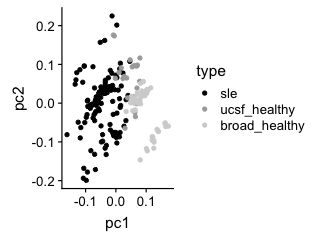

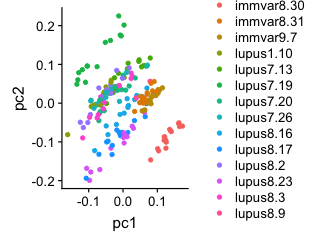

In [34]:
pbmc_expr_prcomp <- prcomp(pbmc_expr_std)

df <- rbind(data.frame(pc1=pbmc_expr_prcomp$rotation[sle_indices,1], pc2=pbmc_expr_prcomp$rotation[sle_indices,2], type="sle"),
            data.frame(pc1=pbmc_expr_prcomp$rotation[ucsf_healthy_indices,1], pc2=pbmc_expr_prcomp$rotation[ucsf_healthy_indices,2], type="ucsf_healthy"),
            data.frame(pc1=pbmc_expr_prcomp$rotation[broad_healthy_indices,1], pc2=pbmc_expr_prcomp$rotation[broad_healthy_indices,2], type="broad_healthy")
           )
df$batch = joined_pivot$batch_cov[match(rownames(df),joined_ind_cov_batch)]

options(repr.plot.width = 4, repr.plot.height = 3)
ggplot(aes(pc1,pc2,color=type),data=df)+geom_point()+scale_colour_manual(values=c("black","darkgray","lightgray"))

ggplot(aes(pc1,pc2,color=batch),data=df)+geom_point()

In [35]:
# pbmc_expr_prcomp <- prcomp(pbmc_expr_std[na.omit(match(pbmc_deseq_sig_genes,rownames(pbmc_expr_std))),])

# df <- rbind(data.frame(pc1=pbmc_expr_prcomp$rotation[sle_indices,1], pc2=pbmc_expr_prcomp$rotation[sle_indices,2], type="sle"),
#             data.frame(pc1=pbmc_expr_prcomp$rotation[ucsf_healthy_indices,1], pc2=pbmc_expr_prcomp$rotation[ucsf_healthy_indices,2], type="ucsf_healthy"),
#             data.frame(pc1=pbmc_expr_prcomp$rotation[broad_healthy_indices,1], pc2=pbmc_expr_prcomp$rotation[broad_healthy_indices,2], type="broad_healthy")
#            )
# df$batch = joined_pivot$batch_cov[match(rownames(df),joined_ind_cov_batch)]

# options(repr.plot.width = 4, repr.plot.height = 3)
# ggplot(aes(pc1,pc2,color=type),data=df)+geom_point()+scale_colour_manual(values=c("black","darkgray","lightgray"))

# ggplot(aes(pc1,pc2,color=batch),data=df)+geom_point()

## Load the raw counts from ```/ye/yelabstore2/10x.lupus/disease/demux.v2```

In [36]:
# ## either load only the original samples

# # cm_counts <- fread("v2.deseq/norep.noadjrace.CD14+.Monocytes.counts.txt");
# # colnames(cm_counts) <- sapply(colnames(cm_counts), function(x) {strsplit(x,"_")[[1]][[1]]})

# # th_counts <- fread("v2.deseq/norep.noadjrace.CD4.T.cells.counts.txt");
# # colnames(th_counts) <- sapply(colnames(th_counts), function(x) {strsplit(x,"_")[[1]][[1]]})

# # tc_counts <- fread("v2.deseq/norep.noadjrace.CD8.T.cells.counts.txt");
# # colnames(tc_counts) <- sapply(colnames(tc_counts), function(x) {strsplit(x,"_")[[1]][[1]]})

# # ncm_counts <- fread("v2.deseq/norep.noadjrace.FCGR3A+.Monocytes.counts.txt");
# # colnames(ncm_counts) <- sapply(colnames(ncm_counts), function(x) {strsplit(x,"_")[[1]][[1]]})

# # b_counts <- fread("v2.deseq/norep.noadjrace.B.cells.counts.txt");
# # colnames(b_counts) <- sapply(colnames(b_counts), function(x) {strsplit(x,"_")[[1]][[1]]})

# # nk_counts <- fread("v2.deseq/norep.noadjrace.NK.cells.counts.txt");
# # colnames(nk_counts) <- sapply(colnames(nk_counts), function(x) {strsplit(x,"_")[[1]][[1]]})

# # dc_counts <- fread("v2.deseq/norep.noadjrace.Dendritic.cells.counts.txt");
# # colnames(dc_counts) <- sapply(colnames(dc_counts), function(x) {strsplit(x,"_")[[1]][[1]]})

# # pbmc_counts <- fread("v2.deseq/norep.noadjrace.PBMC.counts.txt");
# # colnames(pbmc_counts) <- sapply(colnames(pbmc_counts), function(x) {strsplit(x,"_")[[1]][[1]]})


# ## or new with immvar as separate

# cm_counts <- fread("v5.deseq/v5.cM.counts.txt");
# colnames(cm_counts) <- sapply(colnames(cm_counts), function(x) {strsplit(x,"_")[[1]][[1]]})

# th_counts <- fread("v5.deseq/v5.Th.counts.txt");
# colnames(th_counts) <- sapply(colnames(th_counts), function(x) {strsplit(x,"_")[[1]][[1]]})

# tc_counts <- fread("v5.deseq/v5.Tc.counts.txt");
# colnames(tc_counts) <- sapply(colnames(tc_counts), function(x) {strsplit(x,"_")[[1]][[1]]})

# ncm_counts <- fread("v5.deseq/v5.ncM.counts.txt");
# colnames(ncm_counts) <- sapply(colnames(ncm_counts), function(x) {strsplit(x,"_")[[1]][[1]]})

# b_counts <- fread("v5.deseq/v5.B.counts.txt");
# colnames(b_counts) <- sapply(colnames(b_counts), function(x) {strsplit(x,"_")[[1]][[1]]})

# nk_counts <- fread("v5.deseq/v5.NK.counts.txt");
# colnames(nk_counts) <- sapply(colnames(nk_counts), function(x) {strsplit(x,"_")[[1]][[1]]})

# dc_counts <- fread("v5.deseq/v5.cDC.counts.txt");
# colnames(dc_counts) <- sapply(colnames(dc_counts), function(x) {strsplit(x,"_")[[1]][[1]]})

# pbmc_counts <- fread("v5.deseq/v5.PBMC.counts.txt");
# colnames(pbmc_counts) <- sapply(colnames(pbmc_counts), function(x) {strsplit(x,"_")[[1]][[1]]})


# counts_gene_names <- cm_counts$gene;
# cm_counts <- as.matrix(cm_counts[,-1]);
# pbmc_counts <- as.matrix(pbmc_counts[,-1]);
# th_counts <- as.matrix(th_counts[,-1]);
# tc_counts <- as.matrix(tc_counts[,-1]);
# b_counts <- as.matrix(b_counts[,-1]);
# ncm_counts <- as.matrix(ncm_counts[,-1]);
# nk_counts <- as.matrix(nk_counts[,-1]);
# dc_counts <- as.matrix(dc_counts[,-1]);

# all_counts_samples <- na.omit(match(colnames(pbmc_expr), colnames(pbmc_counts)))

# cm_counts <- cm_counts[,all_counts_samples]
# pbmc_counts <- pbmc_counts[,all_counts_samples]
# th_counts <- th_counts[,all_counts_samples]
# tc_counts <- tc_counts[,all_counts_samples]
# b_counts <- b_counts[,all_counts_samples]
# ncm_counts <- ncm_counts[,all_counts_samples]
# nk_counts <- nk_counts[,all_counts_samples]
# dc_counts <- dc_counts[,all_counts_samples]

# sle_counts_samples <- na.omit(match(colnames(pbmc_sle_expr), colnames(pbmc_counts)))

# cm_sle_counts <- cm_counts[,sle_counts_samples]
# th_sle_counts <- th_counts[,sle_counts_samples]
# tc_sle_counts <- tc_counts[,sle_counts_samples]
# ncm_sle_counts <- ncm_counts[,sle_counts_samples]
# b_sle_counts <- b_counts[,sle_counts_samples]
# nk_sle_counts <- nk_counts[,sle_counts_samples]
# dc_sle_counts <- dc_counts[,sle_counts_samples]
# pbmc_sle_counts <- pbmc_counts[,sle_counts_samples]


# healthy_counts_samples <- na.omit(match(colnames(pbmc_healthy_expr), colnames(pbmc_counts)))

# cm_healthy_counts <- cm_counts[,healthy_counts_samples]
# th_healthy_counts <- th_counts[,healthy_counts_samples]
# tc_healthy_counts <- tc_counts[,healthy_counts_samples]
# ncm_healthy_counts <- ncm_counts[,healthy_counts_samples]
# b_healthy_counts <- b_counts[,healthy_counts_samples]
# nk_healthy_counts <- nk_counts[,healthy_counts_samples]
# dc_healthy_counts <- dc_counts[,healthy_counts_samples]
# pbmc_healthy_counts <- pbmc_counts[,healthy_counts_samples]



## Load the differentially expression results

In [37]:
pbmc_deseq <- fread("v5.deseq/v5..PBMC.deseq.txt")##as.data.frame()
th_deseq <- as.data.frame(fread("v5.deseq/v5..Th.deseq.txt"))
tc_deseq <- as.data.frame(fread("v5.deseq/v5..Tc.deseq.txt"))
cm_deseq <- as.data.frame(fread("v5.deseq/v5..cM.deseq.txt"))
ncm_deseq <- as.data.frame(fread("v5.deseq/v5..ncM.deseq.txt"))
b_deseq <- as.data.frame(fread("v5.deseq/v5..B.deseq.txt"))
nk_deseq <- as.data.frame(fread("v5.deseq/v5..NK.deseq.txt"))
dc_deseq <- as.data.frame(fread("v5.deseq/v5..cDC.deseq.txt"))

pbmc_deseq_sig <- as.data.frame(fread("v5.deseq/v5..PBMC.deseq.sig.txt",header=F))$V1
th_deseq_sig <- as.data.frame(fread("v5.deseq/v5..Th.deseq.sig.txt",header=F))$V1
tc_deseq_sig <- as.data.frame(fread("v5.deseq/v5..Tc.deseq.sig.txt",header=F))$V1
cm_deseq_sig <- as.data.frame(fread("v5.deseq/v5..cM.deseq.sig.txt",header=F))$V1
ncm_deseq_sig <- as.data.frame(fread("v5.deseq/v5..ncM.deseq.sig.txt",header=F))$V1
b_deseq_sig <- as.data.frame(fread("v5.deseq/v5..B.deseq.sig.txt",header=F))$V1
nk_deseq_sig <- as.data.frame(fread("v5.deseq/v5..NK.deseq.sig.txt",header=F))$V1
dc_deseq_sig <- as.data.frame(fread("v5.deseq/v5..cDC.deseq.sig.txt",header=F))$V1
union_deseq_sig <- unique(c(pbmc_deseq_sig, cm_deseq_sig, th_deseq_sig, 
                            tc_deseq_sig, b_deseq_sig, ncm_deseq_sig, nk_deseq_sig, dc_deseq_sig));

Warning message in fread("v5.deseq/v5..PBMC.deseq.txt"):
“Detected 7 column names but the data has 8 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”Warning message in fread("v5.deseq/v5..Th.deseq.txt"):
“Detected 7 column names but the data has 8 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”Warning message in fread("v5.deseq/v5..Tc.deseq.txt"):
“Detected 7 column names but the data has 8 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not 

In [38]:
pbmc_deseq_sig_genes <- pbmc_deseq$V1[intersect(which(pbmc_deseq$baseMean > 25), intersect(which(abs(pbmc_deseq$log2FoldChange)>1),which(pbmc_deseq$qval < 0.01)))]
cm_deseq_sig_genes <- cm_deseq$V1[intersect(which(cm_deseq$baseMean > 25), intersect(which(abs(cm_deseq$log2FoldChange)>1),which(cm_deseq$qval < 0.01)))]
th_deseq_sig_genes <- th_deseq$V1[intersect(which(th_deseq$baseMean > 25), intersect(which(abs(th_deseq$log2FoldChange)>1),which(th_deseq$qval < 0.01)))]
tc_deseq_sig_genes <- tc_deseq$V1[intersect(which(tc_deseq$baseMean > 25), intersect(which(abs(tc_deseq$log2FoldChange)>1),which(tc_deseq$qval < 0.01)))]
b_deseq_sig_genes <- b_deseq$V1[intersect(which(b_deseq$baseMean > 25), intersect(which(abs(b_deseq$log2FoldChange)>1),which(b_deseq$qval < 0.01)))]
ncm_deseq_sig_genes <- ncm_deseq$V1[intersect(which(ncm_deseq$baseMean > 25), intersect(which(abs(ncm_deseq$log2FoldChange)>1),which(ncm_deseq$qval < 0.01)))]
nk_deseq_sig_genes <- nk_deseq$V1[intersect(which(nk_deseq$baseMean > 25), intersect(which(abs(nk_deseq$log2FoldChange)>1),which(nk_deseq$qval < 0.01)))]
dc_deseq_sig_genes <- dc_deseq$V1[intersect(which(dc_deseq$baseMean > 25), intersect(which(abs(dc_deseq$log2FoldChange)>1),which(dc_deseq$qval < 0.01)))]

union_deseq_sig_genes <- unique(c(pbmc_deseq_sig_genes, cm_deseq_sig_genes, ncm_deseq_sig_genes, dc_deseq_sig_genes, th_deseq_sig_genes, tc_deseq_sig_genes,  nk_deseq_sig_genes,b_deseq_sig_genes))
length(union_deseq_sig_genes)
length(pbmc_deseq_sig_genes)
length(intersect(pbmc_deseq_sig_genes, union_deseq_sig_genes))

deseq_sig_genes <- union_deseq_sig_genes

[1] 209

[1] 149

[1] 149

In [39]:
standardize <- function(x) {(x-mean(x))/sd(x)}

all_expr_standardize <- data.frame(pbmc=t(apply(pbmc_expr,1,standardize)),
                      cm=t(apply(cm_expr,1,standardize)),
                      ncm=t(apply(ncm_expr,1,standardize)),
                      dc=t(apply(dc_expr,1,standardize)),
                      th=t(apply(th_expr,1,standardize)),
                      tc=t(apply(tc_expr,1,standardize)),
                       nk=t(apply(nk_expr,1,standardize)),
                      b=t(apply(b_expr,1,standardize)),
                        dc=t(apply(dc_expr,1,standardize))
                      )


all_expr <- data.frame(pbmc=pbmc_expr,
                      cm=cm_expr,
                      ncm=ncm_expr,
                      dc=dc_expr,
                      th=th_expr,
                      tc=tc_expr,
                       nk=nk_expr,
                      b=b_expr
                      )

all_expr_sle <- data.frame(pbmc=pbmc_sle_expr,
                      cm=cm_sle_expr,
                      ncm=ncm_sle_expr,
                      dc=dc_sle_expr,
                      th=th_sle_expr,
                      tc=tc_sle_expr,
                       nk=nk_sle_expr,
                      b=b_sle_expr
                      )
rownames(all_expr_sle) <- rownames(all_expr)


In [40]:
set.seed(1)
kmeans_rst <- kmeans(all_expr[match(deseq_sig_genes,expr_gene_names),], 7)

cell_types <- c("PBMC","cM","ncM", "DC","Th","Tc","NK","B")
ct_annotation <- data.frame(type=factor(rep(cell_types,each=ncol(ncm_expr))),
                           disease=factor(rep(c(rep("sle",ncol(cm_sle_expr)),
                                                rep("ucsf_ctrl",ncol(cm_ucsf_healthy_expr)),
                                                rep("broad_ctrl",ncol(cm_broad_healthy_expr))),
                                              length(cell_types))))
rownames(ct_annotation) <- colnames(all_expr);

kmeans_annotation <- data.frame(cluster=factor(kmeans_rst$cluster,levels=c("1","2","6","7","3","4","5")))
rownames(kmeans_annotation) <- deseq_sig_genes;

all_expr_sig <- all_expr[match(deseq_sig_genes,expr_gene_names),]
all_expr_sig_ordered <- all_expr[match(deseq_sig_genes,expr_gene_names),][order(kmeans_annotation$cluster),]

all_expr_standardize_sig <- all_expr_standardize[match(deseq_sig_genes,expr_gene_names),]
all_expr_standardize_sig_ordered <- all_expr_standardize[match(deseq_sig_genes,expr_gene_names),][order(kmeans_annotation$cluster),]

kmeans_ordered_annotation <- kmeans_annotation[order(kmeans_annotation$cluster),]

all_expr_sle_sig <- all_expr_sle[match(deseq_sig_genes,expr_gene_names),]
all_expr_sle_sig_ordered <- all_expr_sle[match(deseq_sig_genes,expr_gene_names),][order(kmeans_annotation$cluster),]
##kmeans_ordered_annotation <- kmeans_annotation[order(kmeans_annotation$cluster),]


##bct_annotation <- list(ct_annotation=ct_annotation)

## Load the joined table and preprocess the expression and counts data

In [41]:
# joined_pivot <- fread(paste(name,'_joined_pivot_ct_perc.txt', sep=""), sep=",")
# joined_pivot <- as.data.frame(joined_pivot);
# ## filter for ucsf healthy only
# ##joined_pivot <- joined_pivot[grep("lupus",joined_pivot$batch_cov),]

joined_ind_cov_batch = paste(joined_pivot$ind_cov, joined_pivot$batch, sep="_")
# ##joined_pivot$batch_cov <- as.factor(joined_pivot$batch_cov)

# ind_cov = sapply(cm_covs[,"sample"], function(x) {strsplit(as.character(x),"_")[[1]][[1]]})
# ind_cov_batch = paste(ind_cov, cm_covs[,"batch"], sep="_")
# joined_ind_cov_batch = paste(joined_pivot$ind_cov, joined_pivot$batch, sep="_")
# ucsf_samples_nodups <- na.omit(match(joined_ind_cov_batch, ind_cov_batch));

# joined_pivot_filtered <- joined_pivot[match(c(colnames(pbmc_sle_expr),colnames(pbmc_ucsf_healthy_expr),colnames(pbmc_broad_healthy_expr)),joined_ind_cov_batch),]
joined_pivot_sle <- joined_pivot[match(colnames(pbmc_sle_expr), joined_ind_cov_batch),]
joined_pivot_ucsf_healthy <- joined_pivot[match(colnames(pbmc_ucsf_healthy_expr), joined_ind_cov_batch),]
joined_pivot_broad_healthy <- joined_pivot[match(colnames(pbmc_broad_healthy_expr), joined_ind_cov_batch),]

## get the cell type proportions

In [42]:
cm_prop = joined_pivot$"cM";##/joined_pivot_filtered$pbmc;
th_prop = joined_pivot$"Th";##/joined_pivot_filtered$pbmc;
b_prop = joined_pivot$"B";##/joined_pivot_filtered$pbmc;
nk_prop = joined_pivot$"NK";##/joined_pivot_filtered$pbmc;
ncm_prop = joined_pivot$"ncM";#/joined_pivot_filtered$pbmc;
tc_prop = joined_pivot$"Tc";#/joined_pivot_filtered$pbmc;
dc_prop = joined_pivot$"cDC";#/joined_pivot_filtered$pbmc;

joined_ind_cov_batch = paste(joined_pivot$ind_cov, joined_pivot$batch, sep="_")

## set the NAs to 0
b_prop[which(is.na(b_prop))] <- 0;
dc_prop[which(is.na(dc_prop))] <- 0;

cm_sle_prop = cm_prop[match(colnames(pbmc_sle_expr), joined_ind_cov_batch)]
th_sle_prop = th_prop[match(colnames(pbmc_sle_expr), joined_ind_cov_batch)]
b_sle_prop = b_prop[match(colnames(pbmc_sle_expr), joined_ind_cov_batch)]
nk_sle_prop = nk_prop[match(colnames(pbmc_sle_expr), joined_ind_cov_batch)]
ncm_sle_prop = ncm_prop[match(colnames(pbmc_sle_expr), joined_ind_cov_batch)]
tc_sle_prop = tc_prop[match(colnames(pbmc_sle_expr), joined_ind_cov_batch)]
dc_sle_prop = dc_prop[match(colnames(pbmc_sle_expr), joined_ind_cov_batch)]
names(cm_sle_prop) <- names(th_sle_prop) <- names(b_sle_prop) <- names(nk_sle_prop) <- names(ncm_sle_prop) <- names(tc_sle_prop) <- names(dc_sle_prop) <- joined_ind_cov_batch[match(colnames(pbmc_sle_expr), joined_ind_cov_batch)]

cm_ucsf_healthy_prop = cm_prop[match(colnames(pbmc_ucsf_healthy_expr), joined_ind_cov_batch)]
th_ucsf_healthy_prop = th_prop[match(colnames(pbmc_ucsf_healthy_expr), joined_ind_cov_batch)]
b_ucsf_healthy_prop = b_prop[match(colnames(pbmc_ucsf_healthy_expr), joined_ind_cov_batch)]
nk_ucsf_healthy_prop = nk_prop[match(colnames(pbmc_ucsf_healthy_expr), joined_ind_cov_batch)]
ncm_ucsf_healthy_prop = ncm_prop[match(colnames(pbmc_ucsf_healthy_expr), joined_ind_cov_batch)]
tc_ucsf_healthy_prop = tc_prop[match(colnames(pbmc_ucsf_healthy_expr), joined_ind_cov_batch)]
dc_ucsf_healthy_prop = dc_prop[match(colnames(pbmc_ucsf_healthy_expr), joined_ind_cov_batch)]
names(cm_ucsf_healthy_prop) <- names(th_ucsf_healthy_prop) <- names(b_ucsf_healthy_prop) <- names(nk_ucsf_healthy_prop) <- names(ncm_ucsf_healthy_prop) <- names(tc_ucsf_healthy_prop) <- names(dc_ucsf_healthy_prop) <- joined_ind_cov_batch[match(colnames(pbmc_ucsf_healthy_expr), joined_ind_cov_batch)]

cm_broad_healthy_prop = cm_prop[match(colnames(pbmc_broad_healthy_expr), joined_ind_cov_batch)]
th_broad_healthy_prop = th_prop[match(colnames(pbmc_broad_healthy_expr), joined_ind_cov_batch)]
b_broad_healthy_prop = b_prop[match(colnames(pbmc_broad_healthy_expr), joined_ind_cov_batch)]
nk_broad_healthy_prop = nk_prop[match(colnames(pbmc_broad_healthy_expr), joined_ind_cov_batch)]
ncm_broad_healthy_prop = ncm_prop[match(colnames(pbmc_broad_healthy_expr), joined_ind_cov_batch)]
tc_broad_healthy_prop = tc_prop[match(colnames(pbmc_broad_healthy_expr), joined_ind_cov_batch)]
dc_broad_healthy_prop = dc_prop[match(colnames(pbmc_broad_healthy_expr), joined_ind_cov_batch)]
names(cm_broad_healthy_prop) <- names(th_broad_healthy_prop) <- names(b_broad_healthy_prop) <- names(nk_broad_healthy_prop) <- names(ncm_broad_healthy_prop) <- names(tc_broad_healthy_prop) <- names(dc_broad_healthy_prop) <- joined_ind_cov_batch[match(colnames(pbmc_broad_healthy_expr), joined_ind_cov_batch)]


In [46]:
cor(colMeans(cm_expr), props[,"cM"])
cor(colMeans(th_expr), props[,"Th"])
cor(colMeans(tc_expr), props[,"Tc"])
cor(colMeans(nk_expr), props[,"NK"])
cor(colMeans(ncm_expr), props[,"ncM"])

[1] -0.4051244

[1] -0.08388136

[1] -0.3213505

[1] -0.2517009

[1] -0.4049149

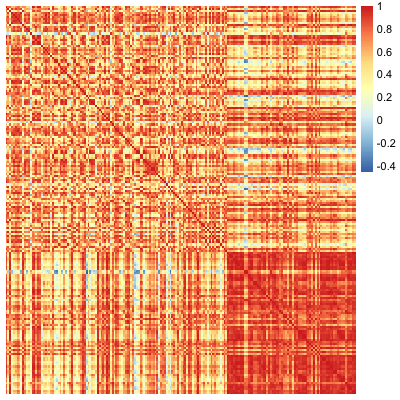

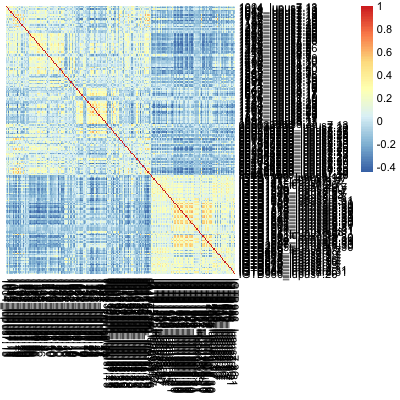

In [18]:
options(repr.plot.width = 5, repr.plot.height = 5)
pheatmap(cor(t(cbind(cm_prop, th_prop, b_prop, nk_prop, ncm_prop, tc_prop, dc_prop))),cluster_rows=F,cluster_cols=F)
options(repr.plot.width = 5, repr.plot.height = 5)
pheatmap(cor(cbind(pbmc_expr_std)),cluster_rows=F,cluster_cols=F)

# Let's do some batch adjustments

## first, let's adjust cell type proportion

In [19]:
# cm_prop_mean = lm(cm_prop~1)$fitted;
# th_prop_mean = lm(th_prop~1)$fitted;
# b_prop_mean = lm(b_prop~1)$fitted;
# nk_prop_mean = lm(nk_prop~1)$fitted;
# ncm_prop_mean = lm(ncm_prop~1)$fitted;
# tc_prop_mean = lm(tc_prop~1)$fitted;
# dc_prop_mean = lm(dc_prop~1)$fitted;

# cm_prop = lm(cm_prop~joined_pivot$batch_cov)$residual+cm_prop_mean;
# th_prop = lm(th_prop~joined_pivot$batch_cov)$residual+th_prop_mean;
# b_prop = lm(b_prop~joined_pivot$batch_cov)$residual+b_prop_mean;
# nk_prop = lm(nk_prop~joined_pivot$batch_cov)$residual+nk_prop_mean;
# ncm_prop = lm(ncm_prop~joined_pivot$batch_cov)$residual+ncm_prop_mean;
# tc_prop = lm(tc_prop~joined_pivot$batch_cov)$residual+tc_prop_mean;
# dc_prop = lm(dc_prop~joined_pivot$batch_cov)$residual+dc_prop_mean;
props <- as.matrix(data.frame(cM=cm_prop, Th=th_prop, B=b_prop, NK=nk_prop, ncM=ncm_prop, Tc=tc_prop, DC=dc_prop));

# cm_sle_prop_mean = lm(cm_sle_prop~1)$fitted;
# th_sle_prop_mean = lm(th_sle_prop~1)$fitted;
# b_sle_prop_mean = lm(b_sle_prop~1)$fitted;
# ncm_sle_prop_mean = lm(ncm_sle_prop~1)$fitted;
# nk_sle_prop_mean = lm(nk_sle_prop~1)$fitted;
# tc_sle_prop_mean = lm(tc_sle_prop~1)$fitted;
# dc_sle_prop_mean = lm(dc_sle_prop~1)$fitted;

# cm_sle_prop = lm(cm_sle_prop~joined_pivot_sle$batch_cov)$residual+cm_sle_prop_mean;
# th_sle_prop = lm(th_sle_prop~joined_pivot_sle$batch_cov)$residual+th_sle_prop_mean;
# b_sle_prop = lm(b_sle_prop~joined_pivot_sle$batch_cov)$residual+b_sle_prop_mean;
# nk_sle_prop = lm(nk_sle_prop~joined_pivot_sle$batch_cov)$residual+nk_sle_prop_mean;
# ncm_sle_prop = lm(ncm_sle_prop~joined_pivot_sle$batch_cov)$residual+ncm_sle_prop_mean;
# tc_sle_prop = lm(tc_sle_prop~joined_pivot_sle$batch_cov)$residual+tc_sle_prop_mean;
# dc_sle_prop = lm(dc_sle_prop~joined_pivot_sle$batch_cov)$residual+dc_sle_prop_mean;
props_sle <- as.matrix(data.frame(cM=cm_sle_prop, Th=th_sle_prop, B=b_sle_prop, NK=nk_sle_prop, ncM=ncm_sle_prop, Tc=tc_sle_prop, DC=dc_sle_prop));


# cm_ucsf_healthy_prop_mean = lm(cm_ucsf_healthy_prop~1)$fitted;
# th_ucsf_healthy_prop_mean = lm(th_ucsf_healthy_prop~1)$fitted;
# b_ucsf_healthy_prop_mean = lm(b_ucsf_healthy_prop~1)$fitted;
# ncm_ucsf_healthy_prop_mean = lm(ncm_ucsf_healthy_prop~1)$fitted;
# nk_ucsf_healthy_prop_mean = lm(nk_ucsf_healthy_prop~1)$fitted;
# tc_ucsf_healthy_prop_mean = lm(tc_ucsf_healthy_prop~1)$fitted;
# dc_ucsf_healthy_prop_mean = lm(dc_ucsf_healthy_prop~1)$fitted;

# cm_ucsf_healthy_prop = lm(cm_ucsf_healthy_prop~joined_pivot_ucsf_healthy$batch_cov)$residual+cm_ucsf_healthy_prop_mean;
# th_ucsf_healthy_prop = lm(th_ucsf_healthy_prop~joined_pivot_ucsf_healthy$batch_cov)$residual+th_ucsf_healthy_prop_mean;
# b_ucsf_healthy_prop = lm(b_ucsf_healthy_prop~joined_pivot_ucsf_healthy$batch_cov)$residual+b_ucsf_healthy_prop_mean;
# nk_ucsf_healthy_prop = lm(nk_ucsf_healthy_prop~joined_pivot_ucsf_healthy$batch_cov)$residual+nk_ucsf_healthy_prop_mean;
# ncm_ucsf_healthy_prop = lm(ncm_ucsf_healthy_prop~joined_pivot_ucsf_healthy$batch_cov)$residual+ncm_ucsf_healthy_prop_mean;
# tc_ucsf_healthy_prop = lm(tc_ucsf_healthy_prop~joined_pivot_ucsf_healthy$batch_cov)$residual+tc_ucsf_healthy_prop_mean;
# dc_ucsf_healthy_prop = lm(dc_ucsf_healthy_prop~joined_pivot_ucsf_healthy$batch_cov)$residual+dc_ucsf_healthy_prop_mean;
props_ucsf_healthy <- as.matrix(data.frame(cM=cm_ucsf_healthy_prop, Th=th_ucsf_healthy_prop, B=b_ucsf_healthy_prop, NK=nk_ucsf_healthy_prop, ncM=ncm_ucsf_healthy_prop, Tc=tc_ucsf_healthy_prop, DC=dc_ucsf_healthy_prop));

# cm_broad_healthy_prop_mean = lm(cm_broad_healthy_prop~1)$fitted;
# th_broad_healthy_prop_mean = lm(th_broad_healthy_prop~1)$fitted;
# b_broad_healthy_prop_mean = lm(b_broad_healthy_prop~1)$fitted;
# ncm_broad_healthy_prop_mean = lm(ncm_broad_healthy_prop~1)$fitted;
# nk_broad_healthy_prop_mean = lm(nk_broad_healthy_prop~1)$fitted;
# tc_broad_healthy_prop_mean = lm(tc_broad_healthy_prop~1)$fitted;
# dc_broad_healthy_prop_mean = lm(dc_broad_healthy_prop~1)$fitted;

# cm_broad_healthy_prop = lm(cm_broad_healthy_prop~joined_pivot_broad_healthy$batch_cov)$residual+cm_broad_healthy_prop_mean;
# th_broad_healthy_prop = lm(th_broad_healthy_prop~joined_pivot_broad_healthy$batch_cov)$residual+th_broad_healthy_prop_mean;
# b_broad_healthy_prop = lm(b_broad_healthy_prop~joined_pivot_broad_healthy$batch_cov)$residual+b_broad_healthy_prop_mean;
# nk_broad_healthy_prop = lm(nk_broad_healthy_prop~joined_pivot_broad_healthy$batch_cov)$residual+nk_broad_healthy_prop_mean;
# ncm_broad_healthy_prop = lm(ncm_broad_healthy_prop~joined_pivot_broad_healthy$batch_cov)$residual+ncm_broad_healthy_prop_mean;
# tc_broad_healthy_prop = lm(tc_broad_healthy_prop~joined_pivot_broad_healthy$batch_cov)$residual+tc_broad_healthy_prop_mean;
# dc_broad_healthy_prop = lm(dc_broad_healthy_prop~joined_pivot_broad_healthy$batch_cov)$residual+dc_broad_healthy_prop_mean;
props_broad_healthy <- as.matrix(data.frame(cM=cm_broad_healthy_prop, Th=th_broad_healthy_prop, B=b_broad_healthy_prop, NK=nk_broad_healthy_prop, ncM=ncm_broad_healthy_prop, Tc=tc_broad_healthy_prop, DC=dc_broad_healthy_prop));


## second, let's adjust cell type specific expression

In [21]:
pbmc_mean <- t(lm(t(pbmc_expr)~1)$fitted)
cm_mean <- t(lm(t(cm_expr)~1)$fitted)
th_mean <- t(lm(t(th_expr)~1)$fitted)
b_mean <- t(lm(t(b_expr)~1)$fitted)
nk_mean <- t(lm(t(nk_expr)~1)$fitted)
ncm_mean <- t(lm(t(ncm_expr)~1)$fitted)
tc_mean <- t(lm(t(tc_expr)~1)$fitted)
dc_mean <- t(lm(t(dc_expr)~1)$fitted)

joined_pivot$seq_batch_cov <- grep("immvar",joined_pivot$batch_cov)

# pbmc_expr <- t(lm(t(pbmc_expr)~joined_pivot_filtered$batch_cov*joined_pivot_filtered$seq_batch_cov)$residuals)+pbmc_mean
# cm_expr <- t(lm(t(cm_expr)~joined_pivot_filtered$batch_cov*joined_pivot_filtered$seq_batch_cov)$residuals)+cm_mean
# th_expr <- t(lm(t(th_expr)~joined_pivot_filtered$batch_cov*joined_pivot_filtered$seq_batch_cov)$residuals)+th_mean
# b_expr <- t(lm(t(b_expr)~joined_pivot_filtered$batch_cov*joined_pivot_filtered$seq_batch_cov)$residuals)+b_mean
# nk_expr <- t(lm(t(nk_expr)~joined_pivot_filtered$batch_cov*joined_pivot_filtered$seq_batch_cov)$residuals)+nk_mean
# ncm_expr <- t(lm(t(ncm_expr)~joined_pivot_filtered$batch_cov*joined_pivot_filtered$seq_batch_cov)$residuals)+ncm_mean
# tc_expr <- t(lm(t(tc_expr)~joined_pivot_filtered$batch_cov*joined_pivot_filtered$seq_batch_cov)$residuals)+tc_mean
# dc_expr <- t(lm(t(dc_expr)~joined_pivot_filtered$batch_cov*joined_pivot_filtered$seq_batch_cov)$residuals)+dc_mean
# exprs <- array(c(cm_expr, th_expr, b_expr, nk_expr, ncm_expr, tc_expr, dc_expr),
#                c(nrow(cm_expr) , ncol(cm_expr), 7),
#                list(rownames(cm_expr),colnames(cm_expr),c("cM","Th","B","NK","ncM","Tc","DC")))

modcombat = model.matrix(~disease_cov, data=joined_pivot);

pbmc_expr <- ComBat(dat=pbmc_expr, batch=joined_pivot$batch_cov, mod=modcombat, par.prior=TRUE, prior.plots=FALSE)
cm_expr <-  ComBat(dat=cm_expr, batch=joined_pivot$batch_cov, mod=modcombat, par.prior=TRUE, prior.plots=FALSE)
th_expr <-  ComBat(dat=th_expr, batch=joined_pivot$batch_cov, mod=modcombat, par.prior=TRUE, prior.plots=FALSE)
b_expr <-  ComBat(dat=b_expr, batch=joined_pivot$batch_cov, mod=modcombat, par.prior=TRUE, prior.plots=FALSE)
nk_expr <-  ComBat(dat=nk_expr, batch=joined_pivot$batch_cov, mod=modcombat, par.prior=TRUE, prior.plots=FALSE)
ncm_expr <-  ComBat(dat=ncm_expr, batch=joined_pivot$batch_cov, mod=modcombat, par.prior=TRUE, prior.plots=FALSE)
tc_expr <-  ComBat(dat=tc_expr, batch=joined_pivot$batch_cov, mod=modcombat, par.prior=TRUE, prior.plots=FALSE)
dc_expr <-  ComBat(dat=dc_expr, batch=joined_pivot$batch_cov, mod=modcombat, par.prior=TRUE, prior.plots=FALSE)
exprs <- array(c(cm_expr, th_expr, b_expr, nk_expr, ncm_expr, tc_expr, dc_expr),
               c(nrow(cm_expr) , ncol(cm_expr), 7),
               list(rownames(cm_expr),colnames(cm_expr),c("cM","Th","B","NK","ncM","Tc","DC")))

# pbmc_expr <- t(lm(t(pbmc_expr)~joined_pivot_filtered$batch_cov*joined_pivot_filtered$disease_cov)$residuals)+pbmc_mean
# cm_expr <- t(lm(t(cm_expr)~joined_pivot_filtered$batch_cov*joined_pivot_filtered$disease_cov)$residuals)+cm_mean
# th_expr <- t(lm(t(th_expr)~joined_pivot_filtered$batch_cov*joined_pivot_filtered$disease_cov)$residuals)+th_mean
# b_expr <- t(lm(t(b_expr)~joined_pivot_filtered$batch_cov*joined_pivot_filtered$disease_cov)$residuals)+b_mean
# nk_expr <- t(lm(t(nk_expr)~joined_pivot_filtered$batch_cov*joined_pivot_filtered$disease_cov)$residuals)+nk_mean
# ncm_expr <- t(lm(t(ncm_expr)~joined_pivot_filtered$batch_cov*joined_pivot_filtered$disease_cov)$residuals)+ncm_mean
# tc_expr <- t(lm(t(tc_expr)~joined_pivot_filtered$batch_cov*joined_pivot_filtered$disease_cov)$residuals)+tc_mean
# dc_expr <- t(lm(t(dc_expr)~joined_pivot_filtered$batch_cov*joined_pivot_filtered$disease_cov)$residuals)+dc_mean
# exprs <- array(c(cm_expr, th_expr, b_expr, nk_expr, ncm_expr, tc_expr, dc_expr),
#                c(nrow(cm_expr) , ncol(cm_expr), 7),
#                list(rownames(cm_expr),colnames(cm_expr),c("cM","Th","B","NK","ncM","Tc","DC")))


# pbmc_expr <- t(lm(t(pbmc_expr)~joined_pivot_filtered$batch_cov)$residuals)+pbmc_mean
# cm_expr <- t(lm(t(cm_expr)~joined_pivot_filtered$batch_cov)$residuals)+cm_mean
# th_expr <- t(lm(t(th_expr)~joined_pivot_filtered$batch_cov)$residuals)+th_mean
# b_expr <- t(lm(t(b_expr)~joined_pivot_filtered$batch_cov)$residuals)+b_mean
# nk_expr <- t(lm(t(nk_expr)~joined_pivot_filtered$batch_cov)$residuals)+nk_mean
# ncm_expr <- t(lm(t(ncm_expr)~joined_pivot_filtered$batch_cov)$residuals)+ncm_mean
# tc_expr <- t(lm(t(tc_expr)~joined_pivot_filtered$batch_cov)$residuals)+tc_mean
# dc_expr <- t(lm(t(dc_expr)~joined_pivot_filtered$batch_cov)$residuals)+dc_mean
# exprs <- array(c(cm_expr, th_expr, b_expr, nk_expr, ncm_expr, tc_expr, dc_expr),
#                c(nrow(cm_expr) , ncol(cm_expr), 7),
#                list(rownames(cm_expr),colnames(cm_expr),c("cM","Th","B","NK","ncM","Tc","DC")))

# pbmc_expr <- t(lm(t(pbmc_expr)~1)$residuals)+pbmc_mean
# cm_expr <- t(lm(t(cm_expr)~1)$residuals)+cm_mean
# th_expr <- t(lm(t(th_expr)~1)$residuals)+th_mean
# b_expr <- t(lm(t(b_expr)~1)$residuals)+b_mean
# nk_expr <- t(lm(t(nk_expr)~1)$residuals)+nk_mean
# ncm_expr <- t(lm(t(ncm_expr)~1)$residuals)+ncm_mean
# tc_expr <- t(lm(t(tc_expr)~1)$residuals)+tc_mean
# dc_expr <- t(lm(t(dc_expr)~1)$residuals)+dc_mean
# exprs <- array(c(cm_expr, th_expr, b_expr, nk_expr, ncm_expr, tc_expr, dc_expr),
#                c(nrow(cm_expr) , ncol(cm_expr), 7),
#                list(rownames(cm_expr),colnames(cm_expr),c("cM","Th","B","NK","ncM","Tc","DC")))

pbmc_expr_std <- t(apply(pbmc_expr,1,standardize))
cm_expr_std <- t(apply(cm_expr,1,standardize))
cm_expr_std[is.na(cm_expr_std)] <- 0
th_expr_std <- t(apply(th_expr,1,standardize))
th_expr_std[is.na(th_expr_std)] <- 0
b_expr_std <- t(apply(b_expr,1,standardize))
b_expr_std[is.na(b_expr_std)] <- 0
nk_expr_std <- t(apply(nk_expr,1,standardize))
nk_expr_std[is.na(nk_expr_std)] <- 0
ncm_expr_std <- t(apply(ncm_expr,1,standardize))
ncm_expr_std[is.na(ncm_expr_std)] <- 0
tc_expr_std <- t(apply(tc_expr,1,standardize))
tc_expr_std[is.na(tc_expr_std)] <- 0
dc_expr_std <- t(apply(dc_expr,1,standardize))
dc_expr_std[is.na(dc_expr_std)] <- 0
exprs_std <- array(c(cm_expr_std, th_expr_std, b_expr_std, nk_expr_std, ncm_expr_std, tc_expr_std, dc_expr_std),
                   c(nrow(cm_expr) , ncol(cm_expr), 7), 
                   list(rownames(cm_expr),colnames(cm_expr),c("cM","Th","B","NK","ncM","Tc","DC")))

# pbmc_sle_mean <- t(lm(t(pbmc_sle_expr)~1)$fitted)
# cm_sle_mean <- t(lm(t(cm_sle_expr)~1)$fitted)
# th_sle_mean <- t(lm(t(th_sle_expr)~1)$fitted)
# b_sle_mean <- t(lm(t(b_sle_expr)~1)$fitted)
# nk_sle_mean <- t(lm(t(nk_sle_expr)~1)$fitted)
# ncm_sle_mean <- t(lm(t(ncm_sle_expr)~1)$fitted)
# tc_sle_mean <- t(lm(t(tc_sle_expr)~1)$fitted)
# dc_sle_mean <- t(lm(t(dc_sle_expr)~1)$fitted)

# pbmc_sle_expr <- t(lm(t(pbmc_sle_expr)~joined_pivot_sle$batch_cov)$residuals)+pbmc_sle_mean
# cm_sle_expr <- t(lm(t(cm_sle_expr)~joined_pivot_sle$batch_cov)$residuals)+cm_sle_mean
# th_sle_expr <- t(lm(t(th_sle_expr)~joined_pivot_sle$batch_cov)$residuals)+th_sle_mean
# b_sle_expr <- t(lm(t(b_sle_expr)~joined_pivot_sle$batch_cov)$residuals)+b_sle_mean
# nk_sle_expr <- t(lm(t(nk_sle_expr)~joined_pivot_sle$batch_cov)$residuals)+nk_sle_mean
# ncm_sle_expr <- t(lm(t(ncm_sle_expr)~joined_pivot_sle$batch_cov)$residuals)+ncm_sle_mean
# tc_sle_expr <- t(lm(t(tc_sle_expr)~joined_pivot_sle$batch_cov)$residuals)+tc_sle_mean
# dc_sle_expr <- t(lm(t(dc_sle_expr)~joined_pivot_sle$batch_cov)$residuals)+dc_sle_mean
# exprs_sle <- array(c(cm_sle_expr, th_sle_expr, b_sle_expr, nk_sle_expr, ncm_sle_expr, tc_sle_expr, dc_sle_expr),
#                    c(nrow(cm_sle_expr) , ncol(cm_sle_expr), 7),
#                    list(rownames(cm_sle_expr),colnames(cm_sle_expr),c("cM","Th","B","NK","ncM","Tc","DC")))


cm_sle_expr <- cm_expr[,sle_indices]
th_sle_expr <- th_expr[,sle_indices]
tc_sle_expr <- tc_expr[,sle_indices]
ncm_sle_expr <- ncm_expr[,sle_indices]
b_sle_expr <- b_expr[,sle_indices]
nk_sle_expr <- nk_expr[,sle_indices]
dc_sle_expr <- dc_expr[,sle_indices]
pbmc_sle_expr <- pbmc_expr[,sle_indices]
exprs_sle <- array(c(cm_sle_expr, th_sle_expr, b_sle_expr, nk_sle_expr, ncm_sle_expr, tc_sle_expr, dc_sle_expr),
                       c(nrow(cm_sle_expr) , ncol(cm_sle_expr), 7),
                       list(rownames(cm_sle_expr),colnames(cm_sle_expr),c("cM","Th","B","NK","ncM","Tc","DC")))

pbmc_sle_expr_std <- t(apply(pbmc_sle_expr,1,standardize))
cm_sle_expr_std <- t(apply(cm_sle_expr,1,standardize))
cm_sle_expr_std[is.na(cm_sle_expr_std)] <- 0
th_sle_expr_std <- t(apply(th_sle_expr,1,standardize))
th_sle_expr_std[is.na(th_sle_expr_std)] <- 0
b_sle_expr_std <- t(apply(b_sle_expr,1,standardize))
b_sle_expr_std[is.na(b_sle_expr_std)] <- 0
nk_sle_expr_std <- t(apply(nk_sle_expr,1,standardize))
nk_sle_expr_std[is.na(nk_sle_expr_std)] <- 0
ncm_sle_expr_std <- t(apply(ncm_sle_expr,1,standardize))
ncm_sle_expr_std[is.na(ncm_sle_expr_std)] <- 0
tc_sle_expr_std <- t(apply(tc_sle_expr,1,standardize))
tc_sle_expr_std[is.na(tc_sle_expr_std)] <- 0
dc_sle_expr_std <- t(apply(dc_sle_expr,1,standardize))
dc_sle_expr_std[is.na(dc_sle_expr_std)] <- 0
exprs_sle_std <- array(c(cm_sle_expr_std, th_sle_expr_std, b_sle_expr_std, nk_sle_expr_std, ncm_sle_expr_std, tc_sle_expr_std, dc_sle_expr_std),
                       c(nrow(cm_sle_expr) , ncol(cm_sle_expr), 7),
                       list(rownames(cm_sle_expr),colnames(cm_sle_expr),c("cM","Th","B","NK","ncM","Tc","DC")))

# pbmc_ucsf_healthy_mean <- t(lm(t(pbmc_ucsf_healthy_expr)~1)$fitted)
# cm_ucsf_healthy_mean <- t(lm(t(cm_ucsf_healthy_expr)~1)$fitted)
# th_ucsf_healthy_mean <- t(lm(t(th_ucsf_healthy_expr)~1)$fitted)
# b_ucsf_healthy_mean <- t(lm(t(b_ucsf_healthy_expr)~1)$fitted)
# nk_ucsf_healthy_mean <- t(lm(t(nk_ucsf_healthy_expr)~1)$fitted)
# ncm_ucsf_healthy_mean <- t(lm(t(ncm_ucsf_healthy_expr)~1)$fitted)
# tc_ucsf_healthy_mean <- t(lm(t(tc_ucsf_healthy_expr)~1)$fitted)
# dc_ucsf_healthy_mean <- t(lm(t(dc_ucsf_healthy_expr)~1)$fitted)

# pbmc_ucsf_healthy_expr <- t(lm(t(pbmc_ucsf_healthy_expr)~joined_pivot_ucsf_healthy$batch_cov)$residuals)+pbmc_ucsf_healthy_mean
# cm_ucsf_healthy_expr <- t(lm(t(cm_ucsf_healthy_expr)~joined_pivot_ucsf_healthy$batch_cov)$residuals)+cm_ucsf_healthy_mean
# th_ucsf_healthy_expr <- t(lm(t(th_ucsf_healthy_expr)~joined_pivot_ucsf_healthy$batch_cov)$residuals)+th_ucsf_healthy_mean
# b_ucsf_healthy_expr <- t(lm(t(b_ucsf_healthy_expr)~joined_pivot_ucsf_healthy$batch_cov)$residuals)+b_ucsf_healthy_mean
# nk_ucsf_healthy_expr <- t(lm(t(nk_ucsf_healthy_expr)~joined_pivot_ucsf_healthy$batch_cov)$residuals)+nk_ucsf_healthy_mean
# ncm_ucsf_healthy_expr <- t(lm(t(ncm_ucsf_healthy_expr)~joined_pivot_ucsf_healthy$batch_cov)$residuals)+ncm_ucsf_healthy_mean
# tc_ucsf_healthy_expr <- t(lm(t(tc_ucsf_healthy_expr)~joined_pivot_ucsf_healthy$batch_cov)$residuals)+tc_ucsf_healthy_mean
# dc_ucsf_healthy_expr <- t(lm(t(dc_ucsf_healthy_expr)~joined_pivot_ucsf_healthy$batch_cov)$residuals)+dc_ucsf_healthy_mean
# exprs_ucsf_healthy <- array(c(cm_ucsf_healthy_expr, th_ucsf_healthy_expr, b_ucsf_healthy_expr, nk_ucsf_healthy_expr, ncm_ucsf_healthy_expr, tc_ucsf_healthy_expr, dc_ucsf_healthy_expr),
#                        c(nrow(cm_ucsf_healthy_expr) , ncol(cm_ucsf_healthy_expr), 7),
#                        list(rownames(cm_ucsf_healthy_expr),colnames(cm_ucsf_healthy_expr),c("cM","Th","B","NK","ncM","Tc","DC")))

cm_ucsf_healthy_expr <- cm_expr[,ucsf_healthy_indices]
th_ucsf_healthy_expr <- th_expr[,ucsf_healthy_indices]
tc_ucsf_healthy_expr <- tc_expr[,ucsf_healthy_indices]
ncm_ucsf_healthy_expr <- ncm_expr[,ucsf_healthy_indices]
b_ucsf_healthy_expr <- b_expr[,ucsf_healthy_indices]
nk_ucsf_healthy_expr <- nk_expr[,ucsf_healthy_indices]
dc_ucsf_healthy_expr <- dc_expr[,ucsf_healthy_indices]
pbmc_ucsf_healthy_expr <- pbmc_expr[,ucsf_healthy_indices]
exprs_ucsf_healthy <- array(c(cm_ucsf_healthy_expr, th_ucsf_healthy_expr, b_ucsf_healthy_expr, nk_ucsf_healthy_expr, ncm_ucsf_healthy_expr, tc_ucsf_healthy_expr, dc_ucsf_healthy_expr),
                           c(nrow(cm_ucsf_healthy_expr) , ncol(cm_ucsf_healthy_expr), 7),
                           list(rownames(cm_ucsf_healthy_expr),colnames(cm_ucsf_healthy_expr),c("cM","Th","B","NK","ncM","Tc","DC")))

pbmc_ucsf_healthy_expr_std <- t(apply(pbmc_ucsf_healthy_expr,1,standardize))
cm_ucsf_healthy_expr_std <- t(apply(cm_ucsf_healthy_expr,1,standardize))
cm_ucsf_healthy_expr_std[is.na(cm_ucsf_healthy_expr_std)] <- 0
th_ucsf_healthy_expr_std <- t(apply(th_ucsf_healthy_expr,1,standardize))
th_ucsf_healthy_expr_std[is.na(th_ucsf_healthy_expr_std)] <- 0
b_ucsf_healthy_expr_std <- t(apply(b_ucsf_healthy_expr,1,standardize))
b_ucsf_healthy_expr_std[is.na(b_ucsf_healthy_expr_std)] <- 0
nk_ucsf_healthy_expr_std <- t(apply(nk_ucsf_healthy_expr,1,standardize))
nk_ucsf_healthy_expr_std[is.na(nk_ucsf_healthy_expr_std)] <- 0
ncm_ucsf_healthy_expr_std <- t(apply(ncm_ucsf_healthy_expr,1,standardize))
ncm_ucsf_healthy_expr_std[is.na(ncm_ucsf_healthy_expr_std)] <- 0
tc_ucsf_healthy_expr_std <- t(apply(tc_ucsf_healthy_expr,1,standardize))
tc_ucsf_healthy_expr_std[is.na(tc_ucsf_healthy_expr_std)] <- 0
dc_ucsf_healthy_expr_std <- t(apply(dc_ucsf_healthy_expr,1,standardize))
dc_ucsf_healthy_expr_std[is.na(dc_ucsf_healthy_expr_std)] <- 0
exprs_ucsf_healthy_std <- array(c(cm_ucsf_healthy_expr_std, th_ucsf_healthy_expr_std, b_ucsf_healthy_expr_std, nk_ucsf_healthy_expr_std, ncm_ucsf_healthy_expr_std, tc_ucsf_healthy_expr_std, dc_ucsf_healthy_expr_std),
                           c(nrow(cm_ucsf_healthy_expr) , ncol(cm_ucsf_healthy_expr), 7),
                           list(rownames(cm_ucsf_healthy_expr),colnames(cm_ucsf_healthy_expr),c("cM","Th","B","NK","ncM","Tc","DC")))


# pbmc_broad_healthy_mean <- t(lm(t(pbmc_broad_healthy_expr)~1)$fitted)
# cm_broad_healthy_mean <- t(lm(t(cm_broad_healthy_expr)~1)$fitted)
# th_broad_healthy_mean <- t(lm(t(th_broad_healthy_expr)~1)$fitted)
# b_broad_healthy_mean <- t(lm(t(b_broad_healthy_expr)~1)$fitted)
# nk_broad_healthy_mean <- t(lm(t(nk_broad_healthy_expr)~1)$fitted)
# ncm_broad_healthy_mean <- t(lm(t(ncm_broad_healthy_expr)~1)$fitted)
# tc_broad_healthy_mean <- t(lm(t(tc_broad_healthy_expr)~1)$fitted)
# dc_broad_healthy_mean <- t(lm(t(dc_broad_healthy_expr)~1)$fitted)

# pbmc_broad_healthy_expr <- t(lm(t(pbmc_broad_healthy_expr)~joined_pivot_broad_healthy$batch_cov)$residuals)+pbmc_broad_healthy_mean
# cm_broad_healthy_expr <- t(lm(t(cm_broad_healthy_expr)~joined_pivot_broad_healthy$batch_cov)$residuals)+cm_broad_healthy_mean
# th_broad_healthy_expr <- t(lm(t(th_broad_healthy_expr)~joined_pivot_broad_healthy$batch_cov)$residuals)+th_broad_healthy_mean
# b_broad_healthy_expr <- t(lm(t(b_broad_healthy_expr)~joined_pivot_broad_healthy$batch_cov)$residuals)+b_broad_healthy_mean
# nk_broad_healthy_expr <- t(lm(t(nk_broad_healthy_expr)~joined_pivot_broad_healthy$batch_cov)$residuals)+nk_broad_healthy_mean
# ncm_broad_healthy_expr <- t(lm(t(ncm_broad_healthy_expr)~joined_pivot_broad_healthy$batch_cov)$residuals)+ncm_broad_healthy_mean
# tc_broad_healthy_expr <- t(lm(t(tc_broad_healthy_expr)~joined_pivot_broad_healthy$batch_cov)$residuals)+tc_broad_healthy_mean
# dc_broad_healthy_expr <- t(lm(t(dc_broad_healthy_expr)~joined_pivot_broad_healthy$batch_cov)$residuals)+dc_broad_healthy_mean
# exprs_broad_healthy <- array(c(cm_broad_healthy_expr, th_broad_healthy_expr, b_broad_healthy_expr, nk_broad_healthy_expr, ncm_broad_healthy_expr, tc_broad_healthy_expr, dc_broad_healthy_expr),
#                        c(nrow(cm_broad_healthy_expr) , ncol(cm_broad_healthy_expr), 7),
#                        list(rownames(cm_broad_healthy_expr),colnames(cm_broad_healthy_expr),c("cM","Th","B","NK","ncM","Tc","DC")))

cm_broad_healthy_expr <- cm_expr[,broad_healthy_indices]
th_broad_healthy_expr <- th_expr[,broad_healthy_indices]
tc_broad_healthy_expr <- tc_expr[,broad_healthy_indices]
ncm_broad_healthy_expr <- ncm_expr[,broad_healthy_indices]
b_broad_healthy_expr <- b_expr[,broad_healthy_indices]
nk_broad_healthy_expr <- nk_expr[,broad_healthy_indices]
dc_broad_healthy_expr <- dc_expr[,broad_healthy_indices]
pbmc_broad_healthy_expr <- pbmc_expr[,broad_healthy_indices]
exprs_broad_healthy <- array(c(cm_broad_healthy_expr, th_broad_healthy_expr, b_broad_healthy_expr, nk_broad_healthy_expr, ncm_broad_healthy_expr, tc_broad_healthy_expr, dc_broad_healthy_expr),
                           c(nrow(cm_broad_healthy_expr) , ncol(cm_broad_healthy_expr), 7),
                           list(rownames(cm_broad_healthy_expr),colnames(cm_broad_healthy_expr),c("cM","Th","B","NK","ncM","Tc","DC")))

pbmc_broad_healthy_expr_std <- t(apply(pbmc_broad_healthy_expr,1,standardize))
cm_broad_healthy_expr_std <- t(apply(cm_broad_healthy_expr,1,standardize))
cm_broad_healthy_expr_std[is.na(cm_broad_healthy_expr_std)] <- 0
th_broad_healthy_expr_std <- t(apply(th_broad_healthy_expr,1,standardize))
th_broad_healthy_expr_std[is.na(th_broad_healthy_expr_std)] <- 0
b_broad_healthy_expr_std <- t(apply(b_broad_healthy_expr,1,standardize))
b_broad_healthy_expr_std[is.na(b_broad_healthy_expr_std)] <- 0
nk_broad_healthy_expr_std <- t(apply(nk_broad_healthy_expr,1,standardize))
nk_broad_healthy_expr_std[is.na(nk_broad_healthy_expr_std)] <- 0
ncm_broad_healthy_expr_std <- t(apply(ncm_broad_healthy_expr,1,standardize))
ncm_broad_healthy_expr_std[is.na(ncm_broad_healthy_expr_std)] <- 0
tc_broad_healthy_expr_std <- t(apply(tc_broad_healthy_expr,1,standardize))
tc_broad_healthy_expr_std[is.na(tc_broad_healthy_expr_std)] <- 0
dc_broad_healthy_expr_std <- t(apply(dc_broad_healthy_expr,1,standardize))
dc_broad_healthy_expr_std[is.na(dc_broad_healthy_expr_std)] <- 0
exprs_broad_healthy_std <- array(c(cm_broad_healthy_expr_std, th_broad_healthy_expr_std, b_broad_healthy_expr_std, nk_broad_healthy_expr_std, ncm_broad_healthy_expr_std, tc_broad_healthy_expr_std, dc_broad_healthy_expr_std),
                           c(nrow(cm_broad_healthy_expr) , ncol(cm_broad_healthy_expr), 7),
                           list(rownames(cm_broad_healthy_expr),colnames(cm_broad_healthy_expr),c("cM","Th","B","NK","ncM","Tc","DC")))


Found14batches
Adjusting for1covariate(s) or covariate level(s)


Standardizing Data across genes


Fitting L/S model and finding priors
Finding parametric adjustments
Adjusting the Data

Found14batches
Adjusting for1covariate(s) or covariate level(s)


Standardizing Data across genes


Fitting L/S model and finding priors
Finding parametric adjustments
Adjusting the Data

Found14batches
Adjusting for1covariate(s) or covariate level(s)


Standardizing Data across genes


Fitting L/S model and finding priors
Finding parametric adjustments
Adjusting the Data

Found14batches
Adjusting for1covariate(s) or covariate level(s)


Standardizing Data across genes


Fitting L/S model and finding priors
Finding parametric adjustments
Adjusting the Data

Found14batches
Adjusting for1covariate(s) or covariate level(s)


Standardizing Data across genes


Fitting L/S model and finding priors
Finding parametric adjustments
Adjusting the Data

Found14batches
Adjusting for1covariate(s) or covariate level(s)


Standardizing Data across genes


Fitting L/S model and finding priors
Finding parametric adjustments
Adjusting the Data

Found14batches
Adjusting for1covariate(s) or covariate level(s)


Standardizing Data across genes


Fitting L/S model and finding priors
Finding parametric adjustments
Adjusting the Data

Found14batches
Adjusting for1covariate(s) or covariate level(s)


Standardizing Data across genes


Fitting L/S model and finding priors
Finding parametric adjustments
Adjusting the Data



## plot both

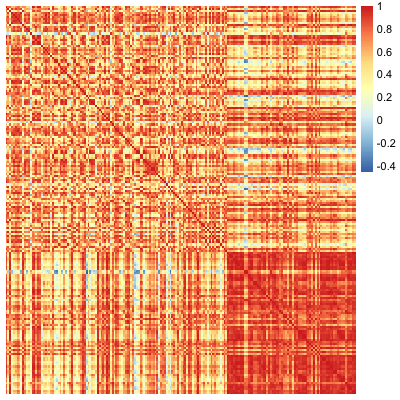

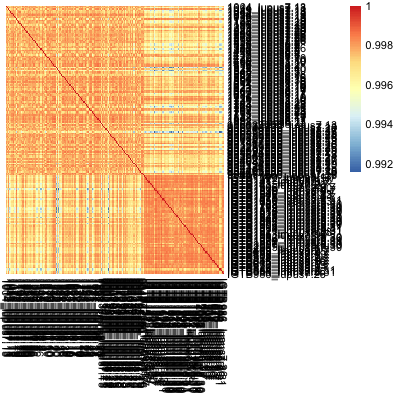

In [22]:
options(repr.plot.width = 5, repr.plot.height = 5)
pheatmap(cor(t(cbind(cm_prop, th_prop, b_prop, nk_prop, ncm_prop, tc_prop, dc_prop))),cluster_rows=F,cluster_cols=F)
options(repr.plot.width = 5, repr.plot.height = 5)
pheatmap(cor(cbind(pbmc_expr)),cluster_rows=F,cluster_cols=F)

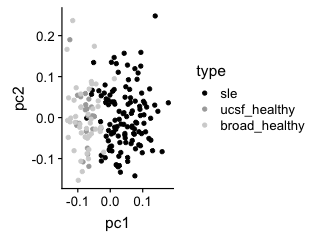

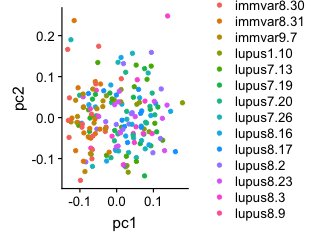

In [23]:
##pbmc_expr_prcomp <- prcomp(pbmc_expr)
pbmc_expr_prcomp <- prcomp(pbmc_expr_std)

df <- rbind(data.frame(pc1=pbmc_expr_prcomp$rotation[sle_indices,1], pc2=pbmc_expr_prcomp$rotation[sle_indices,2], type="sle"),
            data.frame(pc1=pbmc_expr_prcomp$rotation[ucsf_healthy_indices,1], pc2=pbmc_expr_prcomp$rotation[ucsf_healthy_indices,2], type="ucsf_healthy"),
            data.frame(pc1=pbmc_expr_prcomp$rotation[broad_healthy_indices,1], pc2=pbmc_expr_prcomp$rotation[broad_healthy_indices,2], type="broad_healthy")
           )
df$batch = joined_pivot$batch_cov[match(rownames(df),joined_ind_cov_batch)]

options(repr.plot.width = 4, repr.plot.height = 3)
ggplot(aes(pc1,pc2,color=type),data=df)+geom_point()+scale_colour_manual(values=c("black","darkgray","lightgray"))

ggplot(aes(pc1,pc2,color=batch),data=df)+geom_point()

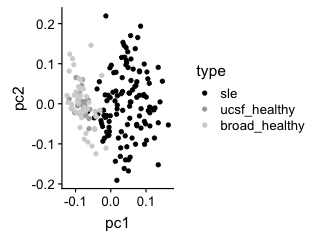

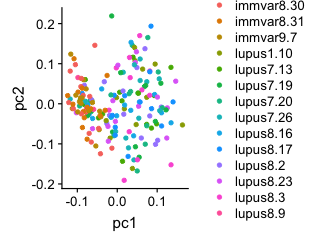

In [24]:
pbmc_expr_prcomp <- prcomp(pbmc_expr_std[na.omit(match(deseq_sig_genes,rownames(pbmc_expr_std))),])

df <- rbind(data.frame(pc1=pbmc_expr_prcomp$rotation[sle_indices,1], pc2=pbmc_expr_prcomp$rotation[sle_indices,2], type="sle"),
            data.frame(pc1=pbmc_expr_prcomp$rotation[ucsf_healthy_indices,1], pc2=pbmc_expr_prcomp$rotation[ucsf_healthy_indices,2], type="ucsf_healthy"),
            data.frame(pc1=pbmc_expr_prcomp$rotation[broad_healthy_indices,1], pc2=pbmc_expr_prcomp$rotation[broad_healthy_indices,2], type="broad_healthy")
           )
df$batch = joined_pivot$batch_cov[match(rownames(df),joined_ind_cov_batch)]

options(repr.plot.width = 4, repr.plot.height = 3)
ggplot(aes(pc1,pc2,color=type),data=df)+geom_point()+scale_colour_manual(values=c("black","darkgray","lightgray"))

ggplot(aes(pc1,pc2,color=batch),data=df)+geom_point()

# Figure 2A - heatmap

In [25]:
pbmc_col_clust <- hclust(dist(t(pbmc_expr_std[match(deseq_sig_genes,expr_gene_names),]),method = "euclidean"), method="ward.D")
pbmc_row_clust <- hclust(dist(pbmc_expr_std[match(deseq_sig_genes,expr_gene_names),],method = "euclidean"), method="ward.D")

all_expr <- data.frame(pbmc=pbmc_expr[,pbmc_col_clust$order],
                      cm=cm_expr[,pbmc_col_clust$order],
                      ncm=ncm_expr[,pbmc_col_clust$order],
                      dc=dc_expr[,pbmc_col_clust$order],
                      th=th_expr[,pbmc_col_clust$order],
                      tc=tc_expr[,pbmc_col_clust$order],
                       nk=nk_expr[,pbmc_col_clust$order],
                      b=b_expr[,pbmc_col_clust$order]
                      )
all_expr_sig <- all_expr[match(deseq_sig_genes,expr_gene_names),]

all_expr_std <- data.frame(pbmc=pbmc_expr_std[,pbmc_col_clust$order],
                      cm=cm_expr_std[,pbmc_col_clust$order],
                      ncm=ncm_expr_std[,pbmc_col_clust$order],
                      dc=dc_expr_std[,pbmc_col_clust$order],
                      th=th_expr_std[,pbmc_col_clust$order],
                      tc=tc_expr_std[,pbmc_col_clust$order],
                       nk=nk_expr_std[,pbmc_col_clust$order],
                      b=b_expr_std[,pbmc_col_clust$order]
                      )

all_expr_std_sig <- all_expr_std[match(deseq_sig_genes,expr_gene_names),]

ct_annotation_one <- data.frame(disease_pop_cov=joined_pivot$disease_pop_cov,
                           sledaiscore=joined_pivot$sledaiscore)
rownames(ct_annotation_one) <- colnames(pbmc_expr);

ct_annotation <- data.frame(type=factor(rep(cell_types,each=ncol(ncm_expr))),
#                            disease=factor(rep(c(rep("sle",ncol(cm_sle_expr)),
#                                                 rep("ctrl",ncol(cm_healthy_expr)))[pbmc_clust$order],
#                                               length(cell_types))),
                           disease_pop_cov=joined_pivot$disease_pop_cov[pbmc_col_clust$order],
                           sledaiscore=joined_pivot$sledaiscore[pbmc_col_clust$order])
rownames(ct_annotation) <- colnames(all_expr_std);


In [89]:
# options(repr.plot.width = 16, repr.plot.height = 16)

# breaksList = seq(-2, 2, by = .1)
# pheatmap_out <- pheatmap(pbmc_expr_std[match(deseq_sig_genes,expr_gene_names),pbmc_col_clust$order],
#          cluster_rows=T, cluster_cols=F,annotation_col = ct_annotation_one[pbmc_col_clust$order,],#annotation_row = kmeans_annotation,
#          color = colorRampPalette(rev(brewer.pal(n = 7, name = "RdYlBu")))(length(breaksList)), 
#                          cutree_rows=8, 
#                          scale="row",fontsize=5,clustering_method="ward.D",clustering_distance_row="manhattan",# Defines the vector of colors for the legend (it has to be of the same lenght of breaksList)
#         breaks = breaksList) # Sets the breaks of the color scale as in breaksList

In [28]:
ifn_crow <- read.table("ifn.lupus.crow.etal.txt")
crow_annotation <- matrix(nrow=nrow(all_expr_std_sig), ncol=1, 0);
crow_annotation[na.omit(match(ifn_crow$V1, rownames(all_expr_std_sig))),1] <- 1;
rownames(crow_annotation) <- rownames(all_expr_std_sig)
colnames(crow_annotation) <- "Crow"
crow_annotation <- as.data.frame(crow_annotation)

In [29]:
sum(crow_annotation$Crow)

[1] 25

In [30]:
pbmc_deseq_sig_annotation <- matrix(nrow=nrow(all_expr_std_sig), ncol=1, 0);
pbmc_deseq_sig_annotation[na.omit(match(pbmc_deseq_sig_genes, rownames(all_expr_std_sig))),1] <- 1;
rownames(pbmc_deseq_sig_annotation) <- rownames(all_expr_std_sig)
colnames(pbmc_deseq_sig_annotation) <- "PBMC Sig"
pbmc_deseq_sig_annotation <- as.data.frame(pbmc_deseq_sig_annotation)

In [31]:
dim(pbmc_deseq_sig_annotation)

[1] 209   1

In [32]:
row_annotations <- cbind(crow_annotation, pbmc_deseq_sig_annotation)

In [33]:
sum(row_annotations$Crow[row_annotations$"PBMC Sig"==1])

[1] 21

In [34]:
options(repr.plot.width = 16, repr.plot.height = 16)
breaksList = seq(-2, 2, by = .2)

pheatmap_std_out <- pheatmap(all_expr_std_sig,
         cluster_rows=T, cluster_cols=F, annotation_row = row_annotations, annotation_col = ct_annotation, #annotation_row = kmeans_annotation,
         color = colorRampPalette(rev(brewer.pal(n = 7, name = "RdYlBu")))(length(breaksList)), # Defines the vector of colors for the legend (it has to be of the same lenght of breaksList)
        breaks = breaksList, # Sets the breaks of the color scale as in breaksList
        gaps_col=seq(ncol(cm_expr),ncol(cm_expr)*length(cell_types),ncol(cm_expr)),
                         cutree_rows=8, 
                         scale="none",fontsize=2,clustering_method="ward.D",clustering_distance_row="manhattan", filename="expr_std_heatmap.png",
                            width=10, height=10, dpi=600)
options(repr.plot.width = 10, repr.plot.height = 4)



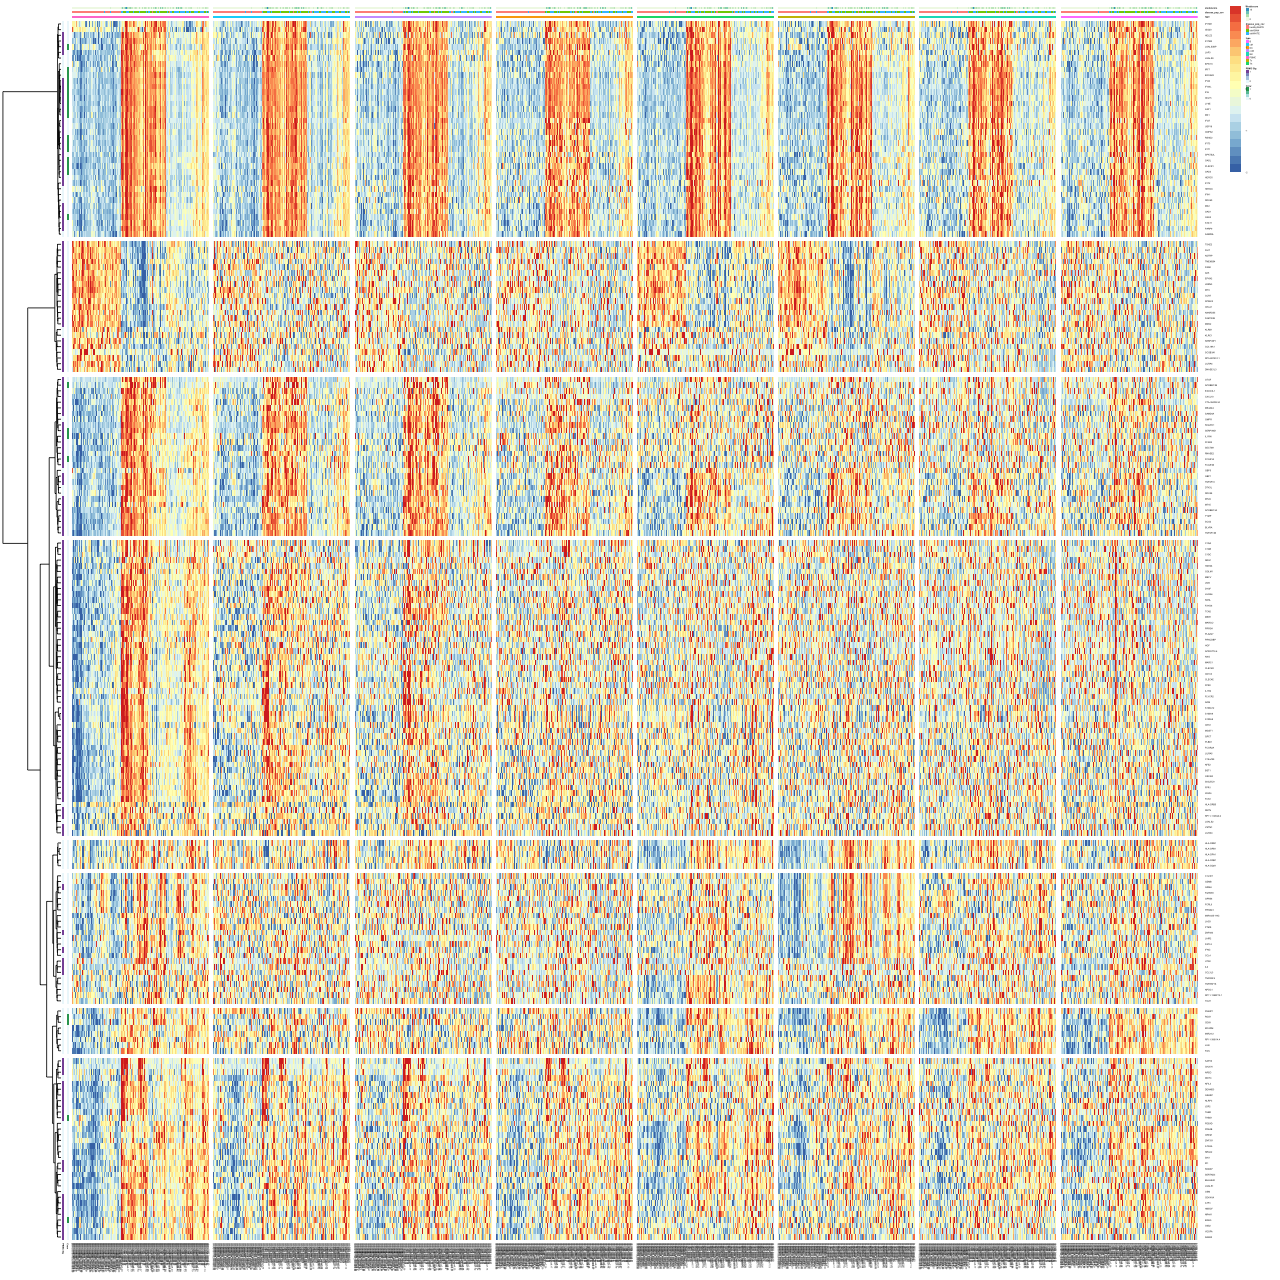

In [88]:
options(repr.plot.width = 16, repr.plot.height = 16)
breaksList = seq(-2, 2, by = .2)

pheatmap_std_out <- pheatmap(all_expr_std_sig,
         cluster_rows=T, cluster_cols=F, annotation_row = row_annotations, annotation_col = ct_annotation, #annotation_row = kmeans_annotation,
         color = colorRampPalette(rev(brewer.pal(n = 7, name = "RdYlBu")))(length(breaksList)), # Defines the vector of colors for the legend (it has to be of the same lenght of breaksList)
        breaks = breaksList, # Sets the breaks of the color scale as in breaksList
        gaps_col=seq(ncol(cm_expr),ncol(cm_expr)*length(cell_types),ncol(cm_expr)),
                         cutree_rows=8, 
                         scale="none",fontsize=2,clustering_method="ward.D",clustering_distance_row="manhattan",
                            width=10, height=10, dpi=600)
options(repr.plot.width = 10, repr.plot.height = 4)



In [35]:
# options(repr.plot.width = 16, repr.plot.height = 16)
# breaksList = seq(-2.8, 2.8, by = .2)

# pheatmap_out <- pheatmap(all_expr_sig,
#          cluster_rows=T, cluster_cols=F, annotation_col = ct_annotation, #annotation_row = kmeans_annotation,
#          color = colorRampPalette(rev(brewer.pal(n = 7, name = "RdYlBu")))(length(breaksList)), # Defines the vector of colors for the legend (it has to be of the same lenght of breaksList)
#         breaks = breaksList, # Sets the breaks of the color scale as in breaksList
#         gaps_col=seq(ncol(cm_expr),ncol(cm_expr)*length(cell_types),ncol(cm_expr)),
#                          cutree_rows=10, 
#                          scale="row",fontsize=5,clustering_method="complete",clustering_distance_row="manhattan")
# options(repr.plot.width = 10, repr.plot.height = 4)

## make some volcano plots

In [36]:
options(repr.plot.width = 4, repr.plot.height = 4)
pbmc_deseq$ifn=pbmc_deseq$V1 %in% ifn_crow$V1
pbmc_deseq$sig=rep("cnot significant",nrow(pbmc_deseq))
pbmc_deseq$sig[match(deseq_sig_genes, pbmc_deseq$V1)]="bct_sig";
pbmc_deseq$sig[match(pbmc_deseq_sig_genes, pbmc_deseq$V1)]="apbmc_sig";

pbmc_deseq <- pbmc_deseq[order(pbmc_deseq$sig,decreasing=T),]
# !(abs(pbmc_deseq$log2FoldChange)>1) & (which(pbmc_deseq$qval < 0.01))

lim=max(abs(pbmc_deseq$log2FoldChange)) + 0.2
min_lim=-lim

##pdf(paste(ct, '.volcano.pdf', sep=''), useDingbats=F)
g = ggplot(pbmc_deseq, aes(x=log2FoldChange, y=-log10(pvalue), color=sig))+ theme_linedraw()+theme(legend.position="none") + xlim(-4.5, 4.5) + geom_point()+geom_point(data=pbmc_deseq[pbmc_deseq$ifn,],
             pch=21, fill=NA, size=4, colour="black", stroke=1)+scale_color_grey()+scale_fill_grey()
ggsave(g, filename="pbmc_deseq.png", width=3, height=3, dpi=300)
##dev.off()


Warning message:
“Removed 2 rows containing missing values (geom_point).”

## More principled way to cut the tree and label the specific signatures

In [37]:
# this works only pbmc_sig genes

# cuttree_out <- cutree(pheatmap_std_out$tree_row, k = 8)
# cuttree_out <- cuttree_out[pheatmap_std_out$tree_row$order];
# cuttree_out[which(cuttree_out==7)] <- "pan";
# cuttree_out[which(cuttree_out==1)] <- "lymph";
# cuttree_out[which(cuttree_out==5)] <- "b";
# cuttree_out[which(cuttree_out==8)] <- "tc";
# cuttree_out[which(cuttree_out==2)] <- "myeloid";
# cuttree_out[which(cuttree_out==6)] <- "myeloid";
# cuttree_out[which(cuttree_out==3)] <- "monocytes";
# cuttree_out[which(cuttree_out==4)] <- "monocytes";

# cuttree_gene_names <- names(cuttree_out);
# cuttree_out <- cbind(cuttree_gene_names,cuttree_out)
# colnames(cuttree_out) <- c("gene","cluster")
# cuttree_out <- as.data.frame(cuttree_out);
# cuttree_out[,"cluster"] <- factor(cuttree_out[,"cluster"], levels=unique(as.character(cuttree_out[,"cluster"])))
# write.table(cuttree_out, file="diffexp.annotations.txt",sep="\t",col.names=T,row.names=F,quote=F);

In [38]:
cuttree_out <- cutree(pheatmap_std_out$tree_row, k = 8)
cuttree_out <- cuttree_out[pheatmap_std_out$tree_row$order];
cuttree_out[which(cuttree_out==7)] <- "T1";
cuttree_out[which(cuttree_out==1)] <- "Down";
cuttree_out[which(cuttree_out==5)] <- "Pan2";
cuttree_out[which(cuttree_out==8)] <- "T2";
cuttree_out[which(cuttree_out==2)] <- "Myeloid1";
cuttree_out[which(cuttree_out==6)] <- "Pan1";
cuttree_out[which(cuttree_out==3)] <- "Myeloid2";
cuttree_out[which(cuttree_out==4)] <- "M";

cuttree_gene_names <- names(cuttree_out);
cuttree_out <- cbind(cuttree_gene_names,cuttree_out)
colnames(cuttree_out) <- c("gene","cluster")
cuttree_out <- as.data.frame(cuttree_out);
cuttree_out[,"cluster"] <- factor(cuttree_out[,"cluster"], levels=unique(as.character(cuttree_out[,"cluster"])))
write.table(cuttree_out, file="diffexp.annotations.txt",sep="\t",col.names=T,row.names=F,quote=F);

In [39]:
write.table(as.character(cuttree_out$gene[cuttree_out$cluster=="Pan1"]), file="Pan1.txt", row.names=F, col.names=F, quote=F, sep=",")
write.table(as.character(cuttree_out$gene[cuttree_out$cluster=="Pan2"]), file="Pan2.txt", row.names=F, col.names=F, quote=F, sep=",")
write.table(as.character(cuttree_out$gene[cuttree_out$cluster=="Myeloid1"]), file="Myeloid1.txt", row.names=F, col.names=F, quote=F, sep=",")
write.table(as.character(cuttree_out$gene[cuttree_out$cluster=="Myeloid2"]), file="Myeloid2.txt", row.names=F, col.names=F, quote=F, sep=",")
write.table(as.character(cuttree_out$gene[cuttree_out$cluster=="M"]), file="Monocyte.txt", row.names=F, col.names=F, quote=F, sep=",")

write.table(as.character(cuttree_out$gene), file="All.txt", row.names=F, col.names=F, quote=F, sep=",")



# Figure 2B - correlogram to show coexpressed genes

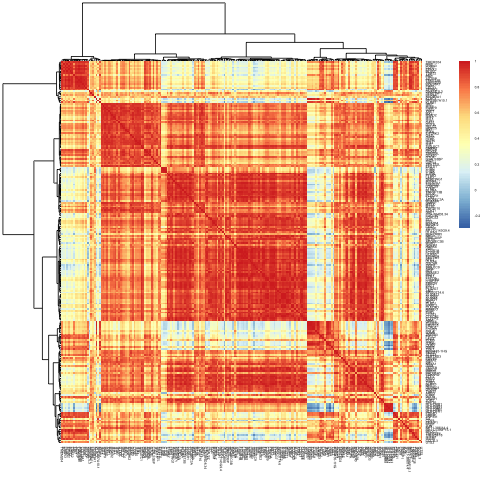

In [40]:
no_pbmc_cor <- cor(t(all_expr_sig[,-c(1,ncol(pbmc_expr))]))
options(repr.plot.width = 6, repr.plot.height = 6)
pheatmap(no_pbmc_cor,
         cluster_rows=pheatmap_out$tree_row, cluster_cols=pheatmap_out$tree_row, #annotation_row = kmeans_annotation,
         fontsize=3)
options(repr.plot.width = 4, repr.plot.height = 4)

# Figure 2C: Proportion of variance explained


First, we are going to estimate proportion of variance explained by cell type proportion

This will be a multiple regression

\begin{equation*}
e_i = -1 + b_1\times p_1 + b_2\times p_2 + ... + b_n\times p_n
\end{equation*}

Next, we are going to estimate proportion of variance explained by cell type specific expression

This will be a multiple regression


\begin{equation*}
e_i = -1 + b_1\times e_1 + b_2\times e_2 + ... + b_n\times e_n
\end{equation*}

calculate adjusted r_2 and also the cell type specific r2

Y_i = %mono*mono_i + %other*other_i + err
Or
Y_i = %mono*mono_i
log(Y_i) = log(%mono)+log(mono_i)+err


## Let's define some useful functions

## Processing all - now, let's fit with -1 but we need to standardize the outcome

In [41]:
output_prop_noint <- model_prop(pbmc_expr_std, props);
output_expr_noint <- model_expr(pbmc_expr_std, exprs_std);

## Processing SLE

In [42]:
output_sle_prop_noint <- model_prop(pbmc_sle_expr_std, props_sle);
output_sle_expr_noint <- model_expr(pbmc_sle_expr_std, exprs_sle_std);

In [43]:
# output_sle_prop_noint_small <- model_prop(pbmc_sle_expr_std[1:100,], props_sle);
# output_sle_expr_noint_small <- model_expr(pbmc_sle_expr_std[1:100,], exprs_sle_std);

### Downsampled SLE to 46 samples

In [44]:
## including dc analysis
##N <- 22;
samples_asian <- which(joined_pivot$disease_pop=="sleASIAN")
samples_white <- which(joined_pivot$disease_pop=="sleWHITE")

## including dc analysis
output_sle_asian_prop_noint <- model_prop(pbmc_sle_expr_std[,samples_asian], props_sle[samples_asian,]);
output_sle_asian_expr_noint <- model_expr(pbmc_sle_expr_std[,samples_asian], exprs_sle_std[,samples_asian,]);

output_sle_white_prop_noint <- model_prop(pbmc_sle_expr_std[,samples_white], props_sle[samples_white,]);
output_sle_white_expr_noint <- model_expr(pbmc_sle_expr_std[,samples_white], exprs_sle_std[,samples_white,]);

# samples <- sample(1:ncol(pbmc_sle_expr_std), N)
# output_sle_down_prop_noint <- model_prop(pbmc_sle_expr_std[,samples], props_sle[samples,]);
# output_sle_down_expr_noint <- model_expr(pbmc_sle_expr_std[,samples], exprs_sle_std[,samples,]);


[1] 0.9903
[1] 0.9964587
     prop      expr    factor 
0.6707848 0.8934150 0.9541935 
[1] 0.9973447
[1] 0.9996776


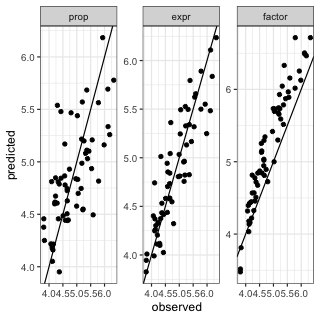

     prop      expr    factor 
0.2832303 0.9678494 0.9749954 
[1] 0.9992684
[1] 0.9996723


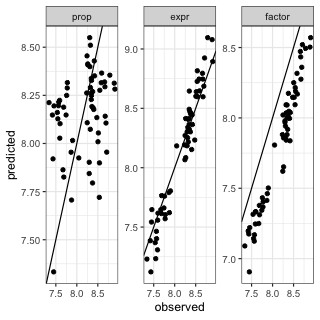

     prop      expr    factor 
0.4449510 0.4035732 0.8808940 
[1] 0.9782682
[1] 0.9988752


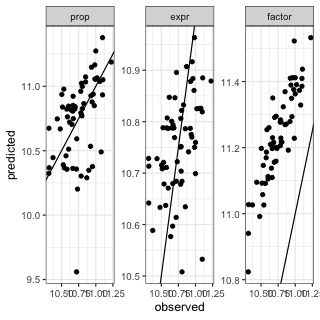

     prop      expr    factor 
0.2115371 0.9804460 0.9806410 


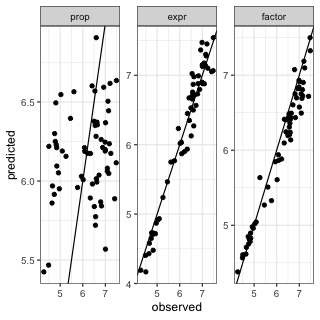

In [45]:
test_single_gene(pbmc_sle_expr[,samples_asian], props_sle[samples_asian,], exprs_sle[,samples_asian,], grep("^IL6$",expr_gene_names)[1])
test_single_gene(pbmc_sle_expr[,samples_asian], props_sle[samples_asian,], exprs_sle[,samples_asian,], grep("^ERAP2$",expr_gene_names)[1])
test_single_gene(pbmc_sle_expr[,samples_asian], props_sle[samples_asian,], exprs_sle[,samples_asian,], grep("^CD3E$",expr_gene_names)[1])
test_single_gene(pbmc_sle_expr[,samples_asian], props_sle[samples_asian,], exprs_sle[,samples_asian,], grep("^UTS2$",expr_gene_names)[1])


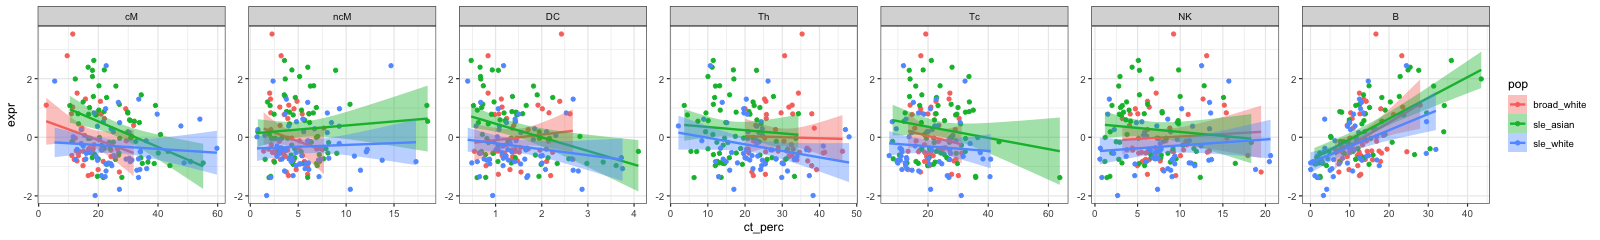

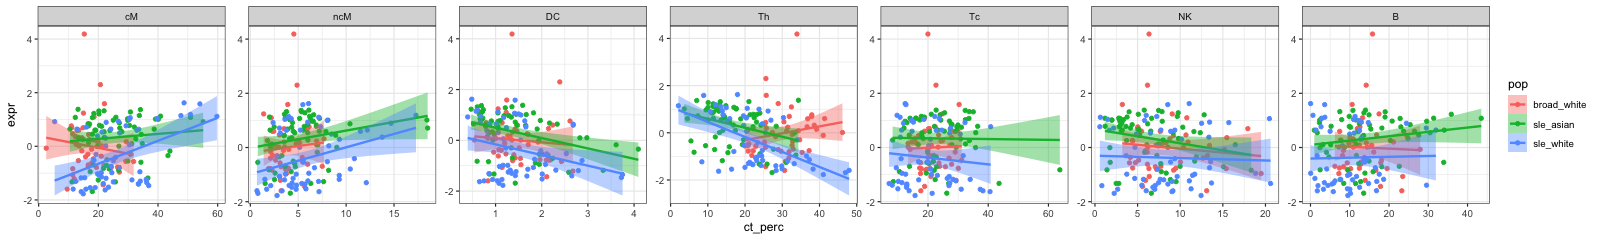

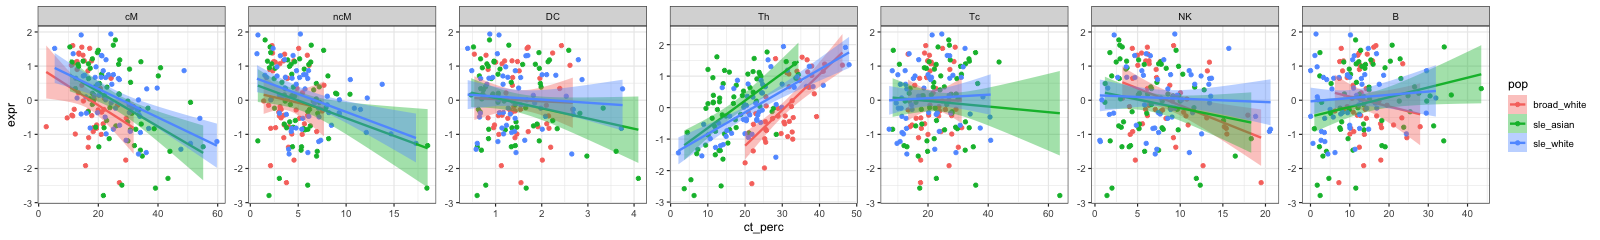

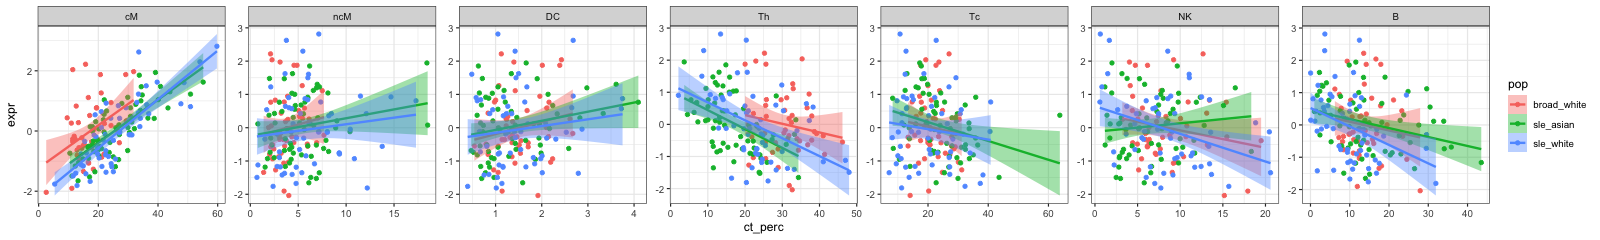

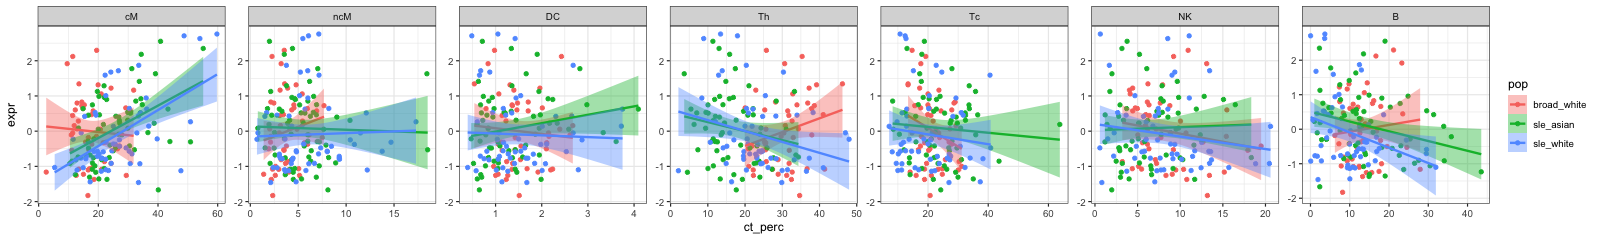

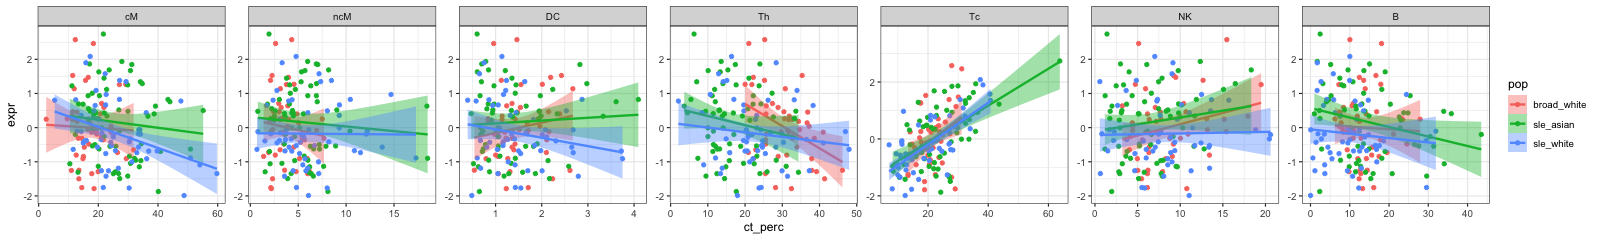

In [46]:
source("helper_functions.R")
options(repr.plot.width = 20, repr.plot.height = 3)
props_all = rbind(data.frame(props_broad_healthy,pop="broad_white"),
                  data.frame(props_sle[samples_asian,],pop="sle_asian"),
                  data.frame(props_sle[samples_white,],pop="sle_white"))

expr_all = cbind(pbmc_broad_healthy_expr_std, pbmc_sle_expr_std[,c(samples_asian,samples_white)])

il6 <- plot_single_gene(expr_all, props_all, NULL, grep("^IL6$",expr_gene_names)[1])
ggsave(il6, file="IL6.png",width=11, height=2)
ifi44l <- plot_single_gene(expr_all, props_all, NULL, grep("^IFI44L$",expr_gene_names)[1])
ggsave(ifi44l, file="IFI44L.png",width=11, height=2)
ccr7 <- plot_single_gene(expr_all, props_all, NULL, grep("^CCR7$",expr_gene_names)[1])
ggsave(ccr7, file="CCR7.png",width=11, height=2)
nlrp3 <- plot_single_gene(expr_all, props_all, NULL, grep("^NLRP3$",expr_gene_names)[1])
ggsave(nlrp3, file="NLRP3.png", width=11, height=2)
thbs1 <- plot_single_gene(expr_all, props_all, NULL, grep("^THBS1$",expr_gene_names)[1])
ggsave(thbs1, file="THBS1.png", width=11, height=2)
ifng <- plot_single_gene(expr_all, props_all, NULL, grep("^IFNG$",expr_gene_names)[1])
ggsave(ifng, file="IFNG.png",width=11, height=2)


In [47]:
head(props_all)

cM        Th       B        NK        ncM      Tc      
IGTB1372_immvar9.7 12.591850 31.19572 15.59786 13.426854 2.605210 21.10888
IGTB141_immvar9.7  20.969661 32.80785 13.71208  4.134444 5.413444 19.98810
IGTB143_immvar9.7  13.469500 41.37455 12.39304  5.465084 2.318521 18.85178
IGTB1506_immvar9.7 13.318284 32.63463 12.89906 10.029023 5.449855 21.70268
IGTB1539_immvar9.7  2.543507 32.66399 27.93396 15.171798 4.016064 14.05622
IGTB1540_immvar9.7 11.411765 30.44118 16.85294 10.676471 3.029412 23.52941
                   DC       pop        
IGTB1372_immvar9.7 1.002004 broad_white
IGTB141_immvar9.7  1.070791 broad_white
IGTB143_immvar9.7  2.235716 broad_white
IGTB1506_immvar9.7 1.225411 broad_white
IGTB1539_immvar9.7 1.918786 broad_white
IGTB1540_immvar9.7 2.147059 broad_white

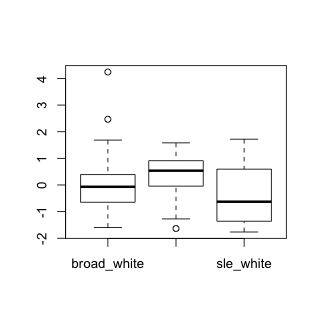

In [48]:
options(repr.plot.width = 4, repr.plot.height = 4)
plot(props_all$pop, expr_all[grep("^IFI6$",expr_gene_names),])

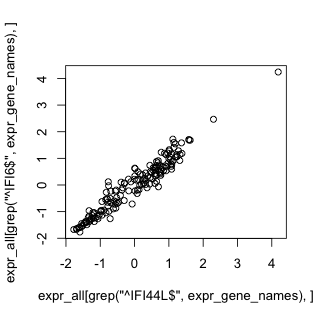

In [49]:
plot(expr_all[grep("^IFI44L$",expr_gene_names),], expr_all[grep("^IFI6$",expr_gene_names),])

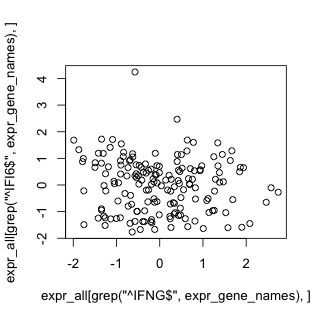

In [50]:
plot(expr_all[grep("^IFNG$",expr_gene_names),], expr_all[grep("^IFI6$",expr_gene_names),])

In [51]:
cor(expr_all[grep("^IL6$",expr_gene_names),], expr_all[grep("^IFI6$",expr_gene_names),])

[1] 0.2269291

[1] 0.5271019
[1] 0.7958493
     prop      expr    factor 
0.7020577 0.8939482 0.5247438 
[1] 0.385498
[1] 0.7480914


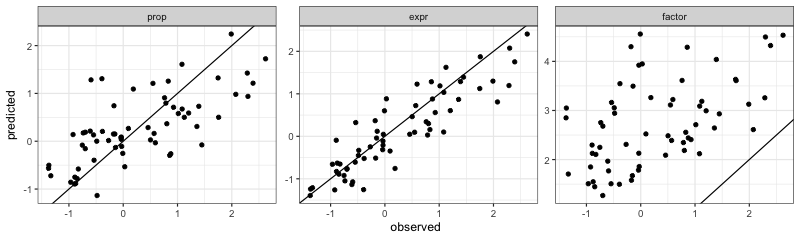

     prop      expr    factor 
0.5522777 0.8662784 0.5446731 
[1] 0.1920263
[1] 0.9194864


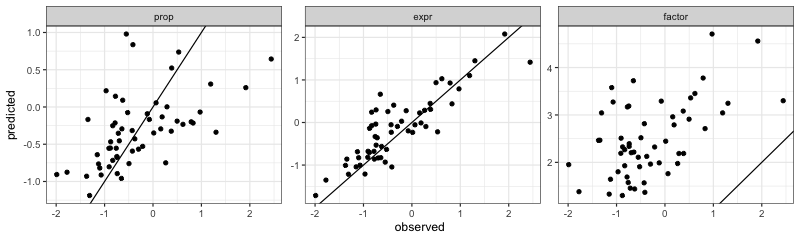

     prop      expr    factor 
0.4382093 0.9588986 0.7550681 
[1] 0.06868509
[1] 0.9854103


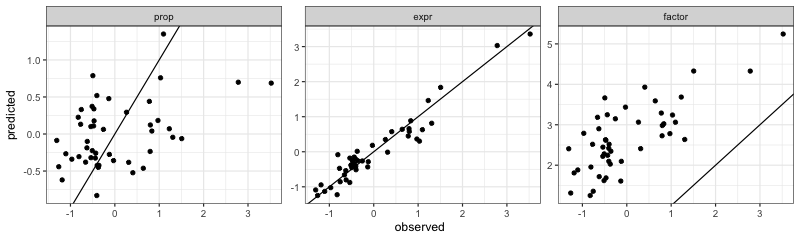

     prop      expr    factor 
0.2472679 0.9926280 0.9888209 
[1] 0.1000418
[1] 0.9869049


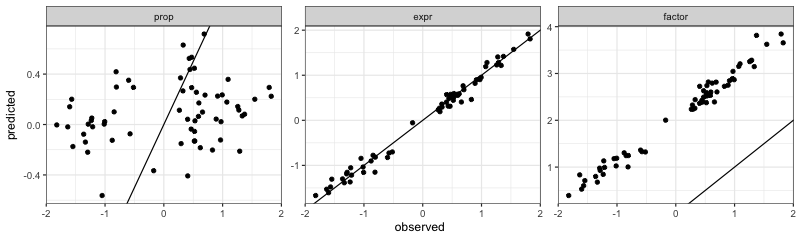

     prop      expr    factor 
0.3011185 0.9933629 0.9909785 
[1] 0.09195795
[1] 0.9908415


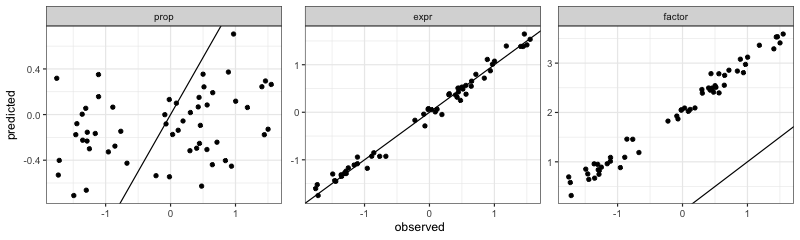

     prop      expr    factor 
0.3032486 0.9954102 0.9942539 
[1] 0.7965992
[1] 0.1620833


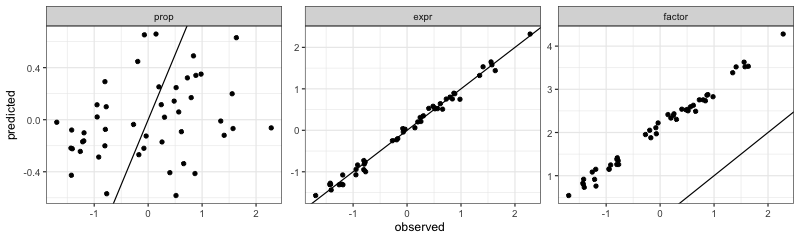

      prop       expr     factor 
0.89245902 0.40745995 0.08433076 
[1] 0.889194
[1] 0.3425827


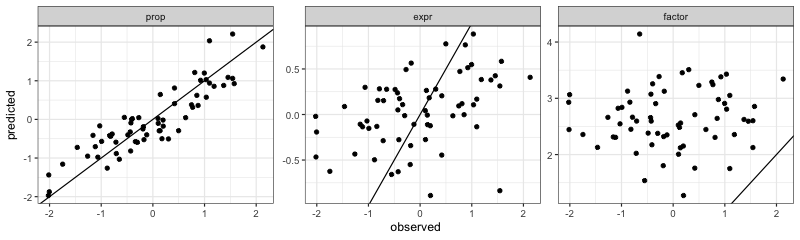

     prop      expr    factor 
0.9429331 0.5972842 0.2562528 
[1] 0.833192
[1] 0.5066121


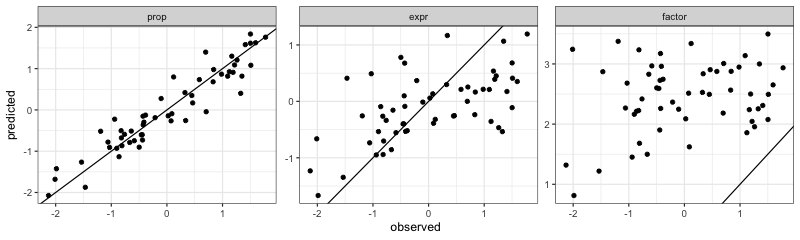

     prop      expr    factor 
0.9127937 0.7117669 0.3615825 


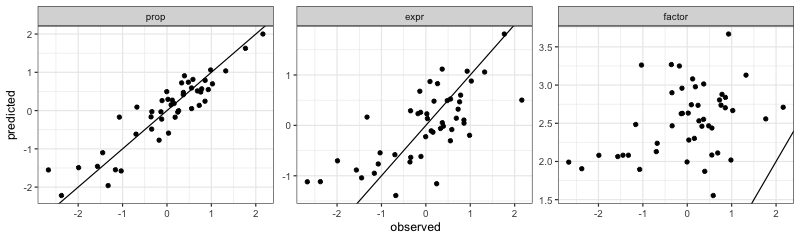

In [52]:
options(repr.plot.width = 10, repr.plot.height = 3)
test_single_gene(pbmc_sle_expr_std[,samples_asian], props_sle[samples_asian,], exprs_sle_std[,samples_asian,], grep("^IL6$",expr_gene_names)[1])
test_single_gene(pbmc_sle_expr_std[,samples_white], props_sle[samples_white,], exprs_sle_std[,samples_white,], grep("^IL6$",expr_gene_names)[1])
test_single_gene(pbmc_broad_healthy_expr_std, props_broad_healthy, exprs_broad_healthy_std, grep("^IL6$",expr_gene_names)[1])


test_single_gene(pbmc_sle_expr_std[,samples_asian], props_sle[samples_asian,], exprs_sle_std[,samples_asian,], grep("^ERAP2$",expr_gene_names)[1])
test_single_gene(pbmc_sle_expr_std[,samples_white], props_sle[samples_white,], exprs_sle_std[,samples_white,], grep("^ERAP2$",expr_gene_names)[1])
test_single_gene(pbmc_broad_healthy_expr_std, props_broad_healthy, exprs_broad_healthy_std, grep("^ERAP2$",expr_gene_names)[1])

test_single_gene(pbmc_sle_expr_std[,samples_asian], props_sle[samples_asian,], exprs_sle_std[,samples_asian,], grep("^CD3E$",expr_gene_names)[1])
test_single_gene(pbmc_sle_expr_std[,samples_white], props_sle[samples_white,], exprs_sle_std[,samples_white,], grep("^CD3E$",expr_gene_names)[1])
test_single_gene(pbmc_broad_healthy_expr_std, props_broad_healthy, exprs_broad_healthy_std, grep("^CD3E$",expr_gene_names)[1])

# test_single_gene(pbmc_sle_expr_std, props_sle, exprs_sle, grep("^IL6$",expr_gene_names)[1])
# test_single_gene(pbmc_sle_expr, props_sle, exprs_sle, grep("^IL6$",expr_gene_names)[1])

## Processing UCSF healthy

In [53]:
output_ucsf_healthy_prop_noint <- model_prop(pbmc_ucsf_healthy_expr_std, props_ucsf_healthy);
output_ucsf_healthy_expr_noint <- model_expr(pbmc_ucsf_healthy_expr_std, exprs_ucsf_healthy_std);

In [54]:
# options(repr.plot.width = 10, repr.plot.height = 3)
# t(which(output_ucsf_healthy_expr_noint[,8]>1000))
# test_single_gene(pbmc_ucsf_healthy_expr_std, props_ucsf_healthy, exprs_ucsf_healthy_std, grep("^RALBP1$",expr_gene_names)[1])
# test_single_gene(pbmc_ucsf_healthy_expr_std, props_ucsf_healthy, exprs_ucsf_healthy, grep("^RALBP1$",expr_gene_names)[1])
# test_single_gene(pbmc_ucsf_healthy_expr, props_ucsf_healthy, exprs_ucsf_healthy, grep("^RALBP1$",expr_gene_names)[1])

In [55]:
# test_single_gene(pbmc_ucsf_healthy_expr_std, props_ucsf_healthy, exprs_ucsf_healthy_std, grep("^IL6$",expr_gene_names)[1])
# test_single_gene(pbmc_ucsf_healthy_expr_std, props_ucsf_healthy, exprs_ucsf_healthy, grep("^IL6$",expr_gene_names)[1])
# test_single_gene(pbmc_ucsf_healthy_expr, props_ucsf_healthy, exprs_ucsf_healthy, grep("^IL6$",expr_gene_names)[1])

## Processing Broad healthy

In [56]:
output_broad_healthy_prop_noint <- model_prop(pbmc_broad_healthy_expr_std, props_broad_healthy);
output_broad_healthy_expr_noint <- model_expr(pbmc_broad_healthy_expr_std, exprs_broad_healthy_std);


In [57]:
# options(repr.plot.width = 10, repr.plot.height = 3)
# t(which(output_broad_healthy_expr_noint[,8]>1000))
# test_single_gene(pbmc_broad_healthy_expr_std, props_broad_healthy, exprs_broad_healthy_std, grep("^RALBP1$",expr_gene_names)[1])
# test_single_gene(pbmc_broad_healthy_expr_std, props_broad_healthy, exprs_broad_healthy, grep("^RALBP1$",expr_gene_names)[1])
# test_single_gene(pbmc_broad_healthy_expr, props_broad_healthy, exprs_broad_healthy, grep("^RALBP1$",expr_gene_names)[1])

In [58]:
# test_single_gene(pbmc_broad_healthy_expr_std, props_broad_healthy, exprs_broad_healthy_std, grep("^IL6$",expr_gene_names)[1])
# test_single_gene(pbmc_broad_healthy_expr_std, props_broad_healthy, exprs_broad_healthy, grep("^IL6$",expr_gene_names)[1])
# test_single_gene(pbmc_broad_healthy_expr, props_broad_healthy, exprs_broad_healthy, grep("^IL6$",expr_gene_names)[1])

## matching ucsf and broad

In [59]:
a <- match(sapply(rownames(props_ucsf_healthy),function(x){strsplit(x,"_")[[1]][[1]]}), sapply(rownames(props_broad_healthy), function(x) {strsplit(x,"_")[[1]][[1]]}))
props_ucsf_healthy_matched <- props_ucsf_healthy[!is.na(a),]
props_broad_healthy_matched <- props_broad_healthy[na.omit(a),]
pbmc_ucsf_healthy_expr_std_matched <- pbmc_ucsf_healthy_expr_std[,!is.na(a)]
pbmc_broad_healthy_expr_std_matched <- pbmc_broad_healthy_expr_std[,na.omit(a)]
exprs_ucsf_healthy_std_matched <- exprs_ucsf_healthy_std[,!is.na(a),]
exprs_broad_healthy_std_matched <- exprs_broad_healthy_std[,na.omit(a),]


output_ucsf_healthy_prop_noint_matched <- model_prop(pbmc_ucsf_healthy_expr_std_matched, props_ucsf_healthy_matched);
output_ucsf_healthy_expr_noint_matched <- model_expr(pbmc_ucsf_healthy_expr_std_matched, exprs_ucsf_healthy_std_matched);

output_broad_healthy_prop_noint_matched <- model_prop(pbmc_broad_healthy_expr_std_matched, props_broad_healthy_matched);
output_broad_healthy_expr_noint_matched <- model_expr(pbmc_broad_healthy_expr_std_matched, exprs_broad_healthy_std_matched);


## Summarize and plotting results

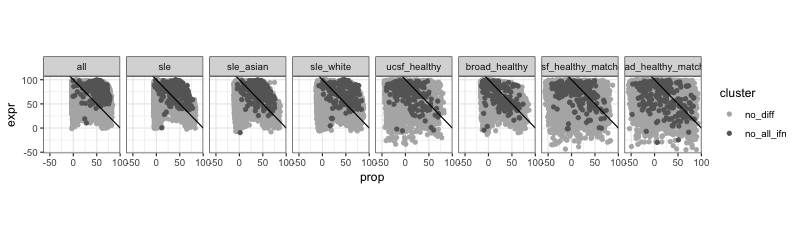

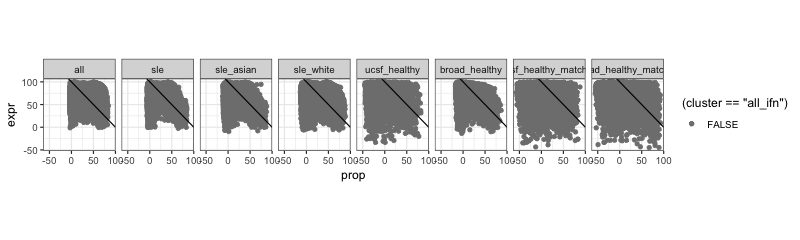

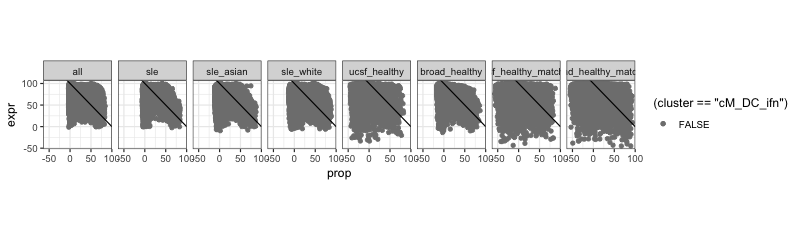

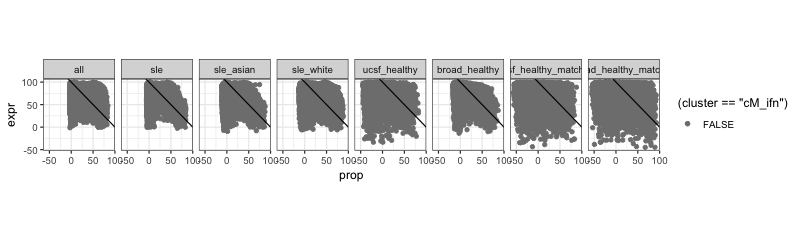

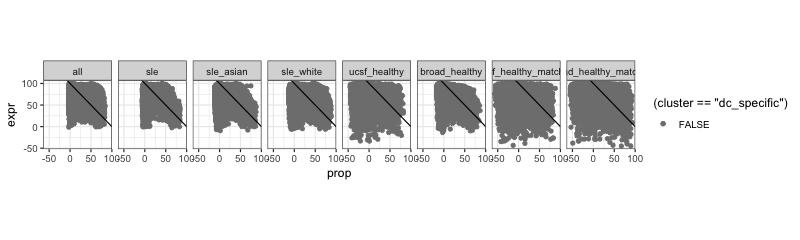

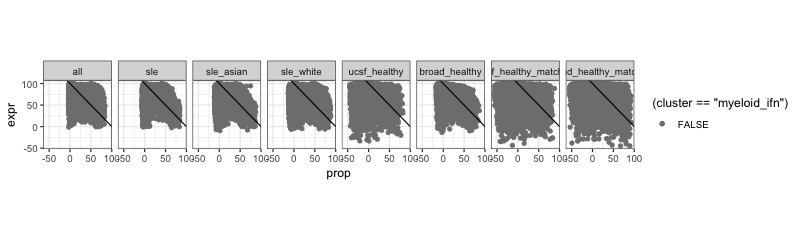

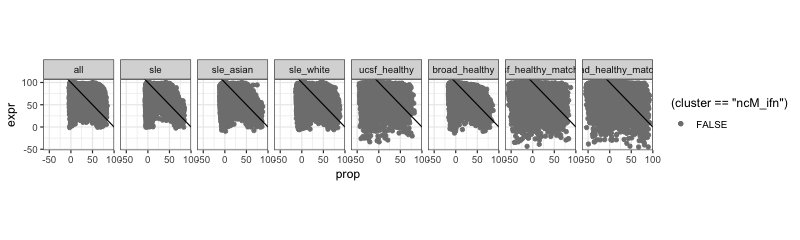

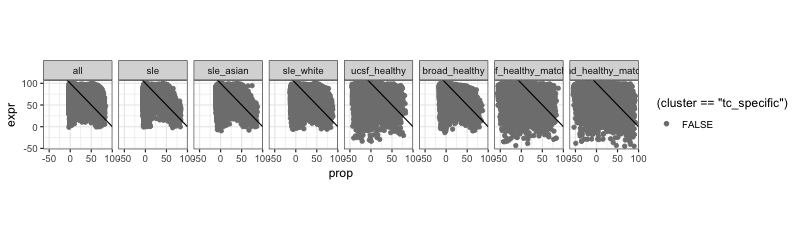

cor        prop_mean expr_mean sum_mean
all                   -0.2145408 19.819245 70.48190  90.30115
sle                   -0.3708853 16.610865 69.26207  85.87294
sle_asian             -0.3540908 16.455408 69.28267  85.73807
sle_white             -0.3334076 17.501389 69.34475  86.84614
ucsf_healthy          -0.1207716 -2.488743 80.27671  77.78796
broad_healthy         -0.4042753  8.641246 79.02534  87.66658
ucsf_healthy_matched  -0.1238557 -2.315174 80.01272  77.69754
broad_healthy_matched -0.2308887  4.948953 79.56794  84.51689

cM       Th       B         NK        ncM      
all_prop                   26.81529 26.34740 11.354697  7.464059 12.085991
all_expr                   26.08577 25.21697 10.393157  5.974847  6.513413
sle_prop                   22.94724 18.63221 15.599450  8.815783 11.932465
sle_expr                   30.96859 21.49472  9.633483  5.525855  7.872601
sle_asian_prop             20.16138 17.13428 16.491130  9.431554 13.269741
sle_asian_expr             30.45711 18.77667 11.586960  4.916295  7.477012
sle_white_prop             23.30069 16.35896 13.341961 11.553175 12.170187
sle_white_expr             29.89758 24.45549  7.850957  6.889114  8.749360
ucsf_healthy_prop          15.51453 12.07031 15.859433  9.440844 18.172709
ucsf_healthy_expr          16.87232 33.90492 11.981778  7.001993  5.453631
broad_healthy_prop         19.24040 13.24485 14.859613 14.898978 13.551920
broad_healthy_expr         19.46803 27.56571 13.220040  7.878358  5.901806
ucsf_healthy_matched_prop  15.61338 12.52475 15.893964  9.039025 17.731761
ucsf_healthy_matched_expr  16.46674 34.24825 11.901414  7.218294  5.539441
broad_healthy_matched_prop 16.56192 11.78940 14.761664 16.091523 14.920243
broad_healthy_matched_expr 15.48655 30.21558 14.071180  9.131516  6.511803
                           Tc        DC        total.r2   adj.r2   
all_prop                    7.977421  7.955148 19.8024590 19.819245
all_expr                   22.824443  2.991394 70.4757979 70.481904
sle_prop                   11.000655 11.072190 16.5661649 16.610865
sle_expr                   21.694641  2.810115 69.2457856 69.262075
sle_asian_prop             11.179541 12.332374 14.7601932 16.455408
sle_asian_expr             23.393316  3.392635 68.9220514 69.282666
sle_white_prop             11.360680 11.914348 15.5039113 17.501389
sle_white_expr             19.115017  3.042484 69.0458741 69.344751
ucsf_healthy_prop          13.806922 15.135248 -4.8191270 -2.488743
ucsf_healthy_expr          20.204783  4.580573 79.8284513 80.276708
broad_healthy_prop         10.984834 13.219402  8.2922791  8.641246
broad_healthy_expr         22.041341  3.924715 78.9452368 79.025336
ucsf_healthy_matched_prop  13.491841 15.705278 -6.6498539 -2.315174
ucsf_healthy_matched_expr  20.062033  4.563834 79.3268928 80.012716
broad_healthy_matched_prop 10.689289 15.185960  0.3347942  4.948953
broad_healthy_matched_expr 19.759077  4.824288 78.5055712 79.567939

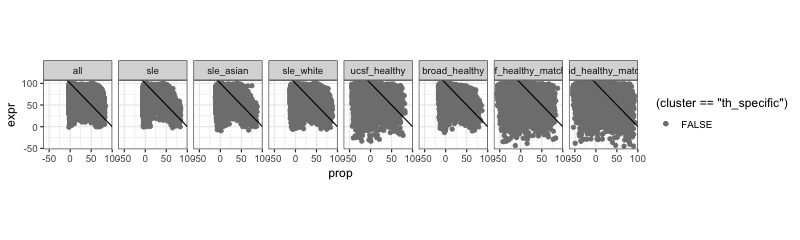

In [60]:
output_noint_df <- data.frame(prop=output_prop_noint[,"adj r2"], expr=output_expr_noint[,"adj r2"], type="all")
output_noint_df$cluster <- "no_diff";
output_noint_df$cluster[match(cuttree_out[,"gene"],rownames(output_noint_df))] <- cuttree_out[,"cluster"];

output_sle_noint_df <- data.frame(prop=output_sle_prop_noint[,"adj r2"], expr=output_sle_expr_noint[,"adj r2"], type="sle")
output_sle_noint_df$cluster <- "no_diff";
output_sle_noint_df$cluster[match(cuttree_out[,"gene"],rownames(output_sle_noint_df))] <- cuttree_out[,"cluster"];

# output_sle_down_noint_df <- data.frame(prop=output_sle_down_prop_noint[,"adj r2"], expr=output_sle_down_expr_noint[,"adj r2"], type="sle_down")
# output_sle_down_noint_df$cluster <- "no_diff";
# output_sle_down_noint_df$cluster[match(cuttree_out[,"gene"],rownames(output_sle_down_noint_df))] <- cuttree_out[,"cluster"];

output_sle_asian_noint_df <- data.frame(prop=output_sle_asian_prop_noint[,"adj r2"], expr=output_sle_asian_expr_noint[,"adj r2"], type="sle_asian")
output_sle_asian_noint_df$cluster <- "no_diff";
output_sle_asian_noint_df$cluster[match(cuttree_out[,"gene"],rownames(output_sle_asian_noint_df))] <- cuttree_out[,"cluster"];

output_sle_white_noint_df <- data.frame(prop=output_sle_white_prop_noint[,"adj r2"], expr=output_sle_white_expr_noint[,"adj r2"], type="sle_white")
output_sle_white_noint_df$cluster <- "no_diff";
output_sle_white_noint_df$cluster[match(cuttree_out[,"gene"],rownames(output_sle_white_noint_df))] <- cuttree_out[,"cluster"];

output_ucsf_healthy_noint_df <- data.frame(prop=output_ucsf_healthy_prop_noint[,"adj r2"], expr=output_ucsf_healthy_expr_noint[,"adj r2"], type="ucsf_healthy")
output_ucsf_healthy_noint_df$cluster <- "no_diff";
output_ucsf_healthy_noint_df$cluster[match(cuttree_out[,"gene"],rownames(output_ucsf_healthy_noint_df))] <- cuttree_out[,"cluster"];

output_broad_healthy_noint_df <- data.frame(prop=output_broad_healthy_prop_noint[,"adj r2"], expr=output_broad_healthy_expr_noint[,"adj r2"], type="broad_healthy")
output_broad_healthy_noint_df$cluster <- "no_diff";
output_broad_healthy_noint_df$cluster[match(cuttree_out[,"gene"],rownames(output_broad_healthy_noint_df))] <- cuttree_out[,"cluster"];

output_ucsf_healthy_noint_matched_df <- data.frame(prop=output_ucsf_healthy_prop_noint_matched[,"adj r2"], expr=output_ucsf_healthy_expr_noint_matched[,"adj r2"], type="ucsf_healthy_matched")
output_ucsf_healthy_noint_matched_df$cluster <- "no_diff";
output_ucsf_healthy_noint_matched_df$cluster[match(cuttree_out[,"gene"],rownames(output_ucsf_healthy_noint_matched_df))] <- cuttree_out[,"cluster"];

output_broad_healthy_noint_matched_df <- data.frame(prop=output_broad_healthy_prop_noint_matched[,"adj r2"], expr=output_broad_healthy_expr_noint_matched[,"adj r2"], type="broad_healthy_matched")
output_broad_healthy_noint_matched_df$cluster <- "no_diff";
output_broad_healthy_noint_matched_df$cluster[match(cuttree_out[,"gene"],rownames(output_broad_healthy_noint_matched_df))] <- cuttree_out[,"cluster"];

df <- rbind(output_noint_df, output_sle_noint_df, 
            output_sle_asian_noint_df, output_sle_white_noint_df, 
            output_ucsf_healthy_noint_df, output_broad_healthy_noint_df,
            output_ucsf_healthy_noint_matched_df, output_broad_healthy_noint_matched_df)
df$cluster <- as.factor(df$cluster)

options(repr.plot.width = 10, repr.plot.height = 3)
df_all_ifn <- df;
df_all_ifn$cluster <- as.character(df_all_ifn$cluster);
df_all_ifn$cluster[which(df_all_ifn$cluster != "no_diff" & df_all_ifn$cluster != "all_ifn")] <- "no_all_ifn";
df_all_ifn$cluster <- factor(df_all_ifn$cluster, levels=c("no_diff","no_all_ifn","all_ifn"));
df_all_ifn <- df_all_ifn[order(df_all_ifn$cluster),]
ggplot(aes(prop, expr,color=cluster), data=df_all_ifn)+geom_point()+facet_grid(~type)+theme_bw()+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray70","gray40", "black"))+theme(aspect.ratio=1)

ggplot(aes(prop, expr,color=(cluster=="all_ifn")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'all_ifn'),
             aes(x = prop, y = expr, color = (cluster=="all_ifn")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)
ggplot(aes(prop, expr,color=(cluster=="cM_DC_ifn")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'cM_DC_ifn'),
             aes(x = prop, y = expr, color = (cluster=="cM_DC_ifn")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)
ggplot(aes(prop, expr,color=(cluster=="cM_ifn")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'cM_ifn'),
             aes(x = prop, y = expr, color = (cluster=="cM_ifn")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)
ggplot(aes(prop, expr,color=(cluster=="dc_specific")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'dc_specific'),
             aes(x = prop, y = expr, color = (cluster=="dc_specific")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)
ggplot(aes(prop, expr,color=(cluster=="myeloid_ifn")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'myeloid_ifn'),
             aes(x = prop, y = expr, color = (cluster=="myeloid_ifn")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)
ggplot(aes(prop, expr,color=(cluster=="ncM_ifn")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'ncM_ifn'),
             aes(x = prop, y = expr, color = (cluster=="ncM_ifn")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)
ggplot(aes(prop, expr,color=(cluster=="tc_specific")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'tc_specific'),
             aes(x = prop, y = expr, color = (cluster=="tc_specific")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)
ggplot(aes(prop, expr,color=(cluster=="th_specific")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'th_specific'),
             aes(x = prop, y = expr, color = (cluster=="th_specific")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)

df2 <- data.frame(cor=c(cor(output_prop_noint[,"adj r2"], output_expr_noint[,"adj r2"]),
                        cor(output_sle_prop_noint[,"adj r2"], output_sle_expr_noint[,"adj r2"]),
                        ##cor(output_sle_down_prop_noint[,"adj r2"], output_sle_down_expr_noint[,"adj r2"]),
                        cor(output_sle_asian_prop_noint[,"adj r2"], output_sle_asian_expr_noint[,"adj r2"]),
                        cor(output_sle_white_prop_noint[,"adj r2"], output_sle_white_expr_noint[,"adj r2"]),
                        cor(output_ucsf_healthy_prop_noint[,"adj r2"], output_ucsf_healthy_expr_noint[,"adj r2"]),
                        cor(output_broad_healthy_prop_noint[,"adj r2"], output_broad_healthy_expr_noint[,"adj r2"]),
                        cor(output_ucsf_healthy_prop_noint_matched[,"adj r2"], output_ucsf_healthy_expr_noint_matched[,"adj r2"]),
                        cor(output_broad_healthy_prop_noint_matched[,"adj r2"], output_broad_healthy_expr_noint_matched[,"adj r2"])),
                  prop_mean=c(mean(output_prop_noint[,"adj r2"]), mean(output_sle_prop_noint[,"adj r2"]),
                              mean(output_sle_asian_prop_noint[,"adj r2"]), mean(output_sle_white_prop_noint[,"adj r2"]),
                              mean(output_ucsf_healthy_prop_noint[,"adj r2"]), mean(output_broad_healthy_prop_noint[,"adj r2"]),
                              mean(output_ucsf_healthy_prop_noint_matched[,"adj r2"]), mean(output_broad_healthy_prop_noint_matched[,"adj r2"])),
                  expr_mean=c(mean(output_expr_noint[,"adj r2"]), mean(output_sle_expr_noint[,"adj r2"]),
                              mean(output_sle_asian_expr_noint[,"adj r2"]), mean(output_sle_white_expr_noint[,"adj r2"]),
                              mean(output_ucsf_healthy_expr_noint[,"adj r2"]), mean(output_broad_healthy_expr_noint[,"adj r2"]),
                              mean(output_ucsf_healthy_expr_noint_matched[,"adj r2"]), mean(output_broad_healthy_expr_noint_matched[,"adj r2"])),
                  sum_mean = c(mean(output_prop_noint[,"adj r2"]+output_expr_noint[,"adj r2"]), 
                               mean(output_sle_prop_noint[,"adj r2"]+output_sle_expr_noint[,"adj r2"]), 
                               mean(output_sle_asian_prop_noint[,"adj r2"]+output_sle_asian_expr_noint[,"adj r2"]), 
                               mean(output_sle_white_prop_noint[,"adj r2"]+output_sle_white_expr_noint[,"adj r2"]), 
                               mean(output_ucsf_healthy_prop_noint[,"adj r2"]+output_ucsf_healthy_expr_noint[,"adj r2"]),
                               mean(output_broad_healthy_prop_noint[,"adj r2"]+output_broad_healthy_expr_noint[,"adj r2"]),
                               mean(output_ucsf_healthy_prop_noint_matched[,"adj r2"]+output_ucsf_healthy_expr_noint_matched[,"adj r2"]),
                               mean(output_broad_healthy_prop_noint_matched[,"adj r2"]+output_broad_healthy_expr_noint_matched[,"adj r2"])))
rownames(df2) <- c("all", "sle", "sle_asian","sle_white", "ucsf_healthy", "broad_healthy", "ucsf_healthy_matched", "broad_healthy_matched")

df2

df3 <- rbind(data.frame(t(apply(output_prop_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_expr_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_sle_prop_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_sle_expr_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_sle_asian_prop_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_sle_asian_expr_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_sle_white_prop_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_sle_white_expr_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_ucsf_healthy_prop_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_ucsf_healthy_expr_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_broad_healthy_prop_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_broad_healthy_expr_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_ucsf_healthy_prop_noint_matched,2,mean,na.rm=T))),
            data.frame(t(apply(output_ucsf_healthy_expr_noint_matched,2,mean,na.rm=T))),
            data.frame(t(apply(output_broad_healthy_prop_noint_matched,2,mean,na.rm=T))),
            data.frame(t(apply(output_broad_healthy_expr_noint_matched,2,mean,na.rm=T))))

rownames(df3) <- c("all_prop", "all_expr", "sle_prop", "sle_expr", 
                   "sle_asian_prop", "sle_asian_expr", "sle_white_prop", "sle_white_expr", 
                   "ucsf_healthy_prop", "ucsf_healthy_expr","broad_healthy_prop", "broad_healthy_expr",
                  "ucsf_healthy_matched_prop", "ucsf_healthy_matched_expr","broad_healthy_matched_prop", "broad_healthy_matched_expr")

df3

In [61]:
df <- rbind(output_sle_asian_noint_df, output_sle_white_noint_df, 
            output_broad_healthy_noint_df)
df$cluster <- as.factor(df$cluster)

options(repr.plot.width = 3, repr.plot.height = 3)
df_all_ifn <- df;
df_all_ifn$cluster <- as.character(df_all_ifn$cluster);

df_all_ifn$cluster2 <- as.character(df_all_ifn$cluster);


In [62]:
df <- rbind(output_sle_asian_noint_df, output_sle_white_noint_df, 
            output_broad_healthy_noint_df)
df$cluster <- as.factor(df$cluster)

options(repr.plot.width = 3, repr.plot.height = 3)
df_all_ifn <- df;
df_all_ifn$cluster <- as.character(df_all_ifn$cluster);

df_all_ifn$cluster2 <- as.character(df_all_ifn$cluster);
df_all_ifn$cluster2[which(df_all_ifn$cluster2 != "no_diff" & df_all_ifn$cluster == "1")] <- "pan";
df_all_ifn$cluster2[which(df_all_ifn$cluster2 != "no_diff" & df_all_ifn$cluster != "1")] <- "no_pan";
df_all_ifn$cluster2 <- factor(df_all_ifn$cluster2, levels=c("no_diff","no_pan","pan"));

##df_all_ifn$cluster[which(df_all_ifn$cluster != "no_diff")] <- "diff";
##df_all_ifn$cluster <- factor(df_all_ifn$cluster, levels=c("no_diff","diff"));

df_all_ifn <- df_all_ifn[order(df_all_ifn$cluster),]

##ggplot(aes(prop, expr,color=cluster), data=df_all_ifn)+geom_point()+facet_grid(~type)+theme_bw()+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray70","gray40", "black"))+theme(aspect.ratio=1)

sle_asian_p = ggplot(aes(prop, color=cluster2, fill=cluster2), data=df_all_ifn[df_all_ifn$type=="sle_asian",])+geom_density(alpha=0.7)+
                theme_bw()+theme(aspect.ratio=1, legend.position="none")+xlim(0,100)+scale_color_manual(values=c("gray", "green", "blue"))+scale_fill_manual(values=c("gray", "green", "blue"))
ggsave("sle_asian_diff_no_diff_histogram.png", sle_asian_p, dpi=300, height=3, width=3)

sle_asian_p = ggplot(aes(prop, color=cluster, fill=cluster), data=df_all_ifn[df_all_ifn$type=="sle_asian",])+geom_density(alpha=0.7)+
                theme_bw()+theme(aspect.ratio=1, legend.position="none")+xlim(0,100)
ggsave("sle_asian_cluster_histogram.png", sle_asian_p, dpi=300, height=3, width=3)

sle_white_p = ggplot(aes(prop, color=cluster2, fill=cluster2), data=df_all_ifn[df_all_ifn$type=="sle_white",])+geom_density(alpha=0.7)+
                theme_bw()+theme(aspect.ratio=1, legend.position="none")+xlim(0,100)+scale_color_manual(values=c("gray", "green", "blue"))+scale_fill_manual(values=c("gray", "green", "blue"))##+scale_color_manual(values=c("gray70", "black"))+scale_fill_manual(values=c("gray70", "black"))
ggsave("sle_white_diff_no_diff_histogram.png", sle_white_p, dpi=300, height=3, width=3)

sle_white_p = ggplot(aes(prop, color=cluster, fill=cluster), data=df_all_ifn[df_all_ifn$type=="sle_white",])+geom_density(alpha=0.7)+
                theme_bw()+theme(aspect.ratio=1, legend.position="none")+xlim(0,100)
ggsave("sle_white_cluster_histogram.png", sle_white_p, dpi=300, height=3, width=3)

broad_white_p = ggplot(aes(prop, color=cluster2, fill=cluster2), data=df_all_ifn[df_all_ifn$type=="broad_healthy",])+geom_density(alpha=0.7)+
                theme_bw()+theme(aspect.ratio=1, legend.position="none")+xlim(0,100)+scale_color_manual(values=c("gray", "green", "blue"))+scale_fill_manual(values=c("gray", "green", "blue"))##+scale_color_manual(values=c("gray70", "black"))+scale_fill_manual(values=c("gray70", "black"))
ggsave("broad_white_diff_no_diff_histogram.png", broad_white_p, dpi=300, height=3, width=3)


broad_white_p = ggplot(aes(prop, color=cluster, fill=cluster), data=df_all_ifn[df_all_ifn$type=="broad_healthy",])+geom_density(alpha=0.7)+
                theme_bw()+theme(aspect.ratio=1, legend.position="none")+xlim(0,100)
ggsave("broad_white_cluster_histogram.png", broad_white_p, dpi=300, height=3, width=3)

# sle_asian_p = ggplot(aes(prop, expr, color=cluster), data=df_all_ifn[df_all_ifn$type=="sle_asian",])+geom_point()+
#                 theme_bw()+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray70","gray40", "black"))+xlim(-10,100)+ylim(-10,100)+theme(aspect.ratio=1, legend.position="none")
# ggsave("sle_asian_plot.png", ggMarginal(sle_asian_p, type="histogram"),dpi = 300, height=3, width=3)

# sle_white_p = ggplot(aes(prop, expr, color=cluster), data=df_all_ifn[df_all_ifn$type=="sle_white",])+geom_point()+
#                 theme_bw()+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray70","gray40", "black"))+xlim(-10,100)+ylim(-10,100)+theme(aspect.ratio=1, legend.position="none")
# ggsave("sle_white_plot.png", ggMarginal(sle_white_p, type="histogram"),dpi = 300, height=3, width=3)

# broad_white_p = ggplot(aes(prop, expr, color=cluster), data=df_all_ifn[df_all_ifn$type=="broad_healthy",])+geom_point()+
#                 theme_bw()+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray70","gray40", "black"))+xlim(-10,100)+ylim(-10,100)+theme(aspect.ratio=1, legend.position="none")
# ggsave("broad_white_plot.png", ggMarginal(broad_white_p, type="histogram"), dpi = 300, height=3, width=3)


Warning message:
“Removed 4253 rows containing non-finite values (stat_density).”Warning message:
“Removed 4253 rows containing non-finite values (stat_density).”Warning message:
“Removed 4385 rows containing non-finite values (stat_density).”Warning message:
“Removed 4385 rows containing non-finite values (stat_density).”Warning message:
“Removed 7245 rows containing non-finite values (stat_density).”Warning message:
“Removed 7245 rows containing non-finite values (stat_density).”

In [63]:
mean(df_all_ifn$prop[intersect(grep("healthy",df_all_ifn$type), which(df_all_ifn$cluster=="1"))])

[1] 0.670886

In [64]:
colMeans(output_prop_noint[match(pbmc_deseq_sig_genes,rownames(output_prop_noint)),],na.rm=T)


cM        Th         B        NK       ncM        Tc        DC  total r2 
41.583728 36.270636  3.307528  2.496262  9.778919  3.070959  3.491969 53.323147 
   adj r2 
53.333003

In [65]:
output_prop_noint[match("IFI6",rownames(output_prop_noint)),]
output_expr_noint[match("IFI6",rownames(output_expr_noint)),]

cM         Th          B         NK        ncM         Tc         DC 
33.7399160 39.1455042  0.3405346  3.8298343 13.3811161  1.1254047  8.4376901 
  total r2     adj r2 
57.2119421 57.2211851

cM        Th         B        NK       ncM        Tc        DC  total r2 
35.194820 22.631439 -8.833883  6.110127 17.021150 16.228671 11.647677 97.614909 
   adj r2 
97.615403

In [66]:
mean(output_sle_prop_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]=="4")],rownames(output_sle_prop_noint)),"cM"],na.rm=T)
mean(output_sle_prop_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]=="4")],rownames(output_sle_prop_noint)),"Th"],na.rm=T)

mean(output_sle_prop_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]=="1")],rownames(output_sle_prop_noint)),"cM"],na.rm=T)
mean(output_sle_prop_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]=="1")],rownames(output_sle_prop_noint)),"Th"],na.rm=T)

mean(output_sle_prop_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]=="6")],rownames(output_sle_prop_noint)),"cM"],na.rm=T)
mean(output_sle_prop_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]=="6")],rownames(output_sle_prop_noint)),"Th"],na.rm=T)

mean(output_sle_prop_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]=="6")],rownames(output_sle_prop_noint)),"ncM"],na.rm=T)
mean(output_sle_prop_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]=="6")],rownames(output_sle_prop_noint)),"Tc"],na.rm=T)

mean(output_sle_prop_noint[,"cM"],na.rm=T)
mean(output_sle_prop_noint[,"Th"],na.rm=T)


[1] 55.6695

[1] 20.69488

[1] 22.37951

[1] 33.13177

[1] 13.01574

[1] 19.78724

[1] 1.684244

[1] 35.63273

[1] 22.94724

[1] 18.63221

In [67]:
mean(output_broad_healthy_prop_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]=="4")],rownames(output_broad_healthy_prop_noint)),"cM"],na.rm=T)
mean(output_broad_healthy_prop_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]=="4")],rownames(output_broad_healthy_prop_noint)),"Th"],na.rm=T)

mean(output_broad_healthy_prop_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]=="1")],rownames(output_broad_healthy_prop_noint)),"cM"],na.rm=T)
mean(output_broad_healthy_prop_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]=="1")],rownames(output_broad_healthy_prop_noint)),"Th"],na.rm=T)

mean(output_broad_healthy_prop_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]=="6")],rownames(output_broad_healthy_prop_noint)),"cM"],na.rm=T)
mean(output_broad_healthy_prop_noint[match(rownames(df_all_ifn)[which(df_all_ifn[,"cluster"]=="6")],rownames(output_broad_healthy_prop_noint)),"Th"],na.rm=T)

mean(output_broad_healthy_prop_noint[,"cM"],na.rm=T)
mean(output_broad_healthy_prop_noint[,"Th"],na.rm=T)


[1] 54.18966

[1] 5.986258

[1] 16.33113

[1] 12.98614

[1] 11.45282

[1] 17.00033

[1] 19.2404

[1] 13.24485

Warning message:
“Removed 1 rows containing missing values (position_stack).”Warning message:
“Removed 2 rows containing missing values (geom_bar).”Warning message:
“Removed 1 rows containing missing values (position_stack).”Warning message:
“Removed 5 rows containing missing values (geom_bar).”

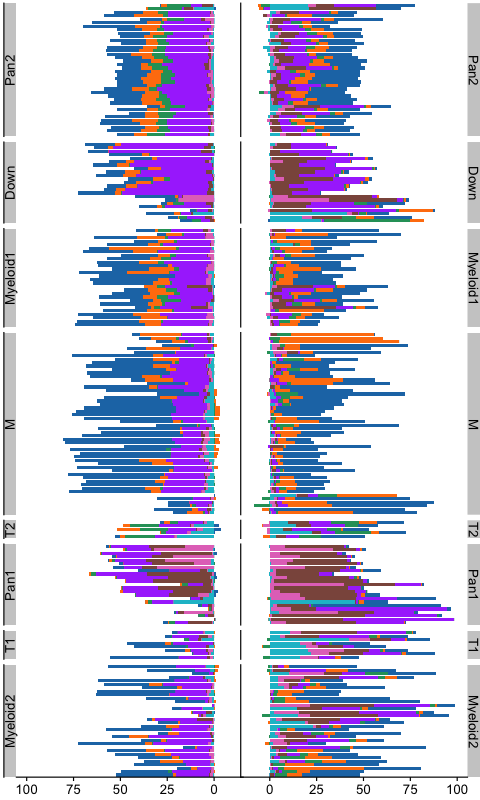

Warning message:
“Removed 2 rows containing missing values (position_stack).”Warning message:
“Removed 7 rows containing missing values (geom_bar).”

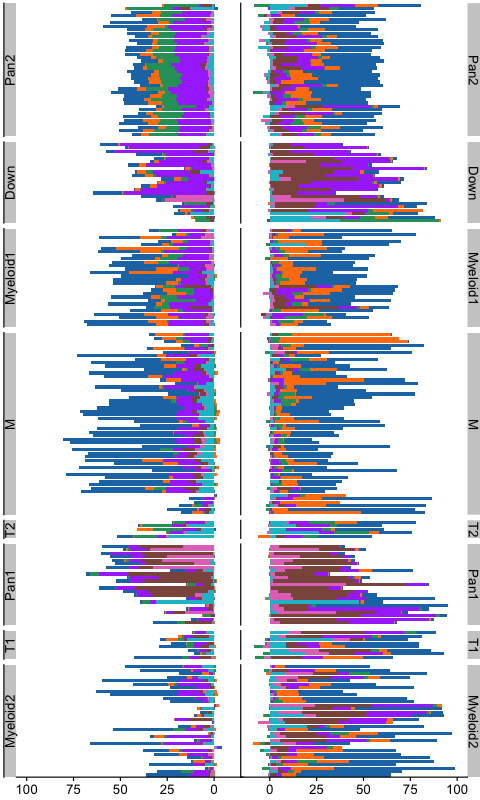

Saving 3 x 7 in image
Warning message:
“Removed 2 rows containing missing values (position_stack).”Warning message:
“Removed 12 rows containing missing values (geom_bar).”

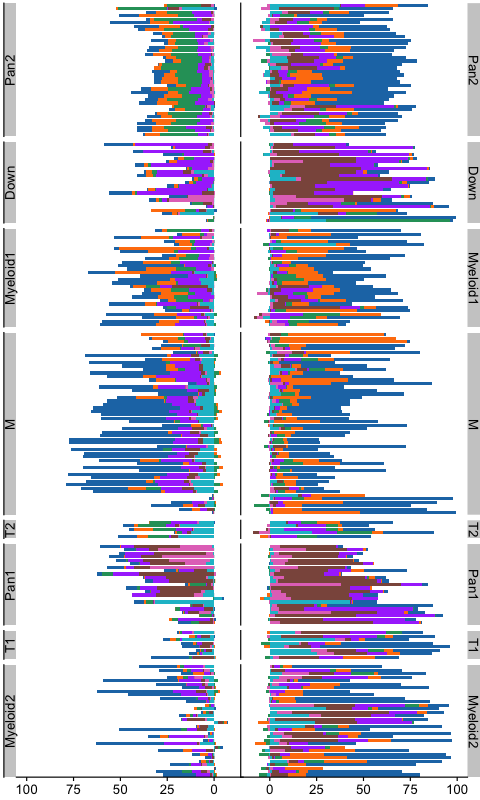

Saving 3 x 7 in image
Warning message:
“Removed 41 rows containing missing values (position_stack).”Warning message:
“Removed 137 rows containing missing values (geom_bar).”Warning message:
“Removed 14 rows containing missing values (position_stack).”Warning message:
“Removed 162 rows containing missing values (geom_bar).”

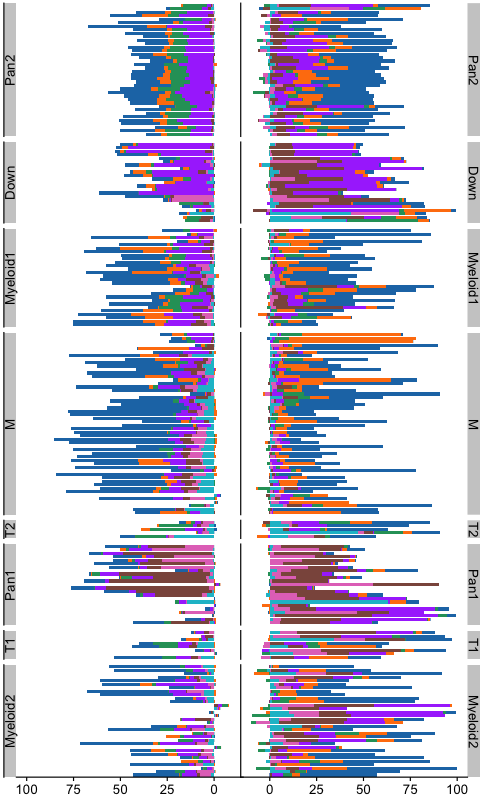

Warning message:
“Removed 1 rows containing missing values (position_stack).”Warning message:
“Removed 24 rows containing missing values (geom_bar).”Warning message:
“Removed 2 rows containing missing values (position_stack).”Warning message:
“Removed 61 rows containing missing values (geom_bar).”

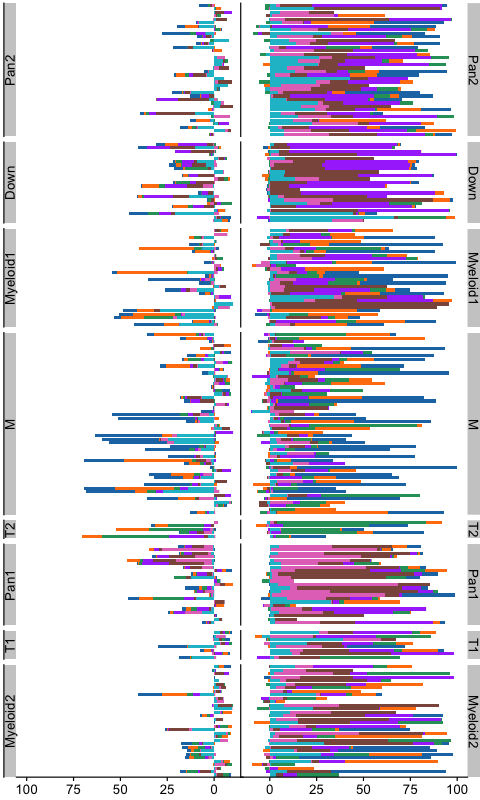

Saving 3 x 7 in image


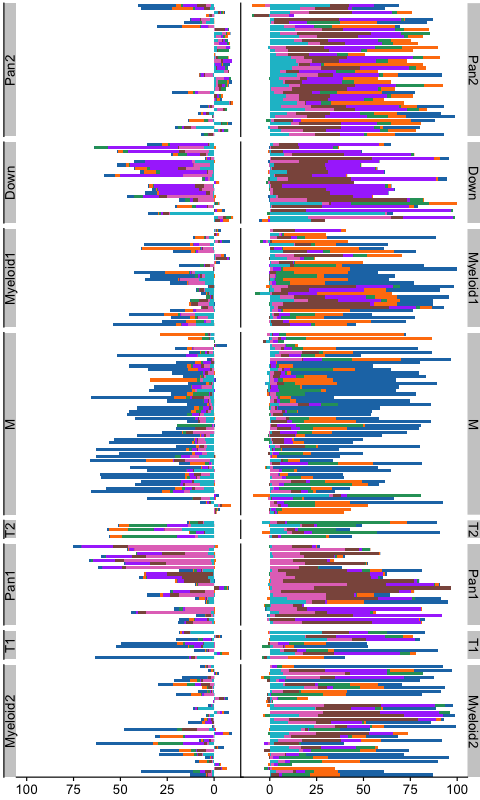

In [68]:
a <- plot_bar_chart(output_prop_noint, output_expr_noint, pheatmap_std_out, cuttree_out)
b <- plot_bar_chart(output_sle_prop_noint, output_sle_expr_noint, pheatmap_std_out, cuttree_out)
c <- plot_bar_chart(output_sle_asian_prop_noint, output_sle_asian_expr_noint, pheatmap_std_out, cuttree_out)
ggsave(c, file="sle_asian_partitioned.png",width=3)
d <- plot_bar_chart(output_sle_white_prop_noint, output_sle_white_expr_noint, pheatmap_std_out, cuttree_out)
ggsave(d, file="sle_white_partitioned.png",width=3);
e <- plot_bar_chart(output_ucsf_healthy_prop_noint, output_ucsf_healthy_expr_noint, pheatmap_std_out, cuttree_out)
f <- plot_bar_chart(output_broad_healthy_prop_noint, output_broad_healthy_expr_noint, pheatmap_std_out, cuttree_out)
ggsave(f, file="broad_white_partitioned.png",width=3);


In [69]:
t(output_broad_healthy_prop_noint["IFNG",])

cM       Th      B       NK       ncM       Tc       DC       total r2
[1,] 1.258633 39.6297 1.04965 19.94009 -1.431553 33.99368 5.559808 23.03795
     adj r2  
[1,] 23.33077

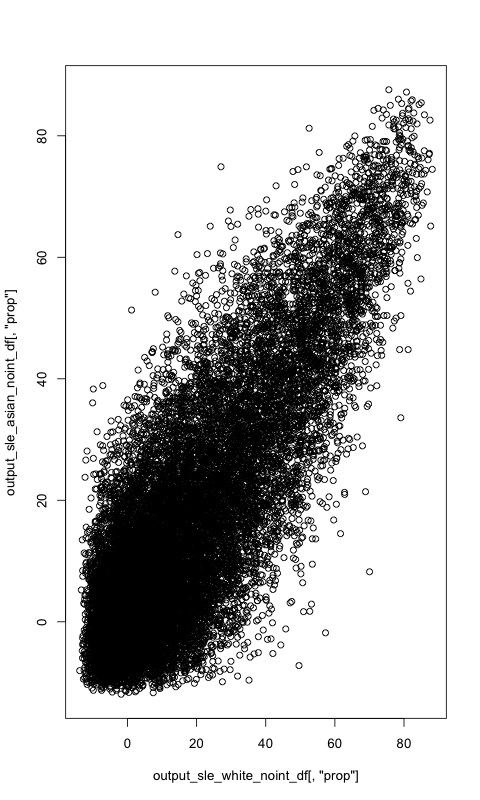

In [70]:
plot(output_sle_white_noint_df[,"prop"], output_sle_asian_noint_df[,"prop"])

In [71]:
a <- cbind(rownames(output_sle_white_noint_df)[output_sle_white_noint_df[,"cluster"]=="6"], output_sle_white_noint_df[output_sle_white_noint_df[,"cluster"]=="6","prop"]-output_broad_healthy_noint_df[output_sle_white_noint_df[,"cluster"]=="6","prop"])
a[order(as.numeric(a[,2]),decreasing=T),]

[,1]           [,2]             
 [1,] PATL2          84.9828373422434 
 [2,] ZNF683         49.3624064994898 
 [3,] IFNG           36.9947928671408 
 [4,] UTS2           33.3077984203393 
 [5,] LAG3           32.865794318767  
 [6,] GZMH           27.8672413430355 
 [7,] IL6            24.70811537384   
 [8,] TIGIT          23.7353677301055 
 [9,] PTMS           16.6269810315056 
[10,] FCRL6          15.6853131698342 
[11,] CCL4           5.69644815126458 
[12,] CCL3L3         4.57695820855061 
[13,] GZMB           3.73307492311458 
[14,] MIR4435-1HG    2.53190685723725 
[15,] LAIR2          0.605015234885565
[16,] RP11-1399P15.1 -4.05286619264254
[17,] PRSS23         -5.75049833203823
[18,] FGFBP2         -6.39015421308036
[19,] NPDC1          -7.95270548224585
[20,] GPR56          -11.7377801203223
[21,] TNFRSF4        -12.5005022425525
[22,] TNFRSF18       -14.4599021609557
[23,] C1orf21        -15.2993216729466

# Let's do the estimation using resampling

We are going to work with counts here. Given the expression of an arbitrary gene $i$ and individual $j$ in PBMCs $P$, and two cell types (B and T) for simplicity. $N_j^B$ and $N_j^T$ are the number of B cells and T cells for individual $j$.

\begin{align*}
P_{ij} &= B_{ij1}+B_{ij2}+...+B_{ijN_b}+T_{ij1}+T_{ij2}+...+T_{ijN_t} \\
P_{ij} &= \sum_k^{N_j^B}B_{ijk} + \sum_k^{N_j^T}T_{ijk} \\
P_{ij} &= N_j^B\times{\bar{B}_{ij}} + N_j^T\times{\bar{T}_{ij}} \\
\bar{P_{ij}} &= {{N_j^B}\over{N_j^{PBMC}}}\times{\bar{B_{ij}}} + {{N_j^T}\over{N_j^{PBMC}}}\times{\bar{T_{ij}}} \\
\bar{P_{ij}} &= {{{\rho}_j^B}\times{\bar{B_{ij}}} + {{\rho}_j^T}\times{\bar{T_{ij}}}}
\end{align*}


$\bar{B}_{ij}$ is the average expression of the gene $i$ in individual $j$ in cell type B. $\bar{T}_{ij}$ is the average expression of the gene $i$ in individual $j$ in cell type T

First, fit proportion

\begin{align*}
\bar{P_{ij}} &= {{\rho}_j^B}\times{\bar{B_{i}}} + {{\rho}_j^T}\times{\bar{T_{i}}}
\end{align*}

When we fit, we will take the average of expression over all individuals. That is $\bar{B_{i}} = {{\sum_j^{J}\bar{B_{ij}}}\over{J}}$

Second, fit expression

\begin{align*}
\bar{P_{ij}} &= {\bar{{\rho}^B}}\times{B_{ij}} + {\bar{{\rho}^T}}\times{T_{ij}}
\end{align*}

When we fit, we will take the average of expression over all individuals. That is $\bar{{\rho}^B} = {{{\sum_j^{J}{\rho_j^B}}}\over{J}}$


## First, let's do all individuals

In [73]:
# ##joined_pivot_filtered <- joined_pivot[match(colnames(pbmc_expr),joined_pivot$ind_cov),]
# # cm_counts_mean <- sweep(exp(cm_expr), 2, joined_pivot_filtered$counts*cm_prop/100, "/")
# # th_counts_mean <- sweep(exp(th_expr), 2, joined_pivot_filtered$counts*th_prop/100, "/")
# # tc_counts_mean <- sweep(exp(tc_expr), 2, joined_pivot_filtered$counts*tc_prop/100, "/")
# # b_counts_mean <- sweep(exp(b_expr), 2, joined_pivot_filtered$counts*b_prop/100, "/")
# # nk_counts_mean <- sweep(exp(nk_expr), 2, joined_pivot_filtered$counts*nk_prop/100, "/")
# # ncm_counts_mean <- sweep(exp(ncm_expr), 2, joined_pivot_filtered$counts*ncm_prop/100, "/")
# # dc_counts_mean <- sweep(exp(dc_expr), 2, joined_pivot_filtered$counts*dc_prop/100, "/")
# # pbmc_counts_mean <- sweep(exp(pbmc_expr), 2, joined_pivot_filtered$counts, "/")

# cm_counts_mean <- exp(cm_expr)
# th_counts_mean <- exp(th_expr)
# tc_counts_mean <- exp(tc_expr)
# b_counts_mean <- exp(b_expr)
# nk_counts_mean <- exp(nk_expr)
# ncm_counts_mean <- exp(ncm_expr)
# dc_counts_mean <- exp(dc_expr)
# pbmc_counts_mean <- exp(pbmc_expr)


# ## some samples do not have b cells or dcs, let's set those means to 0
# b_counts_mean[is.nan(b_counts_mean)] <- 0;
# dc_counts_mean[is.nan(dc_counts_mean)] <- 0;
# b_counts_mean[!is.finite(b_counts_mean)] <- 0;
# dc_counts_mean[!is.finite(dc_counts_mean)] <- 0;

# # cm_counts_global_mean <- rowSums(exp(cm_expr))/sum(joined_pivot_filtered$counts*cm_prop/100, na.rm=T)
# # th_counts_global_mean <- rowSums(exp(th_expr))/sum(joined_pivot_filtered$counts*th_prop/100, na.rm=T)
# # tc_counts_global_mean <- rowSums(exp(tc_expr))/sum(joined_pivot_filtered$counts*tc_prop/100, na.rm=T)
# # b_counts_global_mean <- rowSums(exp(b_expr))/sum(joined_pivot_filtered$counts*b_prop/100, na.rm=T)
# # nk_counts_global_mean <- rowSums(exp(nk_expr))/sum(joined_pivot_filtered$counts*nk_prop/100, na.rm=T)
# # ncm_counts_global_mean <- rowSums(exp(ncm_expr))/sum(joined_pivot_filtered$counts*ncm_prop/100, na.rm=T)
# # dc_counts_global_mean <- rowSums(exp(dc_expr))/sum(joined_pivot_filtered$counts*dc_prop/100, na.rm=T)

# cm_counts_global_mean <- apply(exp(cm_expr),1,mean)
# th_counts_global_mean <- apply(exp(th_expr),1,mean)
# tc_counts_global_mean <- apply(exp(tc_expr),1,mean)
# b_counts_global_mean <- apply(exp(b_expr),1,mean)
# nk_counts_global_mean <- apply(exp(nk_expr),1,mean)
# ncm_counts_global_mean <- apply(exp(ncm_expr),1,mean)
# dc_counts_global_mean <- apply(exp(dc_expr),1,mean)


# a <- cbind(cm_counts_global_mean, th_counts_global_mean, tc_counts_global_mean, b_counts_global_mean, nk_counts_global_mean, ncm_counts_global_mean, dc_counts_global_mean)
# ##sle_counts_means <- cbind(cm_sle_counts_mean, th_sle_counts_mean, tc_sle_counts_mean, b_sle_counts_mean, nk_sle_counts_mean, ncm_sle_counts_mean, dc_sle_counts_mean)

# output_direct_global_prop <- NULL;

# for(i in 1:nrow(pbmc_counts[match(expr_gene_names, counts_gene_names),])) {    
#     predicted <- rowSums(cbind(cm_counts_global_mean[i]*cm_prop/100,
#                                th_counts_global_mean[i]*th_prop/100, 
#                                b_counts_global_mean[i]*b_prop/100, 
#                                nk_counts_global_mean[i]*nk_prop/100, 
#                                ncm_counts_global_mean[i]*ncm_prop/100, 
#                                tc_counts_global_mean[i]*tc_prop/100,##), na.rm=T)
#                                dc_counts_global_mean[i]*dc_prop/100), na.rm=T)

#     output_direct_global_prop <- rbind(output_direct_global_prop, c(cor(log(predicted),pbmc_expr_std[i,])^2*100, 1-cor(log(predicted),pbmc_expr_std[i,])^2*100))
# }


# rownames(output_direct_global_prop) <- counts_gene_names[match(expr_gene_names, counts_gene_names)];
# colnames(output_direct_global_prop) <- c("r2", "res")

# output_direct_global_expr <- NULL;

# cm_prop_global_mean <- sum(joined_pivot_filtered$counts*cm_prop/100,na.rm=T)/sum(joined_pivot_filtered$counts)
# th_prop_global_mean <- sum(joined_pivot_filtered$counts*th_prop/100,na.rm=T)/sum(joined_pivot_filtered$counts)
# tc_prop_global_mean <- sum(joined_pivot_filtered$counts*tc_prop/100,na.rm=T)/sum(joined_pivot_filtered$counts)
# b_prop_global_mean <- sum(joined_pivot_filtered$counts*b_prop/100,na.rm=T)/sum(joined_pivot_filtered$counts)
# nk_prop_global_mean <- sum(joined_pivot_filtered$counts*nk_prop/100,na.rm=T)/sum(joined_pivot_filtered$counts)
# ncm_prop_global_mean <- sum(joined_pivot_filtered$counts*ncm_prop/100,na.rm=T)/sum(joined_pivot_filtered$counts)
# dc_prop_global_mean <- sum(joined_pivot_filtered$counts*dc_prop/100,na.rm=T)/sum(joined_pivot_filtered$counts)

# a_prop <- c(cm_prop_global_mean, th_prop_global_mean, tc_prop_global_mean, b_prop_global_mean, nk_prop_global_mean, ncm_prop_global_mean, dc_prop_global_mean);

# for(i in 1:nrow(pbmc_counts[match(expr_gene_names, counts_gene_names),])) {
#    predicted <- rowSums(cbind(cm_counts_mean[i,]*cm_prop_global_mean, 
#                               th_counts_mean[i,]*th_prop_global_mean, 
#                               b_counts_mean[i,]*b_prop_global_mean,
#                               nk_counts_mean[i,]*nk_prop_global_mean, 
#                                ncm_counts_mean[i,]*ncm_prop_global_mean,
#                               tc_counts_mean[i,]*tc_prop_global_mean,##), na.rm=T)
#                               dc_counts_mean[i,]*dc_prop_global_mean), na.rm=T)

#     output_direct_global_expr <- rbind(output_direct_global_expr, c(cor(log(predicted),pbmc_expr_std[i,])^2*100, 1-cor(log(predicted),pbmc_expr_std[i,])^2*100))
# }

# rownames(output_direct_global_expr) <- expr_gene_names;
# colnames(output_direct_global_expr) <- c("r2", "res")

In [74]:
# options(repr.plot.width = 4, repr.plot.height = 4)
# i=10
# i=grep("^CD22$",expr_gene_names)[1]
# ##i=grep("ERAP2",expr_gene_names)[1]
# predicted <- rowSums(cbind(cm_counts_global_mean[i]*cm_prop/100,
#                                th_counts_global_mean[i]*th_prop/100,
#                                b_counts_global_mean[i]*b_prop/100,
#                                nk_counts_global_mean[i]*nk_prop/100, 
#                                ncm_counts_global_mean[i]*ncm_prop/100,
#                                tc_counts_global_mean[i]*tc_prop/100,
#                      dc_counts_global_mean[i]*dc_prop/100),na.rm=T)
# plot(log(predicted), log(pbmc_counts_mean[i,]))
# cor(log(predicted), pbmc_expr_std[i,])^2

# predicted <- rowSums(cbind(cm_counts_mean[i,]*cm_prop_global_mean, 
#                               th_counts_mean[i,]*th_prop_global_mean, 
#                               b_counts_mean[i,]*b_prop_global_mean,
#                               nk_counts_mean[i,]*nk_prop_global_mean, 
#                                ncm_counts_mean[i,]*ncm_prop_global_mean,
#                               tc_counts_mean[i,]*tc_prop_global_mean,
#                           dc_counts_mean[i,]*dc_prop_global_mean), na.rm=T)
# plot(log(predicted), pbmc_expr_std[i,])
# cor(log(predicted), pbmc_expr_std[i,])^2


# predicted <- rowSums(cbind(cm_counts_mean[i,]*cm_prop, 
#                               th_counts_mean[i,]*th_prop, 
#                               b_counts_mean[i,]*b_prop,
#                               nk_counts_mean[i,]*nk_prop, 
#                                ncm_counts_mean[i,]*ncm_prop,
#                               tc_counts_mean[i,]*tc_prop,
#                           dc_counts_mean[i,]*dc_prop), na.rm=T)
# plot(log(predicted), pbmc_expr_std[i,])
# cor(log(predicted), pbmc_expr_std[i,])^2

## Second, let's do SLE

Mean of means might be a bit unstable, let's calculate a global mean

### All SLE

In [75]:
# # cm_sle_counts_mean <- sweep(exp(cm_sle_expr), 2, joined_pivot_sle$counts*cm_sle_prop/100, "/")
# # th_sle_counts_mean <- sweep(exp(th_sle_expr), 2, joined_pivot_sle$counts*th_sle_prop/100, "/")
# # tc_sle_counts_mean <- sweep(exp(tc_sle_expr), 2, joined_pivot_sle$counts*tc_sle_prop/100, "/")
# # b_sle_counts_mean <- sweep(exp(b_sle_expr), 2, joined_pivot_sle$counts*b_sle_prop/100, "/")
# # nk_sle_counts_mean <- sweep(exp(nk_sle_expr), 2, joined_pivot_sle$counts*nk_sle_prop/100, "/")
# # ncm_sle_counts_mean <- sweep(exp(ncm_sle_expr), 2, joined_pivot_sle$counts*ncm_sle_prop/100, "/")
# # dc_sle_counts_mean <- sweep(exp(dc_sle_expr), 2, joined_pivot_sle$counts*dc_sle_prop/100, "/")
# # pbmc_sle_counts_mean <- sweep(exp(pbmc_sle_expr), 2, joined_pivot_sle$counts, "/")


# cm_sle_counts_mean <- exp(cm_sle_expr);
# th_sle_counts_mean <- exp(th_sle_expr);
# tc_sle_counts_mean <- exp(tc_sle_expr);
# b_sle_counts_mean <- exp(b_sle_expr);
# nk_sle_counts_mean <- exp(nk_sle_expr);
# ncm_sle_counts_mean <- exp(ncm_sle_expr);
# dc_sle_counts_mean <- exp(dc_sle_expr);
# pbmc_sle_counts_mean <- exp(pbmc_sle_expr);

# # cm_sle_counts_global_mean <- rowSums(exp(cm_sle_expr))/sum(joined_pivot_sle$counts*cm_sle_prop/100, na.rm=T)
# # th_sle_counts_global_mean <- rowSums(exp(th_sle_expr))/sum(joined_pivot_sle$counts*th_sle_prop/100, na.rm=T)
# # tc_sle_counts_global_mean <- rowSums(exp(tc_sle_expr))/sum(joined_pivot_sle$counts*tc_sle_prop/100, na.rm=T)
# # b_sle_counts_global_mean <- rowSums(exp(b_sle_expr))/sum(joined_pivot_sle$counts*b_sle_prop/100, na.rm=T)
# # nk_sle_counts_global_mean <- rowSums(exp(nk_sle_expr))/sum(joined_pivot_sle$counts*nk_sle_prop/100, na.rm=T)
# # ncm_sle_counts_global_mean <- rowSums(exp(ncm_sle_expr))/sum(joined_pivot_sle$counts*ncm_sle_prop/100, na.rm=T)
# # dc_sle_counts_global_mean <- rowSums(exp(dc_sle_expr))/sum(joined_pivot_sle$counts*dc_sle_prop/100, na.rm=T)

# cm_sle_counts_global_mean <- apply(exp(cm_sle_expr),1,mean)
# th_sle_counts_global_mean <- apply(exp(th_sle_expr),1,mean)
# tc_sle_counts_global_mean <- apply(exp(tc_sle_expr),1,mean)
# b_sle_counts_global_mean <- apply(exp(b_sle_expr),1,mean)
# nk_sle_counts_global_mean <- apply(exp(nk_sle_expr),1,mean)
# ncm_sle_counts_global_mean <- apply(exp(ncm_sle_expr),1,mean)
# dc_sle_counts_global_mean <- apply(exp(dc_sle_expr),1,mean)


# ## some samples do not have b cells or dcs, let's set those means to 0
# b_sle_counts_mean[is.nan(b_sle_counts_mean)] <- 0;
# dc_sle_counts_mean[is.nan(dc_sle_counts_mean)] <- 0;
# b_sle_counts_mean[!is.finite(b_sle_counts_mean)] <- 0;
# dc_sle_counts_mean[!is.finite(dc_sle_counts_mean)] <- 0;

# ##sle_counts_means <- cbind(cm_sle_counts_mean, th_sle_counts_mean, tc_sle_counts_mean, b_sle_counts_mean, nk_sle_counts_mean, ncm_sle_counts_mean, dc_sle_counts_mean)

# output_sle_direct_global_prop <- NULL;

# for(i in 1:nrow(pbmc_sle_counts[match(expr_gene_names, counts_gene_names),])) {    
#     predicted <- rowSums(cbind(cm_sle_counts_global_mean[i]*cm_sle_prop/100,
#                                th_sle_counts_global_mean[i]*th_sle_prop/100,
#                                b_sle_counts_global_mean[i]*b_sle_prop/100,
#                                nk_sle_counts_global_mean[i]*nk_sle_prop/100, 
#                                ncm_sle_counts_global_mean[i]*ncm_sle_prop/100,
#                                tc_sle_counts_global_mean[i]*tc_sle_prop/100,##), na.rm=T)
#                                dc_sle_counts_global_mean[i]*dc_sle_prop/100),na.rm=T)

#     output_sle_direct_global_prop <- rbind(output_sle_direct_global_prop, 
#                                                c(cor(log(predicted),pbmc_sle_expr_std[i,])^2*100, 1-cor(log(predicted),pbmc_sle_expr_std[i,])^2*100))
# }


# rownames(output_sle_direct_global_prop) <- counts_gene_names[match(expr_gene_names, counts_gene_names)];
# colnames(output_sle_direct_global_prop) <- c("r2", "res")

# output_sle_direct_global_expr <- NULL;

# cm_sle_prop_global_mean <- sum(joined_pivot_sle$counts*cm_sle_prop/100,na.rm=T)/sum(joined_pivot_sle$counts)
# th_sle_prop_global_mean <- sum(joined_pivot_sle$counts*th_sle_prop/100,na.rm=T)/sum(joined_pivot_sle$counts)
# tc_sle_prop_global_mean <- sum(joined_pivot_sle$counts*tc_sle_prop/100,na.rm=T)/sum(joined_pivot_sle$counts)
# b_sle_prop_global_mean <- sum(joined_pivot_sle$counts*b_sle_prop/100,na.rm=T)/sum(joined_pivot_sle$counts)
# nk_sle_prop_global_mean <- sum(joined_pivot_sle$counts*nk_sle_prop/100,na.rm=T)/sum(joined_pivot_sle$counts)
# ncm_sle_prop_global_mean <- sum(joined_pivot_sle$counts*ncm_sle_prop/100,na.rm=T)/sum(joined_pivot_sle$counts)
# dc_sle_prop_global_mean <- sum(joined_pivot_sle$counts*dc_sle_prop/100,na.rm=T)/sum(joined_pivot_sle$counts)

# for(i in 1:nrow(pbmc_sle_counts[match(expr_gene_names, counts_gene_names),])) {
#    predicted <- rowSums(cbind(cm_sle_counts_mean[i,]*cm_sle_prop_global_mean,
#                               th_sle_counts_mean[i,]*th_sle_prop_global_mean,
#                               b_sle_counts_mean[i,]*b_sle_prop_global_mean,
#                               nk_sle_counts_mean[i,]*nk_sle_prop_global_mean, 
#                                ncm_sle_counts_mean[i,]*ncm_sle_prop_global_mean,
#                               tc_sle_counts_mean[i,]*tc_sle_prop_global_mean,##), na.rm=T)
#                               dc_sle_counts_mean[i]*dc_sle_prop_global_mean),na.rm=T)

#    ##output_sle_direct_global_expr <- rbind(output_sle_direct_global_expr, c(var(predicted)/var(pbmc_sle_counts_mean[i,],na.rm=T)*100, 100-var(predicted)/var(pbmc_sle_counts_mean[i,],na.rm=T)*100))
#   output_sle_direct_global_expr <- rbind(output_sle_direct_global_expr, 
#                                          c(cor(log(predicted),pbmc_sle_expr_std[i,])^2*100, 1-cor(log(predicted),pbmc_sle_expr_std[i,])^2*100))
# }

# rownames(output_sle_direct_global_expr) <- expr_gene_names;
# colnames(output_sle_direct_global_expr) <- c("r2", "res")

In [76]:
# options(repr.plot.width = 4, repr.plot.height = 4)
# i=2
# i=grep("^CD22$",expr_gene_names)[1]
# predicted <- rowSums(cbind(cm_sle_counts_global_mean[i]*cm_sle_prop/100,
#                                th_sle_counts_global_mean[i]*th_sle_prop/100,
#                                b_sle_counts_global_mean[i]*b_sle_prop/100,
#                                nk_sle_counts_global_mean[i]*nk_sle_prop/100, 
#                                ncm_sle_counts_global_mean[i]*ncm_sle_prop/100,
#                                tc_sle_counts_global_mean[i]*tc_sle_prop/100,
#                           dc_sle_counts_global_mean[i]*dc_sle_prop/100), na.rm=T)
# plot(log(predicted), log(pbmc_sle_counts_mean[i,]))
# cor(predicted, pbmc_sle_counts_mean[i,])^2
# output_sle_prop_noint[i,"adj r2"]

# predicted <- rowSums(cbind(cm_sle_counts_mean[i,]*cm_sle_prop_global_mean, 
#                               th_sle_counts_mean[i,]*th_sle_prop_global_mean, 
#                               b_sle_counts_mean[i,]*b_sle_prop_global_mean,
#                               nk_sle_counts_mean[i,]*nk_sle_prop_global_mean, 
#                                ncm_sle_counts_mean[i,]*ncm_sle_prop_global_mean,
#                               tc_sle_counts_mean[i,]*tc_sle_prop_global_mean,##), na.rm=T)
#                           dc_sle_counts_mean[i,]*dc_sle_prop_global_mean), na.rm=T)

# plot(log(predicted), log(pbmc_sle_counts_mean[i,]))
# cor(predicted, pbmc_sle_counts_mean[i,])^2

# predicted <- rowSums(cbind(cm_sle_counts_mean[i,]*cm_sle_prop, 
#                               th_sle_counts_mean[i,]*th_sle_prop, 
#                               b_sle_counts_mean[i,]*b_sle_prop,
#                               nk_sle_counts_mean[i,]*nk_sle_prop, 
#                                ncm_sle_counts_mean[i,]*ncm_sle_prop,
#                               tc_sle_counts_mean[i,]*tc_sle_prop,
#                           dc_sle_counts_mean[i,]*dc_sle_prop), na.rm=T)
# plot(predicted, pbmc_sle_counts_mean[i,])
# cor(predicted, pbmc_sle_counts_mean[i,])^2



### Now, let's downsample to 46 and redo SLE

In [77]:
# cm_sle_down_counts_global_mean <- apply(exp(cm_sle_expr[,samples]),1,mean)
# th_sle_down_counts_global_mean <- apply(exp(th_sle_expr[,samples]),1,mean)
# tc_sle_down_counts_global_mean <- apply(exp(tc_sle_expr[,samples]),1,mean)
# b_sle_down_counts_global_mean <- apply(exp(b_sle_expr[,samples]),1,mean)
# nk_sle_down_counts_global_mean <- apply(exp(nk_sle_expr[,samples]),1,mean)
# ncm_sle_down_counts_global_mean <- apply(exp(ncm_sle_expr[,samples]),1,mean)
# dc_sle_down_counts_global_mean <- apply(exp(dc_sle_expr[,samples]),1,mean)

# # cm_sle_down_counts_global_mean <- rowSums(exp(cm_sle_expr[,samples]))/sum((joined_pivot_sle$counts*cm_sle_prop/100)[samples])
# # th_sle_down_counts_global_mean <- rowSums(exp(th_sle_expr[,samples]))/sum((joined_pivot_sle$counts*th_sle_prop/100)[samples])
# # tc_sle_down_counts_global_mean <- rowSums(exp(tc_sle_expr[,samples]))/sum((joined_pivot_sle$counts*tc_sle_prop/100)[samples])
# # b_sle_down_counts_global_mean <- rowSums(exp(b_sle_expr[,samples]),na.rm=T)/sum((joined_pivot_sle$counts*b_sle_prop/100)[samples],na.rm=T)
# # nk_sle_down_counts_global_mean <- rowSums(exp(nk_sle_expr[,samples]))/sum((joined_pivot_sle$counts*nk_sle_prop/100)[samples])
# # ncm_sle_down_counts_global_mean <- rowSums(exp(ncm_sle_expr[,samples]))/sum((joined_pivot_sle$counts*ncm_sle_prop/100)[samples])
# # dc_sle_down_counts_global_mean <- rowSums(exp(dc_sle_expr[,samples]),na.rm=T)/sum((joined_pivot_sle$counts*dc_sle_prop/100)[samples],na.rm=T)

# output_sle_down_direct_global_prop <- NULL;

# for(i in 1:nrow(pbmc_sle_counts[match(expr_gene_names, counts_gene_names),samples])) {    
#     predicted <- rowSums(cbind(cm_sle_counts_global_mean[i]*cm_sle_prop[samples]/100, 
#                                th_sle_counts_global_mean[i]*th_sle_prop[samples]/100, 
#                                b_sle_counts_global_mean[i]*b_sle_prop[samples]/100, 
#                                nk_sle_counts_global_mean[i]*nk_sle_prop[samples]/100, 
#                                ncm_sle_counts_global_mean[i]*ncm_sle_prop[samples]/100, 
#                                tc_sle_counts_global_mean[i]*tc_sle_prop[samples]/100,##), na.rm=T)
#                                dc_sle_counts_global_mean[i]*dc_sle_prop[samples]/100), na.rm=T)

#     output_sle_down_direct_global_prop <- rbind(output_sle_down_direct_global_prop,
#                                                 c(cor(log(predicted),pbmc_sle_expr_std[i,samples])^2*100, 1-cor(log(predicted),pbmc_sle_expr_std[i,samples])^2*100))
# }


# rownames(output_sle_down_direct_global_prop) <- counts_gene_names[match(expr_gene_names, counts_gene_names)];
# colnames(output_sle_down_direct_global_prop) <- c("r2", "res")

# output_sle_down_direct_global_expr <- NULL;

# cm_sle_down_prop_global_mean <- sum((joined_pivot_sle$counts*cm_sle_prop/100)[samples],na.rm=T)/sum(joined_pivot_sle$counts[samples])
# th_sle_down_prop_global_mean <- sum((joined_pivot_sle$counts*th_sle_prop/100)[samples],na.rm=T)/sum(joined_pivot_sle$counts[samples])
# tc_sle_down_prop_global_mean <- sum((joined_pivot_sle$counts*tc_sle_prop/100)[samples],na.rm=T)/sum(joined_pivot_sle$counts[samples])
# b_sle_down_prop_global_mean <- sum((joined_pivot_sle$counts*b_sle_prop/100)[samples],na.rm=T)/sum(joined_pivot_sle$counts[samples],na.rm=T)
# nk_sle_down_prop_global_mean <- sum((joined_pivot_sle$counts*nk_sle_prop/100)[samples],na.rm=T)/sum(joined_pivot_sle$counts[samples])
# ncm_sle_down_prop_global_mean <- sum((joined_pivot_sle$counts*ncm_sle_prop/100)[samples],na.rm=T)/sum(joined_pivot_sle$counts[samples])
# dc_sle_down_prop_global_mean <- sum((joined_pivot_sle$counts*dc_sle_prop/100)[samples],na.rm=T)/sum(joined_pivot_sle$counts[samples],na.rm=T)

# for(i in 1:nrow(pbmc_sle_counts[match(expr_gene_names, counts_gene_names),])) {
#    predicted <- rowSums(cbind(cm_sle_counts_mean[i,samples]*cm_sle_down_prop_global_mean,
#                               th_sle_counts_mean[i,samples]*th_sle_down_prop_global_mean, 
#                               b_sle_counts_mean[i,samples]*b_sle_down_prop_global_mean, 
#                               nk_sle_counts_mean[i,samples]*nk_sle_down_prop_global_mean,
#                               ncm_sle_counts_mean[i,samples]*ncm_sle_down_prop_global_mean, 
#                               tc_sle_counts_mean[i,samples]*tc_sle_down_prop_global_mean,##), na.rm=T)
#                               dc_sle_counts_mean[i,samples]*dc_sle_down_prop_global_mean), na.rm=T)

#     output_sle_down_direct_global_expr <- rbind(output_sle_down_direct_global_expr, 
#                                                 c(cor(log(predicted),pbmc_sle_expr_std[i,samples])^2*100, 1-cor(log(predicted),pbmc_sle_expr_std[i,samples])^2*100))
  
# }


## Finally, processed the healthy

In [78]:
# cm_healthy_counts_mean <- exp(cm_healthy_expr)
# th_healthy_counts_mean <- exp(th_healthy_expr)
# tc_healthy_counts_mean <- exp(tc_healthy_expr)
# b_healthy_counts_mean <- exp(b_healthy_expr)
# nk_healthy_counts_mean <- exp(nk_healthy_expr)
# ncm_healthy_counts_mean <- exp(ncm_healthy_expr)
# dc_healthy_counts_mean <- exp(dc_healthy_expr)
# pbmc_healthy_counts_mean <- exp(pbmc_healthy_expr)


# # cm_healthy_counts_mean <- sweep(exp(cm_healthy_expr), 2, joined_pivot_healthy$counts*cm_healthy_prop/100, "/")
# # th_healthy_counts_mean <- sweep(exp(th_healthy_expr), 2, joined_pivot_healthy$counts*th_healthy_prop/100, "/")
# # tc_healthy_counts_mean <- sweep(exp(tc_healthy_expr), 2, joined_pivot_healthy$counts*tc_healthy_prop/100, "/")
# # b_healthy_counts_mean <- sweep(exp(b_healthy_expr), 2, joined_pivot_healthy$counts*b_healthy_prop/100, "/")
# # nk_healthy_counts_mean <- sweep(exp(nk_healthy_expr), 2, joined_pivot_healthy$counts*nk_healthy_prop/100, "/")
# # ncm_healthy_counts_mean <- sweep(exp(ncm_healthy_expr), 2, joined_pivot_healthy$counts*ncm_healthy_prop/100, "/")
# # dc_healthy_counts_mean <- sweep(exp(dc_healthy_expr), 2, joined_pivot_healthy$counts*dc_healthy_prop/100, "/")
# # pbmc_healthy_counts_mean <- sweep(exp(pbmc_healthy_expr), 2, joined_pivot_healthy$counts, "/")

# cm_healthy_counts_global_mean <- apply(exp(cm_healthy_expr),1,mean)
# th_healthy_counts_global_mean <- apply(exp(th_healthy_expr),1,mean)
# tc_healthy_counts_global_mean <- apply(exp(tc_healthy_expr),1,mean)
# b_healthy_counts_global_mean <- apply(exp(b_healthy_expr),1,mean)
# nk_healthy_counts_global_mean <- apply(exp(nk_healthy_expr),1,mean)
# ncm_healthy_counts_global_mean <- apply(exp(ncm_healthy_expr),1,mean)
# dc_healthy_counts_global_mean <- apply(exp(dc_healthy_expr),1,mean)

# # cm_healthy_counts_global_mean <- rowSums(exp(cm_healthy_expr))/sum(joined_pivot_healthy$counts*cm_healthy_prop/100, na.rm=T)
# # th_healthy_counts_global_mean <- rowSums(exp(th_healthy_expr))/sum(joined_pivot_healthy$counts*th_healthy_prop/100, na.rm=T)
# # tc_healthy_counts_global_mean <- rowSums(exp(tc_healthy_expr))/sum(joined_pivot_healthy$counts*tc_healthy_prop/100, na.rm=T)
# # b_healthy_counts_global_mean <- rowSums(exp(b_healthy_expr))/sum(joined_pivot_healthy$counts*b_healthy_prop/100, na.rm=T)
# # nk_healthy_counts_global_mean <- rowSums(exp(nk_healthy_expr))/sum(joined_pivot_healthy$counts*nk_healthy_prop/100, na.rm=T)
# # ncm_healthy_counts_global_mean <- rowSums(exp(ncm_healthy_expr))/sum(joined_pivot_healthy$counts*ncm_healthy_prop/100, na.rm=T)
# # dc_healthy_counts_global_mean <- rowSums(exp(dc_healthy_expr))/sum(joined_pivot_healthy$counts*dc_healthy_prop/100, na.rm=T)

# ##healthy_counts_means <- cbind(cm_healthy_counts_mean, th_healthy_counts_mean, tc_healthy_counts_mean, b_healthy_counts_mean, nk_healthy_counts_mean, ncm_healthy_counts_mean, dc_healthy_counts_mean)

# output_healthy_direct_global_prop <- NULL;

# for(i in 1:nrow(pbmc_healthy_counts[match(expr_gene_names, counts_gene_names),])) {    
#     predicted <- rowSums(cbind(cm_healthy_counts_global_mean[i]*cm_healthy_prop/100,
#                                th_healthy_counts_global_mean[i]*th_healthy_prop/100,
#                                b_healthy_counts_global_mean[i]*b_healthy_prop/100,
#                                nk_healthy_counts_global_mean[i]*nk_healthy_prop/100, 
#                                ncm_healthy_counts_global_mean[i]*ncm_healthy_prop/100,
#                                tc_healthy_counts_global_mean[i]*tc_healthy_prop/100,##), na.rm=T)
#                                dc_healthy_counts_global_mean[i]*dc_healthy_prop/100),na.rm=T)

#     output_healthy_direct_global_prop <- rbind(output_healthy_direct_global_prop, 
#                                                c(cor(log(predicted),pbmc_healthy_expr_std[i,])^2*100, 1-cor(log(predicted),pbmc_healthy_expr_std[i,])^2*100))
# }


# rownames(output_healthy_direct_global_prop) <- counts_gene_names[match(expr_gene_names, counts_gene_names)];
# colnames(output_healthy_direct_global_prop) <- c("r2", "res")

# output_healthy_direct_global_expr <- NULL;

# cm_healthy_prop_global_mean <- sum(joined_pivot_healthy$counts*cm_healthy_prop/100,na.rm=T)/sum(joined_pivot_healthy$counts)
# th_healthy_prop_global_mean <- sum(joined_pivot_healthy$counts*th_healthy_prop/100,na.rm=T)/sum(joined_pivot_healthy$counts)
# tc_healthy_prop_global_mean <- sum(joined_pivot_healthy$counts*tc_healthy_prop/100,na.rm=T)/sum(joined_pivot_healthy$counts)
# b_healthy_prop_global_mean <- sum(joined_pivot_healthy$counts*b_healthy_prop/100,na.rm=T)/sum(joined_pivot_healthy$counts)
# nk_healthy_prop_global_mean <- sum(joined_pivot_healthy$counts*nk_healthy_prop/100,na.rm=T)/sum(joined_pivot_healthy$counts)
# ncm_healthy_prop_global_mean <- sum(joined_pivot_healthy$counts*ncm_healthy_prop/100,na.rm=T)/sum(joined_pivot_healthy$counts)
# dc_healthy_prop_global_mean <- sum(joined_pivot_healthy$counts*dc_healthy_prop/100,na.rm=T)/sum(joined_pivot_healthy$counts)

# for(i in 1:nrow(pbmc_healthy_counts[match(expr_gene_names, counts_gene_names),])) {
#    predicted <- rowSums(cbind(cm_healthy_counts_mean[i,]*cm_healthy_prop_global_mean,
#                               th_healthy_counts_mean[i,]*th_healthy_prop_global_mean,
#                               b_healthy_counts_mean[i,]*b_healthy_prop_global_mean,
#                               nk_healthy_counts_mean[i,]*nk_healthy_prop_global_mean, 
#                                ncm_healthy_counts_mean[i,]*ncm_healthy_prop_global_mean,
#                               tc_healthy_counts_mean[i,]*tc_healthy_prop_global_mean,##), na.rm=T)
#                               dc_healthy_counts_mean[i]*dc_healthy_prop_global_mean),na.rm=T)

#    ##output_healthy_direct_global_expr <- rbind(output_healthy_direct_global_expr, c(var(predicted)/var(pbmc_healthy_counts_mean[i,],na.rm=T)*100, 100-var(predicted)/var(pbmc_healthy_counts_mean[i,],na.rm=T)*100))
#   output_healthy_direct_global_expr <- rbind(output_healthy_direct_global_expr, 
#                                          c(cor(log(predicted),pbmc_healthy_expr_std[i,])^2*100, 1-cor(log(predicted),pbmc_healthy_expr_std[i,])^2*100))
# }

# rownames(output_healthy_direct_global_expr) <- expr_gene_names;
# colnames(output_healthy_direct_global_expr) <- c("r2", "res")

In [79]:
# options(repr.plot.width = 4, repr.plot.height = 4)
# i=10
# i=grep("^CD22$",expr_gene_names)[1]
# predicted <- rowSums(cbind(cm_healthy_counts_global_mean[i]*cm_healthy_prop/100,
#                                th_healthy_counts_global_mean[i]*th_healthy_prop/100,
#                                b_healthy_counts_global_mean[i]*b_healthy_prop/100,
#                                nk_healthy_counts_global_mean[i]*nk_healthy_prop/100, 
#                                ncm_healthy_counts_global_mean[i]*ncm_healthy_prop/100,
#                                tc_healthy_counts_global_mean[i]*tc_healthy_prop/100,
#                           dc_healthy_counts_global_mean[i]*dc_healthy_prop/100), na.rm=T)
# plot(log(predicted), log(pbmc_healthy_counts_mean[i,]))
# cor(predicted, pbmc_healthy_counts_mean[i,])^2*100
# output_healthy_prop_noint[i,"adj r2"]

# predicted <- rowSums(cbind(cm_healthy_counts_mean[i,]*cm_healthy_prop_global_mean, 
#                               th_healthy_counts_mean[i,]*th_healthy_prop_global_mean, 
#                               b_healthy_counts_mean[i,]*b_healthy_prop_global_mean,
#                               nk_healthy_counts_mean[i,]*nk_healthy_prop_global_mean, 
#                                ncm_healthy_counts_mean[i,]*ncm_healthy_prop_global_mean,
#                               tc_healthy_counts_mean[i,]*tc_healthy_prop_global_mean,
#                           dc_healthy_counts_mean[i,]*dc_healthy_prop_global_mean), na.rm=T)
# plot(log(predicted), log(pbmc_healthy_counts_mean[i,]))
# cor(predicted, pbmc_healthy_counts_mean[i,])^2


# predicted <- rowSums(cbind(cm_healthy_counts_mean[i,]*cm_healthy_prop, 
#                               th_healthy_counts_mean[i,]*th_healthy_prop, 
#                               b_healthy_counts_mean[i,]*b_healthy_prop,
#                               nk_healthy_counts_mean[i,]*nk_healthy_prop, 
#                                ncm_healthy_counts_mean[i,]*ncm_healthy_prop,
#                               tc_healthy_counts_mean[i,]*tc_healthy_prop,
#                           dc_healthy_counts_mean[i,]*dc_healthy_prop), na.rm=T)
# plot(predicted, pbmc_healthy_counts_mean[i,])
# cor(predicted, pbmc_healthy_counts_mean[i,])^2

## Plotting

In [80]:
# df2 <- data.frame(cor=c(cor(output_prop_noint[,"adj r2"], output_expr_noint[,"adj r2"]), cor(output_sle_prop_noint[,"adj r2"], output_sle_expr_noint[,"adj r2"]), cor(output_sle_down_prop_noint[,"adj r2"], output_sle_down_expr_noint[,"adj r2"]), cor(output_healthy_prop_noint[,"adj r2"], output_healthy_expr_noint[,"adj r2"])),
#       prop_mean=c(mean(output_prop_noint[,"adj r2"]), mean(output_sle_prop_noint[,"adj r2"]), mean(output_sle_down_prop_noint[,"adj r2"]), mean(output_healthy_prop_noint[,"adj r2"])),
#       expr_mean=c(mean(output_expr_noint[,"adj r2"]), mean(output_sle_expr_noint[,"adj r2"]), mean(output_sle_down_expr_noint[,"adj r2"]), mean(output_healthy_expr_noint[,"adj r2"])),
#       sum_mean = c(mean(output_prop_noint[,"adj r2"]+output_expr_noint[,"adj r2"]), mean(output_sle_prop_noint[,"adj r2"]+output_sle_expr_noint[,"adj r2"]), mean(output_sle_down_prop_noint[,"adj r2"]+output_sle_down_expr_noint[,"adj r2"]), mean(output_healthy_prop_noint[,"adj r2"]+output_healthy_expr_noint[,"adj r2"])))
# rownames(df2) <- c("all_noint", "sle_noint", "sle_down_noint", "healthy_noint")

# df2

# df3 <- rbind(data.frame(t(apply(output_prop_noint,2,mean,na.rm=T))),
#             data.frame(t(apply(output_expr_noint,2,mean,na.rm=T))),
#              data.frame(t(apply(output_sle_prop_noint,2,mean,na.rm=T))),
#             data.frame(t(apply(output_sle_expr_noint,2,mean,na.rm=T))),
#             data.frame(t(apply(output_sle_down_prop_noint,2,mean,na.rm=T))),
#             data.frame(t(apply(output_sle_down_expr_noint,2,mean,na.rm=T))),
#             data.frame(t(apply(output_healthy_prop_noint,2,mean,na.rm=T))),
#             data.frame(t(apply(output_healthy_expr_noint,2,mean,na.rm=T))))

# rownames(df3) <- c("all_noint_prop", "all_noint_expr", "sle_noint_prop", "sle_noint_expr", "sle_down_noint_prop", "sle_down_noint_expr", "healthy_noint_prop", "healthy_noint_expr")

# df3


# output_direct_global_df <- data.frame(prop=output_direct_global_prop[,1], expr=output_direct_global_expr[,1], type="all_direct")
# output_direct_global_df$cluster <- "no_diff";
# output_direct_global_df$cluster[na.omit(match(cuttree_out[,"gene"],rownames(output_direct_global_df)))] <- cuttree_out[,"cluster"];

# output_sle_direct_global_df <- data.frame(prop=output_sle_direct_global_prop[,1], expr=output_sle_direct_global_expr[,1], type="sle_direct")
# output_sle_direct_global_df$cluster <- "no_diff";
# output_sle_direct_global_df$cluster[na.omit(match(cuttree_out[,"gene"],rownames(output_sle_direct_global_df)))] <- cuttree_out[,"cluster"];

# output_sle_down_direct_global_df <- data.frame(prop=output_sle_down_direct_global_prop[,1], expr=output_sle_down_direct_global_expr[,1], type="sle_down_direct")
# output_sle_down_direct_global_df$cluster <- "no_diff";
# output_sle_down_direct_global_df$cluster[na.omit(match(cuttree_out[,"gene"],rownames(output_sle_down_direct_global_df)))] <- cuttree_out[,"cluster"];

# output_healthy_direct_global_df <- data.frame(prop=output_healthy_direct_global_prop[,1], expr=output_healthy_direct_global_expr[,1], type="healthy_direct")
# output_healthy_direct_global_df$cluster <- "no_diff";
# output_healthy_direct_global_df$cluster[na.omit(match(cuttree_out[,"gene"],rownames(output_healthy_direct_global_df)))] <- cuttree_out[,"cluster"];

# df <- rbind(output_direct_global_df, output_sle_direct_global_df, output_sle_down_direct_global_df, output_healthy_direct_global_df)
# df$cluster <- as.factor(df$cluster)


# options(repr.plot.width = 10, repr.plot.height = 3)
# df_all_ifn <- df;
# df_all_ifn$cluster <- as.character(df_all_ifn$cluster);
# df_all_ifn$cluster[which(df_all_ifn$cluster != "no_diff" & df_all_ifn$cluster != "all_ifn")] <- "no_all_ifn";
# df_all_ifn$cluster <- factor(df_all_ifn$cluster, levels=c("no_diff","no_all_ifn","all_ifn"));
# df_all_ifn <- df_all_ifn[order(df_all_ifn$cluster),]
# ggplot(aes(prop, expr,color=cluster), data=df_all_ifn)+geom_point()+facet_grid(~type)+theme_bw()+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray70","gray40", "black"))+theme(aspect.ratio=1)


# options(repr.plot.width = 9, repr.plot.height = 3)
# ggplot(aes(prop, expr,color=(cluster=="all_ifn")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'all_ifn'),
#              aes(x = prop, y = expr, color = (cluster=="all_ifn")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)
# ggplot(aes(prop, expr,color=(cluster=="cM_DC_ifn")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'cM_DC_ifn'),
#              aes(x = prop, y = expr, color = (cluster=="cM_DC_ifn")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)
# ggplot(aes(prop, expr,color=(cluster=="cM_ifn")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'cM_ifn'),
#              aes(x = prop, y = expr, color = (cluster=="cM_ifn")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)
# ggplot(aes(prop, expr,color=(cluster=="dc_specific")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'dc_specific'),
#              aes(x = prop, y = expr, color = (cluster=="dc_specific")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)
# ggplot(aes(prop, expr,color=(cluster=="myeloid_ifn")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'myeloid_ifn'),
#              aes(x = prop, y = expr, color = (cluster=="myeloid_ifn")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)
# ggplot(aes(prop, expr,color=(cluster=="ncM_ifn")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'ncM_ifn'),
#              aes(x = prop, y = expr, color = (cluster=="ncM_ifn")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)
# ggplot(aes(prop, expr,color=(cluster=="tc_specific")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'tc_specific'),
#              aes(x = prop, y = expr, color = (cluster=="tc_specific")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)
# ggplot(aes(prop, expr,color=(cluster=="th_specific")), data=df)+geom_point()+facet_grid(~type)+theme_bw()+geom_point(data = subset(df, cluster == 'th_specific'),
#              aes(x = prop, y = expr, color = (cluster=="th_specific")))+geom_abline(slope=-1,intercept=100)+scale_color_manual(values=c("gray50", "black"))+theme(aspect.ratio=1)

# df2 <- data.frame(cor=c(cor(output_direct_global_prop[,1], output_direct_global_expr[,1],use='complete.obs'), 
#                         cor(output_sle_direct_global_prop[,1], output_sle_direct_global_expr[,1],use='complete.obs'), 
#                         cor(output_sle_down_direct_global_prop[,1], output_sle_down_direct_global_expr[,1],use='complete.obs'),
#                         cor(output_healthy_direct_global_prop[,1], output_healthy_direct_global_expr[,1])),
#       prop_mean=c(mean(output_direct_global_prop[,1],na.rm=T), mean(output_sle_direct_global_prop[,1],na.rm=T), mean(output_sle_down_direct_global_prop[,1],na.rm=T), mean(output_healthy_direct_global_prop[,1])),
#       expr_mean=c(mean(output_direct_global_expr[,1]), mean(output_sle_direct_global_expr[,1]), mean(output_sle_down_direct_global_expr[,1]), mean(output_healthy_direct_global_expr[,1])),
#       sum_mean = c(mean(output_direct_global_prop[,1]+output_direct_global_expr[,1],na.rm=T), mean(output_sle_direct_global_prop[,1]+output_sle_direct_global_expr[,1],na.rm=T), mean(output_sle_down_direct_global_prop[,1]+output_sle_down_direct_global_expr[,1],na.rm=T), mean(output_healthy_direct_global_prop[,1]+output_healthy_direct_global_expr[,1])))
# rownames(df2) <- c("all_direct", "sle_direct", "sle_down_direct", "healthy_direct")

# df2


## Compare to previous estimates using linear regression

In [81]:
# df <- rbind(data.frame(direct=output_direct_global_prop[,1], regression=output_prop_noint[,"adj r2"], type="all prop"),
#             data.frame(direct=output_direct_global_expr[,1], regression=output_expr_noint[,"adj r2"], type="all expr"),
            
#             data.frame(direct=output_sle_direct_global_prop[,1], regression=output_sle_prop_noint[,"adj r2"], type="sle prop"),
#             data.frame(direct=output_sle_direct_global_expr[,1], regression=output_sle_expr_noint[,"adj r2"], type="sle expr"),
            
#             data.frame(direct=output_sle_down_direct_global_prop[,1], regression=output_sle_down_prop_noint[,"adj r2"], type="sle down prop"),
#             data.frame(direct=output_sle_down_direct_global_expr[,1], regression=output_sle_down_expr_noint[,"adj r2"], type="sle down expr"),
            
#             data.frame(direct=output_healthy_direct_global_prop[,1], regression=output_healthy_prop_noint[,"adj r2"], type="healthy prop"),
#             data.frame(direct=output_healthy_direct_global_expr[,1], regression=output_healthy_expr_noint[,"adj r2"], type="healthy expr"))
  
# options(repr.plot.width = 8, repr.plot.height = 5)
# ggplot(aes(direct, regression), data=df)+geom_point()+facet_wrap(~ type, nrow = 2)+theme_bw()+xlim(0,100)+ylim(0,100)+geom_abline(slope=1, intercept=0,
#   na.rm = FALSE, show.legend = NA)
# ##ggplot(aes(direct, regression), data=df)+geom_point()+facet_wrap(~ type, nrow = 2)+theme_bw()+geom_abline(slope=1, intercept=0,
# ##  na.rm = FALSE, show.legend = NA)


In [82]:
# cor(output_sle_direct_global_prop[,1], output_sle_prop_noint[,"adj r2"],use='complete.obs')
# cor(output_sle_direct_global_expr[,1], output_sle_expr_noint[,"adj r2"])

# cor(output_sle_down_direct_global_prop[,1], output_sle_down_prop_noint[,"adj r2"],use='complete.obs')
# cor(output_sle_down_direct_global_expr[,1], output_sle_down_expr_noint[,"adj r2"])

# cor(output_healthy_direct_global_prop[,1], output_healthy_prop_noint[,"adj r2"])
# cor(output_healthy_direct_global_expr[,1], output_healthy_expr_noint[,"adj r2"])

In [83]:
# options(repr.plot.width = 4, repr.plot.height = 4)
# plot(output_sle_down_direct_global_prop[,1], output_sle_down_prop_noint[,"adj r2"])
# plot(output_sle_down_direct_global_expr[,1], output_sle_down_expr_noint[,"adj r2"])


In [84]:
# options(repr.plot.width = 4, repr.plot.height = 4)
# plot(output_sle_down_direct_global_prop[,1], output_healthy_direct_global_prop[,1])
# plot(output_sle_down_prop_noint[,"adj r2"], output_healthy_prop_noint[,"adj r2"])
# plot(output_sle_down_direct_global_expr[,1], output_healthy_direct_global_expr[,1])
# plot(output_sle_down_expr_noint[,"adj r2"], output_healthy_expr_noint[,"adj r2"])